# Libraries

In [1]:
import psutil
psutil.virtual_memory() 

svmem(total=540408909824, available=522745618432, percent=3.3, used=12592025600, free=524128571392, active=1868922880, inactive=4450607104, buffers=4382720, cached=3683930112, shared=2015522816, slab=1482850304)

In [2]:
from datetime import datetime

import numpy as np
import pandas as pd
from numpy import array

from os import listdir
from os.path import isfile, join
import glob

import pickle

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
#import cmocean
##from mpl_toolkits.basemap import Basemap

from matplotlib import ticker
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.colors as colors
import matplotlib.pyplot as plt

from matplotlib.colors import LogNorm
from matplotlib.lines import Line2D
from cartopy.mpl.ticker import LongitudeFormatter


import metpy.calc as mpcalc
from metpy.units import units
import numpy as np
from scipy.ndimage import gaussian_filter
import xarray as xr
import scipy as _sp

In [3]:
import klus.algorithms as al
# import d3s.domain as domain
import klus.kernels as kernels
# import d3s.tools as tools

import zapata.computation as zcom
import zapata.data as zdat
import zapata.lib as zlib
import zapata.mapping as zmap
import zapata.koopman as zkop

from scipy.spatial import distance

from scipy.signal import argrelextrema
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity

#%pdb
%load_ext autoreload
%autoreload 2
%matplotlib inline


In [4]:
import scipy.linalg as sc
import numpy.linalg as lin

# Definition of functions

## Definition order_w

In [ ]:
def order_w(w,option='magnitude',direction='up'):
    '''
    Order Eigenvalues according to 
    option
    'magnitude'         abs(w)
    'frequency'         w.imag
    'growth'            w.real
    'ones'              abs(w) closest to 1.0
    
    direction
    'up'               descending
    'down'             ascending
    
    '''
    print(' Ordering Eigenvalues as ', option, ' with direction ',direction)
    w_cont = np.log(w)
    if option == 'magnitude':
        ind=abs(w).argsort()
    elif option == 'frequency':
        ind=abs(w_cont.imag).argsort()
    elif option == 'growth':
        ind=np.abs(w_cont.real - 0.0).argsort()
    elif option == 'one':
        ind=np.abs(np.abs(w) - 1.0).argsort()
    else:
        print(' Error in oder_w', option, direction)
# Choose direction
    if direction == 'up':
        indu=ind[::-1]
    else:
        indu=ind

    w0=w[indu]
    w1=w_cont[indu]
    return w0,w1,indu


## Definition function evolve and verify

In [ ]:
def evolve(tim_level,tstep,init_date):
    #tim_level=[0,1,2,3,4,5,6]
    #cases =  216,228,240, 36,48,60,  360,372,384
    #tstep=3
    #nstart=360
    x0=PsiX[:,init_date]
    ht=np.zeros([x0.shape[0],len(tim_level)],dtype='complex')
    for j in tim_level:
        D = np.diag(vw_s[:nmode]**(j*tstep))                  # w --> vw_s
        ht[:,j]=alpha@D@vcut.T@Gxx[init_date,:] 
    return ht

#verify to EOF expansion  (spatial correlation)
def verify(tim_level,tstep,init_date,PCs,ht,verbose=False):
    sstcor=np.zeros([len(tim_level)])
    sstlab=np.zeros([len(tim_level)],dtype='int')
    for neig in range(len(tim_level)):
        kaz1=ht[:,neig].real 
        kaz2=PCs[:,int(init_date+neig*tstep)]
        ytmp = np.expand_dims(udat_tot[:,0:nEOF_SST]@kaz1, axis=1)
        ztmp = np.expand_dims(udat_tot[:,0:nEOF_SST]@kaz2, axis=1)
        #ICcase=lib.year2date(years,nstart)
        #ICdat=lib.year2date(years,tstep*neig+nstart)
        #label1 = ' at {}, IC at {}'.format(ICdat,ICcase)
        val=np.corrcoef(ytmp[:,0],ztmp[:,0])[0,1]
        if verbose : print(' Correlation at {}    {}'.format(label1,val))
        sstcor[neig]=val
        sstlab[neig]=int(tstep*neig+init_date)
    return sstcor,sstlab


#verify to total data
def verify_tot(tim_level,tstep,init_date,X,ht,verbose=False):
    sstcor=np.zeros([len(tim_level)])
    sstlab=np.zeros([len(tim_level)],dtype='int')
    for neig in range(len(tim_level)):
        kaz1=ht[:,neig].real 
        ytmp = np.expand_dims(udat_tot[:,0:nEOF_SST]@kaz1, axis=1)
        ztmp = X.A.data[:, int(init_date+neig*tstep)]
        #ICcase=lib.year2date(years,nstart)
        #ICdat=lib.year2date(years,tstep*neig+nstart)
        #label1 = ' at {}, IC at {}'.format(ICdat,ICcase)
        val=np.corrcoef(ytmp[:,0],ztmp)[0,1]
        if verbose : print(' Correlation at {}    {}'.format(label1,val))
        sstcor[neig]=val
        sstlab[neig]=int(tstep*neig+init_date)
    return sstcor,sstlab

## Definition dates2years

In [3]:
def date2year(years,init_year,date):
    """Transform index date ['Jan' '1989' ] in index i.
    
    Years are from np.arange(1960,2020, 1/12)
    """
    mon=['JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC']
    y=float(date[4:8])
    m=mon.index(str(date[0:3]))
    index = (y-init_year)*12 + m
    return int(index)

In [4]:
def year2date(years,i):
    """ Transform index i in string date yy/mm.
    
    Rounding requires the small shift
    Years are obtained from np.arange(1920,2018, 1/12)
    """
    mon=['JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC']
    y=str(int(years[i]+0.001))
    m=np.mod(int(round((years[i]-int(years[i]))*12)),12)
    date = mon[m] + ' ' + y
    return date

## Definition eigenvalues on points

In [5]:
def eigenfunction_value(cc, KK_tot, x, mode ):
    '''
    Compute eigenfunction value at point x

    Parameters
    ----------
    x: Point at which eigenfunction is computed
    mode: Mode number

    Returns
    -------
    eigenfunction value
    '''
    k = KK_tot.ker
    f = 0
    for i in range(KK_tot.ntime):
        f +=  cc[i,mode]*k(x, KK_tot.PsiX[:, i])       #somma per tutti i tempo: componente del modo (colonna) per kernel(initial condition x, fila PsiX)
    return f

In [6]:
def eigenfunction_value_opt(cc, KK_tot, x, mode):
    '''
    Compute eigenfunction value at point x

    Parameters
    ----------
    x: Point at which eigenfunction is computed
    mode: Mode number

    Returns
    -------
    eigenfunction value
    '''
    k = KK_tot.ker
    ntime = KK_tot.ntime
    PsiX = KK_tot.PsiX
    mode_cc = cc[:, mode]  # Extract the mode component once

    # Precompute k(x, PsiX) to avoid redundant calculations
    k_values = np.array([k(x, PsiX[:, i]) for i in range(ntime)])

    f = np.dot(mode_cc, k_values)  # Use NumPy dot product for summation
    return f

## Definition sigma cost function

In [7]:
from scipy.optimize import minimize_scalar

In [8]:
def cost(x):
    ss = str(x)
    KK_tot.fit(bandwidth=ss)
    KMM = sc.pinv(KK_tot.vv)@(KK_tot.PsiX.T)
    return sum(lin.norm(KK_tot.vv@KMM-KK_tot.PsiX.T, axis=0))

# Load and regrid data

In [5]:
#CMIP Jakob
ds_tos = xr.open_dataarray("CESM_data/regridded_tos.nc")
ds_ssh = xr.open_dataarray("CESM_data/regridded_ssh.nc")

In [6]:
ds_tos

<xarray.DataArray (time: 24000, lat: 180, lon: 360)>
[1555200000 values with dtype=float32]
Coordinates:
  * time     (time) object 0001-02-01 00:00:00 ... 2001-01-01 00:00:00
    z_t      float32 ...
  * lon      (lon) int64 0 1 2 3 4 5 6 7 8 ... 352 353 354 355 356 357 358 359
  * lat      (lat) float64 -90.0 -89.0 -88.0 -87.0 -86.0 ... 86.0 87.0 88.0 89.0
Attributes:
    regrid_method:  bilinear

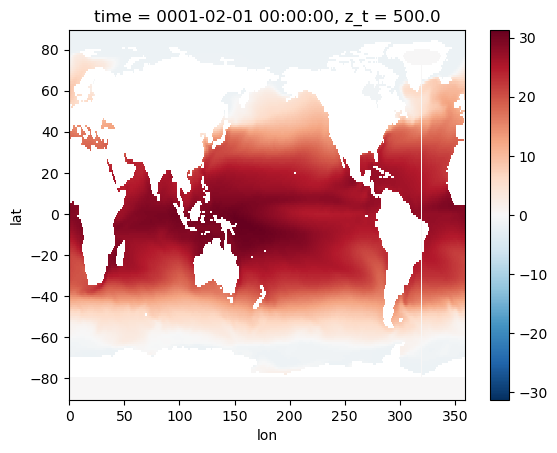

In [7]:
ds_tos.isel(time=0).plot()

## Subset data

In [8]:
#  Read Variable
area='Jakob'
if area == 'TROPIC':
    # central pacific coordinates
    arealat=(35,-35)
    arealon=[-180, 180.]
elif area == 'GLOBAL':
    arealat=(60,-60)
    arealon=[-160,110.]
elif area == 'WORLD':
    arealat=(60,-60)
    arealon=[-180,180.]
elif area == 'NAVARRA_2021':
    arealat=(-15,15)
    arealon=[140,290.]
elif area == 'Jakob':
    arealat=(-31,32)
    arealon=[130,290.]
else:
    Print(f'No area ')
    
case = 'UNIT'    
data_name= 'CESM'
variable='SST'
lev = 'SURF'
shift = 'ERA5'
period = 'ANN'
normalization = 'anom'

# Use SVD encoding
encode_svd = True
#Choose number of SVD to ratain
var_retained = None #None# Variance retained or None for full rank
#Option to write files
write_files = False

In [9]:
S_tos = ds_tos.sel(lat=slice(arealat[0],arealat[1]),lon=slice(arealon[0],arealon[1]))
S_ssh = ds_ssh.sel(lat=slice(arealat[0],arealat[1]),lon=slice(arealon[0],arealon[1]))

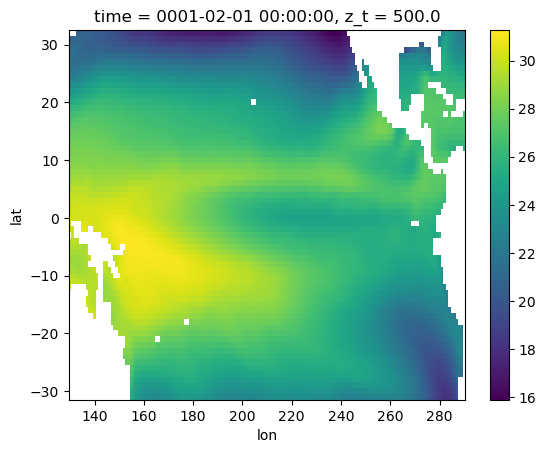

In [10]:
S_tos.isel(time=0).plot()

In [11]:
del(ds_tos, ds_ssh)

In [12]:
import psutil
psutil.virtual_memory() 

svmem(total=540408909824, available=522492436480, percent=3.3, used=12831838208, free=523822575616, active=1933672448, inactive=4693135360, buffers=4382720, cached=3750113280, shared=2015526912, slab=1482817536)

## Create matrices, de-trending data and anomalies

In [13]:
#Create Xmats
X_tos=zcom.Xmat(S_tos,dims=('lat','lon'))
X_tos.A = X_tos.A.dropna(dim='z')

 Created mathematical matrix A, 
                 stacked along dimensions ('lat', 'lon') 


In [14]:
X_ssh=zcom.Xmat(S_ssh,dims=('lat','lon'))
X_ssh.A = X_ssh.A.dropna(dim='z')

 Created mathematical matrix A, 
                 stacked along dimensions ('lat', 'lon') 


In [15]:
del(S_tos,S_ssh)

In [16]:
#Detrending
X_tos.detrend(axis=1)
X_ssh.detrend(axis=1)

Detrending data with options -->  {'axis': 1}
Detrending data with options -->  {'axis': 1}


In [17]:
#Anomalies
X_tos.anom(option='anomstd',freq='month')
X_ssh.anom(option='anomstd',freq='month')

In [18]:
del(X_ssh)

# 75 years

### Tools for the plots

In [60]:
import nc_time_axis

In [61]:
flabel = {'fontsize':14,'fontweight':'bold'}   #,'fontfamily':'Futura'
ftitle = {'fontsize':18,'fontweight':'bold'}   #,'fontfamily':'Futura',

In [62]:
from pylab import *

cmap = cm.get_cmap('plasma', 19)
color_list = [matplotlib.colors.rgb2hex(cmap(i)[:3]) for i in range(cmap.N)]

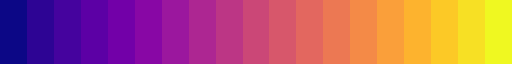

In [63]:
cmap   # First forecasts purple,    last forecasts yellow

### Data preparation

In [64]:
## Load EOFs
PCs=np.load('Processed_data/PCs_CESM_845SST_1000SSH.npy')
EOFs=np.load('Processed_data/EOFs_CESM_845SST_1000SSH.npy')

In [65]:
for_levels=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]
periods=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
periods_150=[0,1,2,3,4,5,6,7,8,9,10,11,12]
lead_times=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]

## ALL GAUSS

In [66]:
mean_av=np.zeros((24,13))
mean_ind=np.zeros((24,2,13))

RMSE_mean_av=np.zeros((24,13))
RMSE_mean_ind=np.zeros((24,2,13))

In [67]:
#Select EOFs
udat_sst=EOFs[:,0:845]

In [68]:
## Compute observations NON truncated to PCs
Xindex=X_tos.A.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))#[:-1]
Xindex

<xarray.DataArray (time: 24000)>
array([-0.07060546,  0.05650981,  0.28544343, ..., -0.9016017 ,
       -0.9271781 , -0.89309406], dtype=float32)
Coordinates:
  * time     (time) object 0001-02-01 00:00:00 ... 2001-01-01 00:00:00
    z_t      float32 500.0
    month    (time) int64 2 3 4 5 6 7 8 9 10 11 12 ... 3 4 5 6 7 8 9 10 11 12 1

In [69]:
tot_for_union=np.empty((2, 845, 24, 24000))
tot_for_union.fill(np.NaN)

In [70]:
for m in lead_times:
    for n in periods_150:
        tot_for_union[:,:,m, m + n*1800 : m + n*1800 +1776]=np.load(f'150 years testing/150 years testing-Forecasts 75/ALLEOFs_forecast_p{n}.npy')[:,0:845,m,:]

In [71]:
tot_for_union.shape

(2, 845, 24, 24000)

In [72]:
for m in periods_150:

    Xindex1=Xindex.isel(time=slice(0+150*12*m,150*12+150*12*m))
    X_tos1=X_tos.A[:,0+150*12*m:150*12+150*12*m]
    
    tot_for_union1=tot_for_union[:,:,:,0+150*12*m:150*12+150*12*m]
    print('Period ', m, '  forecast: ',m*2)
    
    for n in lead_times:
    
        lead=n
    
        # Compute average forecast
        av_for=np.nanmean(tot_for_union1, axis=0)
        av_for_geo_array=udat_sst @ av_for[0:845,lead,:]            
        av_for_geo = xr.full_like(X_tos1[:,:],0)
        av_for_geo.data=av_for_geo_array.real
        Avindex=av_for_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))

        #Correlation average forecast and observations
        mean_av[lead,m]=np.corrcoef(Xindex1[np.invert(np.isnan(Avindex))],Avindex[np.invert(np.isnan(Avindex))])[0,1]
        RMSE_mean_av[lead,m]=1-np.sqrt(np.square(np.subtract(Xindex1[np.invert(np.isnan(Avindex))],Avindex[np.invert(np.isnan(Avindex))])).mean()) / np.std(Xindex1[np.invert(np.isnan(Avindex))])
        print("Lead ", n, " ensemble mean correlation ",mean_av[lead,m])
    
        #Average correlation between individual forecast and observations
        for i in range(2):  
            phix_geo_array=udat_sst @ tot_for_union1[i,0:845,lead,:]  
            phix_geo = xr.full_like(X_tos1[:,:],0)
            phix_geo.data=phix_geo_array.real
            Phiindex=phix_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))

            mean_ind[lead,i,m]=np.corrcoef(Xindex1[np.invert(np.isnan(Phiindex))],Phiindex[np.invert(np.isnan(Phiindex))])[0,1]
            RMSE_mean_ind[lead,i,m]= 1-np.sqrt(np.square(np.subtract(Xindex1[np.invert(np.isnan(Phiindex))],Phiindex[np.invert(np.isnan(Phiindex))])).mean()) / np.std(Xindex1[np.invert(np.isnan(Phiindex))])
            
        av_corr=np.mean(mean_ind[lead,:,m], axis=0)
        print("Lead ", n, " ensemble member correlation ",av_corr)
        
        
'''        #Plot
        import nc_time_axis
    
        fig, ax = plt.subplots(1, 1, figsize=(16,3.5),squeeze=False)
    
        Xindex1.plot(label='Untruncated Obs',lw=1.2,color='gray')
    
        for i in range(3):  
            #Expand forecast to geographical domain
            phix_geo_array=udat_sst @ tot_for_union1[i,0:845,lead,:]  
            phix_geo = xr.full_like(X_tos1[:,:],0)
            phix_geo.data=phix_geo_array.real
    
            Phiindex=phix_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))
            Phiindex.plot(lw=0.5, color='red', alpha=0.4)
    
        Avindex.plot(label='Average forecast',lw=0.8,color='blue')

        plt.axhline(0,color='black',lw=0.5)
        plt.title(f'NINO3.4 forecast Lead {lead}',ftitle)
        plt.title(f'Gaussian Kernel',loc='left',**flabel)
        plt.xlabel(' ')
        plt.legend(loc='upper right')
        zmap.changebox(plt.gca(),'all',linewidth=1.5)
        #loctime = Xindex1.sel(time='1-JAN-2000').time.data
        cstr1 = f' Corr aver. for: {mean_av[lead,m]:>.2f}'
        cstr2 = f' Aver. corr of ind. for: {av_corr:>.2f}'
        loctime = Xindex1.isel(time=450).time.data
        plt.text(loctime,-2.1,cstr1)
        plt.text(loctime,-2.3,cstr2)
        #labfile =  f'{data_name}{case}_NINO3BANDA_{KK.kernel_choice}{tolone}.pdf'
        #plt.savefig(labfile, orientation='landscape',  format='pdf')
        plt.show()'''


Period  0   forecast:  0
Lead  0  ensemble mean correlation  0.9646176520297112
Lead  0  ensemble member correlation  0.965628866996825
Lead  1  ensemble mean correlation  0.9493614452287662
Lead  1  ensemble member correlation  0.949533322187206
Lead  2  ensemble mean correlation  0.9243289097887109
Lead  2  ensemble member correlation  0.9244626424292257
Lead  3  ensemble mean correlation  0.8969611564089027
Lead  3  ensemble member correlation  0.8972495781933416
Lead  4  ensemble mean correlation  0.8588208708725961
Lead  4  ensemble member correlation  0.8592036053926696
Lead  5  ensemble mean correlation  0.8168570494395201
Lead  5  ensemble member correlation  0.8170307746316463
Lead  6  ensemble mean correlation  0.7748038125199573
Lead  6  ensemble member correlation  0.7747501539738263
Lead  7  ensemble mean correlation  0.7275764776973161
Lead  7  ensemble member correlation  0.7275302612325009
Lead  8  ensemble mean correlation  0.6845926086808041
Lead  8  ensemble member c

"        #Plot\n        import nc_time_axis\n    \n        fig, ax = plt.subplots(1, 1, figsize=(16,3.5),squeeze=False)\n    \n        Xindex1.plot(label='Untruncated Obs',lw=1.2,color='gray')\n    \n        for i in range(3):  \n            #Expand forecast to geographical domain\n            phix_geo_array=udat_sst @ tot_for_union1[i,0:845,lead,:]  \n            phix_geo = xr.full_like(X_tos1[:,:],0)\n            phix_geo.data=phix_geo_array.real\n    \n            Phiindex=phix_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))\n            Phiindex.plot(lw=0.5, color='red', alpha=0.4)\n    \n        Avindex.plot(label='Average forecast',lw=0.8,color='blue')\n\n        plt.axhline(0,color='black',lw=0.5)\n        plt.title(f'NINO3.4 forecast Lead {lead}',ftitle)\n        plt.title(f'Gaussian Kernel',loc='left',**flabel)\n        plt.xlabel(' ')\n        plt.legend(loc='upper right')\n        zmap.changebox(plt.gca(),'all',linewidth=1.5)\n        #loctime =

In [73]:
np.save('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEAN_CORR_GAUSSALL_75', mean_av, allow_pickle=True, fix_imports=True)
np.save('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEMBERS_CORR_GAUSSALL_75', mean_ind, allow_pickle=True, fix_imports=True)
np.save('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEAN_RMSE_GAUSSALL_75', RMSE_mean_av, allow_pickle=True, fix_imports=True)
np.save('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEMBERS_RMSE_GAUSSALL_75', RMSE_mean_ind, allow_pickle=True, fix_imports=True)

## ALL GAUSS OV

In [57]:
mean_av=np.zeros((24,13))
mean_ind=np.zeros((24,3,13))

RMSE_mean_av=np.zeros((24,13))
RMSE_mean_ind=np.zeros((24,3,13))

In [58]:
#Select EOFs
udat_sst=EOFs[:,0:845]

In [60]:
## Compute observations NON truncated to PCs
Xindex=X_tos.A.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))#[:-1]
Xindex

<xarray.DataArray (time: 24000)>
array([-0.07060546,  0.05650981,  0.28544343, ..., -0.9016017 ,
       -0.9271781 , -0.89309406], dtype=float32)
Coordinates:
  * time     (time) object 0001-02-01 00:00:00 ... 2001-01-01 00:00:00
    z_t      float32 500.0
    month    (time) int64 2 3 4 5 6 7 8 9 10 11 12 ... 3 4 5 6 7 8 9 10 11 12 1

In [61]:
tot_for_union=np.empty((3, 845, 24, 24000))
tot_for_union.fill(np.NaN)

In [63]:
for m in lead_times:
    for n in periods_150:
        tot_for_union[0:2,:,m, m + n*1800 : m + n*1800 +1776]=np.load(f'150 years testing/150 years testing-Forecasts 75/ALLEOFs_forecast_p{n}.npy')[:,0:845,m,:]

In [65]:
for m in lead_times:
    for n in periods_150:
        tot_for_union[2,:,m, m + n*1800 : m + n*1800 +1776]=np.load(f'150 years testing/150 years testing-Forecasts 75/ALLEOFs_forecast_p{n}_OV.npy')[:,0:845,m,:]

In [66]:
for m in periods_150:

    Xindex1=Xindex.isel(time=slice(0+150*12*m,150*12+150*12*m))
    X_tos1=X_tos.A[:,0+150*12*m:150*12+150*12*m]
    
    tot_for_union1=tot_for_union[:,:,:,0+150*12*m:150*12+150*12*m]
    print('Period ', m, '  forecast: ',m*2)
    
    for n in lead_times:
    
        lead=n
    
        # Compute average forecast
        av_for=np.nanmean(tot_for_union1, axis=0)
        av_for_geo_array=udat_sst @ av_for[0:845,lead,:]            
        av_for_geo = xr.full_like(X_tos1[:,:],0)
        av_for_geo.data=av_for_geo_array.real
        Avindex=av_for_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))

        #Correlation average forecast and observations
        mean_av[lead,m]=np.corrcoef(Xindex1[np.invert(np.isnan(Avindex))],Avindex[np.invert(np.isnan(Avindex))])[0,1]
        RMSE_mean_av[lead,m]=1-np.sqrt(np.square(np.subtract(Xindex1[np.invert(np.isnan(Avindex))],Avindex[np.invert(np.isnan(Avindex))])).mean()) / np.std(Xindex1[np.invert(np.isnan(Avindex))])
        print("Lead ", n, " ensemble mean correlation ",mean_av[lead,m])
    
        #Average correlation between individual forecast and observations
        for i in range(3):  
            phix_geo_array=udat_sst @ tot_for_union1[i,0:845,lead,:]  
            phix_geo = xr.full_like(X_tos1[:,:],0)
            phix_geo.data=phix_geo_array.real
            Phiindex=phix_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))

            mean_ind[lead,i,m]=np.corrcoef(Xindex1[np.invert(np.isnan(Phiindex))],Phiindex[np.invert(np.isnan(Phiindex))])[0,1]
            RMSE_mean_ind[lead,i,m]= 1-np.sqrt(np.square(np.subtract(Xindex1[np.invert(np.isnan(Phiindex))],Phiindex[np.invert(np.isnan(Phiindex))])).mean()) / np.std(Xindex1[np.invert(np.isnan(Phiindex))])
            
        av_corr=np.mean(mean_ind[lead,:,m], axis=0)
        print("Lead ", n, " ensemble member correlation ",av_corr)
        
        
'''        #Plot
        import nc_time_axis
    
        fig, ax = plt.subplots(1, 1, figsize=(16,3.5),squeeze=False)
    
        Xindex1.plot(label='Untruncated Obs',lw=1.2,color='gray')
    
        for i in range(3):  
            #Expand forecast to geographical domain
            phix_geo_array=udat_sst @ tot_for_union1[i,0:845,lead,:]  
            phix_geo = xr.full_like(X_tos1[:,:],0)
            phix_geo.data=phix_geo_array.real
    
            Phiindex=phix_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))
            Phiindex.plot(lw=0.5, color='red', alpha=0.4)
    
        Avindex.plot(label='Average forecast',lw=0.8,color='blue')

        plt.axhline(0,color='black',lw=0.5)
        plt.title(f'NINO3.4 forecast Lead {lead}',ftitle)
        plt.title(f'Gaussian Kernel',loc='left',**flabel)
        plt.xlabel(' ')
        plt.legend(loc='upper right')
        zmap.changebox(plt.gca(),'all',linewidth=1.5)
        #loctime = Xindex1.sel(time='1-JAN-2000').time.data
        cstr1 = f' Corr aver. for: {mean_av[lead,m]:>.2f}'
        cstr2 = f' Aver. corr of ind. for: {av_corr:>.2f}'
        loctime = Xindex1.isel(time=450).time.data
        plt.text(loctime,-2.1,cstr1)
        plt.text(loctime,-2.3,cstr2)
        #labfile =  f'{data_name}{case}_NINO3BANDA_{KK.kernel_choice}{tolone}.pdf'
        #plt.savefig(labfile, orientation='landscape',  format='pdf')
        plt.show()'''


Period  0   forecast:  0
Lead  0  ensemble mean correlation  0.9653917806848529
Lead  0  ensemble member correlation  0.9662573983879336
Lead  1  ensemble mean correlation  0.9490266279621409
Lead  1  ensemble member correlation  0.9484952727340131
Lead  2  ensemble mean correlation  0.9237103615545067
Lead  2  ensemble member correlation  0.9234702305917298
Lead  3  ensemble mean correlation  0.8954861461683479
Lead  3  ensemble member correlation  0.8955006002648979
Lead  4  ensemble mean correlation  0.8574460995281991
Lead  4  ensemble member correlation  0.8566291951477755
Lead  5  ensemble mean correlation  0.8133661353463311
Lead  5  ensemble member correlation  0.8127592449351786
Lead  6  ensemble mean correlation  0.7713843368727252
Lead  6  ensemble member correlation  0.7686699407685644
Lead  7  ensemble mean correlation  0.7254287884122734
Lead  7  ensemble member correlation  0.7217164445483654
Lead  8  ensemble mean correlation  0.6807599565896808
Lead  8  ensemble member

"        #Plot\n        import nc_time_axis\n    \n        fig, ax = plt.subplots(1, 1, figsize=(16,3.5),squeeze=False)\n    \n        Xindex1.plot(label='Untruncated Obs',lw=1.2,color='gray')\n    \n        for i in range(3):  \n            #Expand forecast to geographical domain\n            phix_geo_array=udat_sst @ tot_for_union1[i,0:845,lead,:]  \n            phix_geo = xr.full_like(X_tos1[:,:],0)\n            phix_geo.data=phix_geo_array.real\n    \n            Phiindex=phix_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))\n            Phiindex.plot(lw=0.5, color='red', alpha=0.4)\n    \n        Avindex.plot(label='Average forecast',lw=0.8,color='blue')\n\n        plt.axhline(0,color='black',lw=0.5)\n        plt.title(f'NINO3.4 forecast Lead {lead}',ftitle)\n        plt.title(f'Gaussian Kernel',loc='left',**flabel)\n        plt.xlabel(' ')\n        plt.legend(loc='upper right')\n        zmap.changebox(plt.gca(),'all',linewidth=1.5)\n        #loctime =

In [67]:
np.save('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEAN_CORR_GAUSALL_75_OV', mean_av, allow_pickle=True, fix_imports=True)
np.save('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEMBERS_CORR_GAUSALL_75_OV', mean_ind, allow_pickle=True, fix_imports=True)
np.save('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEAN_RMSE_GAUSALL_75_OV', RMSE_mean_av, allow_pickle=True, fix_imports=True)
np.save('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEMBERS_RMSE_GAUSALL_75_OV', RMSE_mean_ind, allow_pickle=True, fix_imports=True)

In [68]:
np.save('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEAN_CORR_GAUSALL_75_OV', mean_av, allow_pickle=True, fix_imports=True)
np.save('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEMBERS_CORR_GAUSALL_75_OV', mean_ind, allow_pickle=True, fix_imports=True)
np.save('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEAN_RMSE_GAUSALL_75_OV', RMSE_mean_av, allow_pickle=True, fix_imports=True)
np.save('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEMBERS_RMSE_GAUSALL_75_OV', RMSE_mean_ind, allow_pickle=True, fix_imports=True)

## 30 GAUSS

In [29]:
mean_av=np.zeros((24,13))
mean_ind=np.zeros((24,2,13))

RMSE_mean_av=np.zeros((24,13))
RMSE_mean_ind=np.zeros((24,2,13))

In [30]:
#Select EOFs
udat_sst=EOFs[:,0:20]

In [31]:
## Compute observations NON truncated to PCs
Xindex=X_tos.A.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))#[:-1]
Xindex

<xarray.DataArray (time: 24000)>
array([-0.07060546,  0.05650981,  0.28544343, ..., -0.9016017 ,
       -0.9271781 , -0.89309406], dtype=float32)
Coordinates:
  * time     (time) object 0001-02-01 00:00:00 ... 2001-01-01 00:00:00
    z_t      float32 500.0
    month    (time) int64 2 3 4 5 6 7 8 9 10 11 12 ... 3 4 5 6 7 8 9 10 11 12 1

In [32]:
tot_for_union=np.empty((2, 20, 24, 24000))
tot_for_union.fill(np.NaN)

In [33]:
for m in lead_times:
    for n in periods_150:
        tot_for_union[:,:,m, m + n*1800 : m + n*1800 +1776]=np.load(f'150 years testing/150 years testing-Forecasts 75/30EOFs_forecast_p{n}.npy')[:,0:20,m,:]

In [34]:
for m in periods_150:

    Xindex1=Xindex.isel(time=slice(0+150*12*m,150*12+150*12*m))
    X_tos1=X_tos.A[:,0+150*12*m:150*12+150*12*m]
    
    tot_for_union1=tot_for_union[:,:,:,0+150*12*m:150*12+150*12*m]
    print('Period ', m, '  forecast: ',m*2)
    
    for n in lead_times:
    
        lead=n
    
        # Compute average forecast
        av_for=np.nanmean(tot_for_union1, axis=0)
        av_for_geo_array=udat_sst @ av_for[0:20,lead,:]            
        av_for_geo = xr.full_like(X_tos1[:,:],0)
        av_for_geo.data=av_for_geo_array.real
        Avindex=av_for_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))

        #Correlation average forecast and observations
        mean_av[lead,m]=np.corrcoef(Xindex1[np.invert(np.isnan(Avindex))],Avindex[np.invert(np.isnan(Avindex))])[0,1]
        RMSE_mean_av[lead,m]=1-np.sqrt(np.square(np.subtract(Xindex1[np.invert(np.isnan(Avindex))],Avindex[np.invert(np.isnan(Avindex))])).mean()) / np.std(Xindex1[np.invert(np.isnan(Avindex))])
        print("Lead ", n, " ensemble mean correlation ",mean_av[lead,m])
    
        #Average correlation between individual forecast and observations
        for i in range(2):  
            phix_geo_array=udat_sst @ tot_for_union1[i,0:20,lead,:]  
            phix_geo = xr.full_like(X_tos1[:,:],0)
            phix_geo.data=phix_geo_array.real
            Phiindex=phix_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))

            mean_ind[lead,i,m]=np.corrcoef(Xindex1[np.invert(np.isnan(Phiindex))],Phiindex[np.invert(np.isnan(Phiindex))])[0,1]
            RMSE_mean_ind[lead,i,m]= 1-np.sqrt(np.square(np.subtract(Xindex1[np.invert(np.isnan(Phiindex))],Phiindex[np.invert(np.isnan(Phiindex))])).mean()) / np.std(Xindex1[np.invert(np.isnan(Phiindex))])
            
        av_corr=np.mean(mean_ind[lead,:,m], axis=0)
        print("Lead ", n, " ensemble member correlation ",av_corr)
        
        
'''        #Plot
        import nc_time_axis
    
        fig, ax = plt.subplots(1, 1, figsize=(16,3.5),squeeze=False)
    
        Xindex1.plot(label='Untruncated Obs',lw=1.2,color='gray')
    
        for i in range(3):  
            #Expand forecast to geographical domain
            phix_geo_array=udat_sst @ tot_for_union1[i,0:20,lead,:]  
            phix_geo = xr.full_like(X_tos1[:,:],0)
            phix_geo.data=phix_geo_array.real
    
            Phiindex=phix_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))
            Phiindex.plot(lw=0.5, color='red', alpha=0.4)
    
        Avindex.plot(label='Average forecast',lw=0.8,color='blue')

        plt.axhline(0,color='black',lw=0.5)
        plt.title(f'NINO3.4 forecast Lead {lead}',ftitle)
        plt.title(f'Gaussian Kernel',loc='left',**flabel)
        plt.xlabel(' ')
        plt.legend(loc='upper right')
        zmap.changebox(plt.gca(),'all',linewidth=1.5)
        #loctime = Xindex1.sel(time='1-JAN-2000').time.data
        cstr1 = f' Corr aver. for: {mean_av[lead,m]:>.2f}'
        cstr2 = f' Aver. corr of ind. for: {av_corr:>.2f}'
        loctime = Xindex1.isel(time=450).time.data
        plt.text(loctime,-2.1,cstr1)
        plt.text(loctime,-2.3,cstr2)
        #labfile =  f'{data_name}{case}_NINO3BANDA_{KK.kernel_choice}{tolone}.pdf'
        #plt.savefig(labfile, orientation='landscape',  format='pdf')
        plt.show()'''


Period  0   forecast:  0
Lead  0  ensemble mean correlation  0.9653249981061466
Lead  0  ensemble member correlation  0.9661210740555917
Lead  1  ensemble mean correlation  0.9402573826066907
Lead  1  ensemble member correlation  0.9403627037945309
Lead  2  ensemble mean correlation  0.9016614531891576
Lead  2  ensemble member correlation  0.901493330815194
Lead  3  ensemble mean correlation  0.861943479875177
Lead  3  ensemble member correlation  0.8619317571151741
Lead  4  ensemble mean correlation  0.8073812348932982
Lead  4  ensemble member correlation  0.8067883437278982
Lead  5  ensemble mean correlation  0.7630477893030172
Lead  5  ensemble member correlation  0.7617855683162592
Lead  6  ensemble mean correlation  0.710591299116918
Lead  6  ensemble member correlation  0.710148647550426
Lead  7  ensemble mean correlation  0.6550143488375724
Lead  7  ensemble member correlation  0.6544675866141745
Lead  8  ensemble mean correlation  0.5878406132265863
Lead  8  ensemble member cor

KeyboardInterrupt: 

In [89]:
np.save('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEAN_CORR_GAUSS30_75', mean_av, allow_pickle=True, fix_imports=True)
np.save('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEMBERS_CORR_GAUSS30_75', mean_ind, allow_pickle=True, fix_imports=True)
np.save('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEAN_RMSE_GAUSS30_75', RMSE_mean_av, allow_pickle=True, fix_imports=True)
np.save('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEMBERS_RMSE_GAUSS30_75', RMSE_mean_ind, allow_pickle=True, fix_imports=True)

## 30 GAUSS OV

In [35]:
mean_av=np.zeros((24,13))
mean_ind=np.zeros((24,3,13))

RMSE_mean_av=np.zeros((24,13))
RMSE_mean_ind=np.zeros((24,3,13))

In [36]:
#Select EOFs
udat_sst=EOFs[:,0:20]

In [37]:
## Compute observations NON truncated to PCs
Xindex=X_tos.A.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))#[:-1]
Xindex

<xarray.DataArray (time: 24000)>
array([-0.07060546,  0.05650981,  0.28544343, ..., -0.9016017 ,
       -0.9271781 , -0.89309406], dtype=float32)
Coordinates:
  * time     (time) object 0001-02-01 00:00:00 ... 2001-01-01 00:00:00
    z_t      float32 500.0
    month    (time) int64 2 3 4 5 6 7 8 9 10 11 12 ... 3 4 5 6 7 8 9 10 11 12 1

In [38]:
tot_for_union=np.empty((3, 20, 24, 24000))
tot_for_union.fill(np.NaN)

In [39]:
for m in lead_times:
    for n in periods_150:
        tot_for_union[0:2,:,m, m + n*1800 : m + n*1800 +1776]=np.load(f'150 years testing/150 years testing-Forecasts 75/30EOFs_forecast_p{n}.npy')[:,0:20,m,:]

In [41]:
for m in lead_times:
    for n in periods_150:
        tot_for_union[2,:,m, m + n*1800 : m + n*1800 +1776]=np.load(f'150 years testing/150 years testing-Forecasts 75/30EOFs_forecast_p{n}_OV.npy')[:,0:20,m,:]

In [42]:
for m in periods_150:

    Xindex1=Xindex.isel(time=slice(0+150*12*m,150*12+150*12*m))
    X_tos1=X_tos.A[:,0+150*12*m:150*12+150*12*m]
    
    tot_for_union1=tot_for_union[:,:,:,0+150*12*m:150*12+150*12*m]
    print('Period ', m, '  forecast: ',m*2)
    
    for n in lead_times:
    
        lead=n
    
        # Compute average forecast
        av_for=np.nanmean(tot_for_union1, axis=0)
        av_for_geo_array=udat_sst @ av_for[0:20,lead,:]            
        av_for_geo = xr.full_like(X_tos1[:,:],0)
        av_for_geo.data=av_for_geo_array.real
        Avindex=av_for_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))

        #Correlation average forecast and observations
        mean_av[lead,m]=np.corrcoef(Xindex1[np.invert(np.isnan(Avindex))],Avindex[np.invert(np.isnan(Avindex))])[0,1]
        RMSE_mean_av[lead,m]=1-np.sqrt(np.square(np.subtract(Xindex1[np.invert(np.isnan(Avindex))],Avindex[np.invert(np.isnan(Avindex))])).mean()) / np.std(Xindex1[np.invert(np.isnan(Avindex))])
        print("Lead ", n, " ensemble mean correlation ",mean_av[lead,m])
    
        #Average correlation between individual forecast and observations
        for i in range(3):  
            phix_geo_array=udat_sst @ tot_for_union1[i,0:20,lead,:]  
            phix_geo = xr.full_like(X_tos1[:,:],0)
            phix_geo.data=phix_geo_array.real
            Phiindex=phix_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))

            mean_ind[lead,i,m]=np.corrcoef(Xindex1[np.invert(np.isnan(Phiindex))],Phiindex[np.invert(np.isnan(Phiindex))])[0,1]
            RMSE_mean_ind[lead,i,m]= 1-np.sqrt(np.square(np.subtract(Xindex1[np.invert(np.isnan(Phiindex))],Phiindex[np.invert(np.isnan(Phiindex))])).mean()) / np.std(Xindex1[np.invert(np.isnan(Phiindex))])
            
        av_corr=np.mean(mean_ind[lead,:,m], axis=0)
        print("Lead ", n, " ensemble member correlation ",av_corr)
        
        
'''        #Plot
        import nc_time_axis
    
        fig, ax = plt.subplots(1, 1, figsize=(16,3.5),squeeze=False)
    
        Xindex1.plot(label='Untruncated Obs',lw=1.2,color='gray')
    
        for i in range(3):  
            #Expand forecast to geographical domain
            phix_geo_array=udat_sst @ tot_for_union1[i,0:20,lead,:]  
            phix_geo = xr.full_like(X_tos1[:,:],0)
            phix_geo.data=phix_geo_array.real
    
            Phiindex=phix_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))
            Phiindex.plot(lw=0.5, color='red', alpha=0.4)
    
        Avindex.plot(label='Average forecast',lw=0.8,color='blue')

        plt.axhline(0,color='black',lw=0.5)
        plt.title(f'NINO3.4 forecast Lead {lead}',ftitle)
        plt.title(f'Gaussian Kernel',loc='left',**flabel)
        plt.xlabel(' ')
        plt.legend(loc='upper right')
        zmap.changebox(plt.gca(),'all',linewidth=1.5)
        #loctime = Xindex1.sel(time='1-JAN-2000').time.data
        cstr1 = f' Corr aver. for: {mean_av[lead,m]:>.2f}'
        cstr2 = f' Aver. corr of ind. for: {av_corr:>.2f}'
        loctime = Xindex1.isel(time=450).time.data
        plt.text(loctime,-2.1,cstr1)
        plt.text(loctime,-2.3,cstr2)
        #labfile =  f'{data_name}{case}_NINO3BANDA_{KK.kernel_choice}{tolone}.pdf'
        #plt.savefig(labfile, orientation='landscape',  format='pdf')
        plt.show()'''


Period  0   forecast:  0
Lead  0  ensemble mean correlation  0.964928377326954
Lead  0  ensemble member correlation  0.9657806070461312
Lead  1  ensemble mean correlation  0.9416370848118331
Lead  1  ensemble member correlation  0.9394476045371473
Lead  2  ensemble mean correlation  0.9072303240156181
Lead  2  ensemble member correlation  0.9032128553285781
Lead  3  ensemble mean correlation  0.867182263825141
Lead  3  ensemble member correlation  0.8643279955493597
Lead  4  ensemble mean correlation  0.8138621180592399
Lead  4  ensemble member correlation  0.8095275174613747
Lead  5  ensemble mean correlation  0.7636077699677731
Lead  5  ensemble member correlation  0.7578797282659272
Lead  6  ensemble mean correlation  0.7142752687999248
Lead  6  ensemble member correlation  0.7093479205430472
Lead  7  ensemble mean correlation  0.6652817188670425
Lead  7  ensemble member correlation  0.6605721939168143
Lead  8  ensemble mean correlation  0.5968867371621993
Lead  8  ensemble member c

"        #Plot\n        import nc_time_axis\n    \n        fig, ax = plt.subplots(1, 1, figsize=(16,3.5),squeeze=False)\n    \n        Xindex1.plot(label='Untruncated Obs',lw=1.2,color='gray')\n    \n        for i in range(3):  \n            #Expand forecast to geographical domain\n            phix_geo_array=udat_sst @ tot_for_union1[i,0:20,lead,:]  \n            phix_geo = xr.full_like(X_tos1[:,:],0)\n            phix_geo.data=phix_geo_array.real\n    \n            Phiindex=phix_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))\n            Phiindex.plot(lw=0.5, color='red', alpha=0.4)\n    \n        Avindex.plot(label='Average forecast',lw=0.8,color='blue')\n\n        plt.axhline(0,color='black',lw=0.5)\n        plt.title(f'NINO3.4 forecast Lead {lead}',ftitle)\n        plt.title(f'Gaussian Kernel',loc='left',**flabel)\n        plt.xlabel(' ')\n        plt.legend(loc='upper right')\n        zmap.changebox(plt.gca(),'all',linewidth=1.5)\n        #loctime = 

In [43]:
np.save('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEAN_CORR_GAUSS30_75_OV', mean_av, allow_pickle=True, fix_imports=True)
np.save('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEMBERS_CORR_GAUSS30_75_OV', mean_ind, allow_pickle=True, fix_imports=True)
np.save('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEAN_RMSE_GAUSS30_75_OV', RMSE_mean_av, allow_pickle=True, fix_imports=True)
np.save('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEMBERS_RMSE_GAUSS30_75_OV', RMSE_mean_ind, allow_pickle=True, fix_imports=True)

## 30 POLY

In [44]:
mean_av=np.zeros((24,13))
mean_ind=np.zeros((24,2,13))

RMSE_mean_av=np.zeros((24,13))
RMSE_mean_ind=np.zeros((24,2,13))

In [45]:
#Select EOFs
udat_sst=EOFs[:,0:20]

In [46]:
## Compute observations NON truncated to PCs
Xindex=X_tos.A.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))#[:-1]
Xindex

<xarray.DataArray (time: 24000)>
array([-0.07060546,  0.05650981,  0.28544343, ..., -0.9016017 ,
       -0.9271781 , -0.89309406], dtype=float32)
Coordinates:
  * time     (time) object 0001-02-01 00:00:00 ... 2001-01-01 00:00:00
    z_t      float32 500.0
    month    (time) int64 2 3 4 5 6 7 8 9 10 11 12 ... 3 4 5 6 7 8 9 10 11 12 1

In [47]:
tot_for_union=np.empty((2, 20, 24, 24000))
tot_for_union.fill(np.NaN)

In [48]:
for m in lead_times:
    for n in periods_150:
        tot_for_union[:,:,m, m + n*1800 : m + n*1800 +1776]=np.load(f'150 years testing/150 years testing-Forecasts 75/POLY_forecast_p{n}.npy')[:,0:20,m,:]

In [49]:
for m in periods_150:

    Xindex1=Xindex.isel(time=slice(0+150*12*m,150*12+150*12*m))
    X_tos1=X_tos.A[:,0+150*12*m:150*12+150*12*m]
    
    tot_for_union1=tot_for_union[:,:,:,0+150*12*m:150*12+150*12*m]
    print('Period ', m, '  forecast: ',m*2)
    
    for n in lead_times:
    
        lead=n
    
        # Compute average forecast
        av_for=np.nanmean(tot_for_union1, axis=0)
        av_for_geo_array=udat_sst @ av_for[0:20,lead,:]            
        av_for_geo = xr.full_like(X_tos1[:,:],0)
        av_for_geo.data=av_for_geo_array.real
        Avindex=av_for_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))

        #Correlation average forecast and observations
        mean_av[lead,m]=np.corrcoef(Xindex1[np.invert(np.isnan(Avindex))],Avindex[np.invert(np.isnan(Avindex))])[0,1]
        RMSE_mean_av[lead,m]=1-np.sqrt(np.square(np.subtract(Xindex1[np.invert(np.isnan(Avindex))],Avindex[np.invert(np.isnan(Avindex))])).mean()) / np.std(Xindex1[np.invert(np.isnan(Avindex))])
        print("Lead ", n, " ensemble mean correlation ",mean_av[lead,m])
    
        #Average correlation between individual forecast and observations
        for i in range(2):  
            phix_geo_array=udat_sst @ tot_for_union1[i,0:20,lead,:]  
            phix_geo = xr.full_like(X_tos1[:,:],0)
            phix_geo.data=phix_geo_array.real
            Phiindex=phix_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))

            mean_ind[lead,i,m]=np.corrcoef(Xindex1[np.invert(np.isnan(Phiindex))],Phiindex[np.invert(np.isnan(Phiindex))])[0,1]
            RMSE_mean_ind[lead,i,m]= 1-np.sqrt(np.square(np.subtract(Xindex1[np.invert(np.isnan(Phiindex))],Phiindex[np.invert(np.isnan(Phiindex))])).mean()) / np.std(Xindex1[np.invert(np.isnan(Phiindex))])
            
        av_corr=np.mean(mean_ind[lead,:,m], axis=0)
        print("Lead ", n, " ensemble member correlation ",av_corr)
        
        
'''        #Plot
        import nc_time_axis
    
        fig, ax = plt.subplots(1, 1, figsize=(16,3.5),squeeze=False)
    
        Xindex1.plot(label='Untruncated Obs',lw=1.2,color='gray')
    
        for i in range(3):  
            #Expand forecast to geographical domain
            phix_geo_array=udat_sst @ tot_for_union1[i,0:20,lead,:]  
            phix_geo = xr.full_like(X_tos1[:,:],0)
            phix_geo.data=phix_geo_array.real
    
            Phiindex=phix_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))
            Phiindex.plot(lw=0.5, color='red', alpha=0.4)
    
        Avindex.plot(label='Average forecast',lw=0.8,color='blue')

        plt.axhline(0,color='black',lw=0.5)
        plt.title(f'NINO3.4 forecast Lead {lead}',ftitle)
        plt.title(f'Gaussian Kernel',loc='left',**flabel)
        plt.xlabel(' ')
        plt.legend(loc='upper right')
        zmap.changebox(plt.gca(),'all',linewidth=1.5)
        #loctime = Xindex1.sel(time='1-JAN-2000').time.data
        cstr1 = f' Corr aver. for: {mean_av[lead,m]:>.2f}'
        cstr2 = f' Aver. corr of ind. for: {av_corr:>.2f}'
        loctime = Xindex1.isel(time=450).time.data
        plt.text(loctime,-2.1,cstr1)
        plt.text(loctime,-2.3,cstr2)
        #labfile =  f'{data_name}{case}_NINO3BANDA_{KK.kernel_choice}{tolone}.pdf'
        #plt.savefig(labfile, orientation='landscape',  format='pdf')
        plt.show()'''


Period  0   forecast:  0
Lead  0  ensemble mean correlation  0.9868577389493077
Lead  0  ensemble member correlation  0.9869121481485481
Lead  1  ensemble mean correlation  0.9741117437193041
Lead  1  ensemble member correlation  0.9741858612472079
Lead  2  ensemble mean correlation  0.949722584643149
Lead  2  ensemble member correlation  0.9499247272981058
Lead  3  ensemble mean correlation  0.9198561073312166
Lead  3  ensemble member correlation  0.9202163605447702
Lead  4  ensemble mean correlation  0.8843177587975906
Lead  4  ensemble member correlation  0.8848376111592524
Lead  5  ensemble mean correlation  0.8429122669760428
Lead  5  ensemble member correlation  0.8435917574298695
Lead  6  ensemble mean correlation  0.794926908874741
Lead  6  ensemble member correlation  0.7957267770191695
Lead  7  ensemble mean correlation  0.7409053084265371
Lead  7  ensemble member correlation  0.7417815698917699
Lead  8  ensemble mean correlation  0.682461019755607
Lead  8  ensemble member co

"        #Plot\n        import nc_time_axis\n    \n        fig, ax = plt.subplots(1, 1, figsize=(16,3.5),squeeze=False)\n    \n        Xindex1.plot(label='Untruncated Obs',lw=1.2,color='gray')\n    \n        for i in range(3):  \n            #Expand forecast to geographical domain\n            phix_geo_array=udat_sst @ tot_for_union1[i,0:20,lead,:]  \n            phix_geo = xr.full_like(X_tos1[:,:],0)\n            phix_geo.data=phix_geo_array.real\n    \n            Phiindex=phix_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))\n            Phiindex.plot(lw=0.5, color='red', alpha=0.4)\n    \n        Avindex.plot(label='Average forecast',lw=0.8,color='blue')\n\n        plt.axhline(0,color='black',lw=0.5)\n        plt.title(f'NINO3.4 forecast Lead {lead}',ftitle)\n        plt.title(f'Gaussian Kernel',loc='left',**flabel)\n        plt.xlabel(' ')\n        plt.legend(loc='upper right')\n        zmap.changebox(plt.gca(),'all',linewidth=1.5)\n        #loctime = 

In [50]:
np.save('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEAN_CORR_POLY_75', mean_av, allow_pickle=True, fix_imports=True)
np.save('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEMBERS_CORR_POLY_75', mean_ind, allow_pickle=True, fix_imports=True)
np.save('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEAN_RMSE_POLY_75', RMSE_mean_av, allow_pickle=True, fix_imports=True)
np.save('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEMBERS_RMSE_POLY_75', RMSE_mean_ind, allow_pickle=True, fix_imports=True)

## 30 POLY OV

In [51]:
mean_av=np.zeros((24,13))
mean_ind=np.zeros((24,3,13))

RMSE_mean_av=np.zeros((24,13))
RMSE_mean_ind=np.zeros((24,3,13))

In [52]:
#Select EOFs
udat_sst=EOFs[:,0:20]

In [53]:
## Compute observations NON truncated to PCs
Xindex=X_tos.A.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))#[:-1]
Xindex

<xarray.DataArray (time: 24000)>
array([-0.07060546,  0.05650981,  0.28544343, ..., -0.9016017 ,
       -0.9271781 , -0.89309406], dtype=float32)
Coordinates:
  * time     (time) object 0001-02-01 00:00:00 ... 2001-01-01 00:00:00
    z_t      float32 500.0
    month    (time) int64 2 3 4 5 6 7 8 9 10 11 12 ... 3 4 5 6 7 8 9 10 11 12 1

In [54]:
tot_for_union=np.empty((3, 20, 24, 24000))
tot_for_union.fill(np.NaN)

In [55]:
for m in lead_times:
    for n in periods_150:
        tot_for_union[0:2,:,m, m + n*1800 : m + n*1800 +1776]=np.load(f'150 years testing/150 years testing-Forecasts 75/POLY_forecast_p{n}.npy')[:,0:20,m,:]

In [56]:
for m in lead_times:
    for n in periods_150:
        tot_for_union[2,:,m, m + n*1800 : m + n*1800 +1776]=np.load(f'150 years testing/150 years testing-Forecasts 75/POLY_forecast_p{n}_OV.npy')[:,0:20,m,:]

In [57]:
for m in periods_150:

    Xindex1=Xindex.isel(time=slice(0+150*12*m,150*12+150*12*m))
    X_tos1=X_tos.A[:,0+150*12*m:150*12+150*12*m]
    
    tot_for_union1=tot_for_union[:,:,:,0+150*12*m:150*12+150*12*m]
    print('Period ', m, '  forecast: ',m*2)
    
    for n in lead_times:
    
        lead=n
    
        # Compute average forecast
        av_for=np.nanmean(tot_for_union1, axis=0)
        av_for_geo_array=udat_sst @ av_for[0:20,lead,:]            
        av_for_geo = xr.full_like(X_tos1[:,:],0)
        av_for_geo.data=av_for_geo_array.real
        Avindex=av_for_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))

        #Correlation average forecast and observations
        mean_av[lead,m]=np.corrcoef(Xindex1[np.invert(np.isnan(Avindex))],Avindex[np.invert(np.isnan(Avindex))])[0,1]
        RMSE_mean_av[lead,m]=1-np.sqrt(np.square(np.subtract(Xindex1[np.invert(np.isnan(Avindex))],Avindex[np.invert(np.isnan(Avindex))])).mean()) / np.std(Xindex1[np.invert(np.isnan(Avindex))])
        print("Lead ", n, " ensemble mean correlation ",mean_av[lead,m])
    
        #Average correlation between individual forecast and observations
        for i in range(3):  
            phix_geo_array=udat_sst @ tot_for_union1[i,0:20,lead,:]  
            phix_geo = xr.full_like(X_tos1[:,:],0)
            phix_geo.data=phix_geo_array.real
            Phiindex=phix_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))

            mean_ind[lead,i,m]=np.corrcoef(Xindex1[np.invert(np.isnan(Phiindex))],Phiindex[np.invert(np.isnan(Phiindex))])[0,1]
            RMSE_mean_ind[lead,i,m]= 1-np.sqrt(np.square(np.subtract(Xindex1[np.invert(np.isnan(Phiindex))],Phiindex[np.invert(np.isnan(Phiindex))])).mean()) / np.std(Xindex1[np.invert(np.isnan(Phiindex))])
            
        av_corr=np.mean(mean_ind[lead,:,m], axis=0)
        print("Lead ", n, " ensemble member correlation ",av_corr)
        
        
'''        #Plot
        import nc_time_axis
    
        fig, ax = plt.subplots(1, 1, figsize=(16,3.5),squeeze=False)
    
        Xindex1.plot(label='Untruncated Obs',lw=1.2,color='gray')
    
        for i in range(3):  
            #Expand forecast to geographical domain
            phix_geo_array=udat_sst @ tot_for_union1[i,0:20,lead,:]  
            phix_geo = xr.full_like(X_tos1[:,:],0)
            phix_geo.data=phix_geo_array.real
    
            Phiindex=phix_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))
            Phiindex.plot(lw=0.5, color='red', alpha=0.4)
    
        Avindex.plot(label='Average forecast',lw=0.8,color='blue')

        plt.axhline(0,color='black',lw=0.5)
        plt.title(f'NINO3.4 forecast Lead {lead}',ftitle)
        plt.title(f'Gaussian Kernel',loc='left',**flabel)
        plt.xlabel(' ')
        plt.legend(loc='upper right')
        zmap.changebox(plt.gca(),'all',linewidth=1.5)
        #loctime = Xindex1.sel(time='1-JAN-2000').time.data
        cstr1 = f' Corr aver. for: {mean_av[lead,m]:>.2f}'
        cstr2 = f' Aver. corr of ind. for: {av_corr:>.2f}'
        loctime = Xindex1.isel(time=450).time.data
        plt.text(loctime,-2.1,cstr1)
        plt.text(loctime,-2.3,cstr2)
        #labfile =  f'{data_name}{case}_NINO3BANDA_{KK.kernel_choice}{tolone}.pdf'
        #plt.savefig(labfile, orientation='landscape',  format='pdf')
        plt.show()'''


Period  0   forecast:  0
Lead  0  ensemble mean correlation  0.9868577389493081
Lead  0  ensemble member correlation  0.9868619047057866
Lead  1  ensemble mean correlation  0.974125731045195
Lead  1  ensemble member correlation  0.9742776778959475
Lead  2  ensemble mean correlation  0.9494801268503973
Lead  2  ensemble member correlation  0.9501521203488199
Lead  3  ensemble mean correlation  0.9187953408172996
Lead  3  ensemble member correlation  0.9203488704607837
Lead  4  ensemble mean correlation  0.8820980179754426
Lead  4  ensemble member correlation  0.884130260352678
Lead  5  ensemble mean correlation  0.8392747153291277
Lead  5  ensemble member correlation  0.8412090458187422
Lead  6  ensemble mean correlation  0.7899898889600633
Lead  6  ensemble member correlation  0.7913530505332601
Lead  7  ensemble mean correlation  0.734801709593647
Lead  7  ensemble member correlation  0.7353227538692936
Lead  8  ensemble mean correlation  0.6751524411168123
Lead  8  ensemble member co

"        #Plot\n        import nc_time_axis\n    \n        fig, ax = plt.subplots(1, 1, figsize=(16,3.5),squeeze=False)\n    \n        Xindex1.plot(label='Untruncated Obs',lw=1.2,color='gray')\n    \n        for i in range(3):  \n            #Expand forecast to geographical domain\n            phix_geo_array=udat_sst @ tot_for_union1[i,0:20,lead,:]  \n            phix_geo = xr.full_like(X_tos1[:,:],0)\n            phix_geo.data=phix_geo_array.real\n    \n            Phiindex=phix_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))\n            Phiindex.plot(lw=0.5, color='red', alpha=0.4)\n    \n        Avindex.plot(label='Average forecast',lw=0.8,color='blue')\n\n        plt.axhline(0,color='black',lw=0.5)\n        plt.title(f'NINO3.4 forecast Lead {lead}',ftitle)\n        plt.title(f'Gaussian Kernel',loc='left',**flabel)\n        plt.xlabel(' ')\n        plt.legend(loc='upper right')\n        zmap.changebox(plt.gca(),'all',linewidth=1.5)\n        #loctime = 

In [58]:
np.save('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEAN_CORR_POLY_75_OV', mean_av, allow_pickle=True, fix_imports=True)
np.save('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEMBERS_CORR_POLY_75_OV', mean_ind, allow_pickle=True, fix_imports=True)
np.save('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEAN_RMSE_POLY_75_OV', RMSE_mean_av, allow_pickle=True, fix_imports=True)
np.save('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEMBERS_RMSE_POLY_75_OV', RMSE_mean_ind, allow_pickle=True, fix_imports=True)

## Graph

In [199]:
Poly_mean=np.load('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEAN_CORR_POLY_75.npy')
Poly_ind=np.load('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEMBERS_CORR_POLY_75.npy')
Poly_mean_OV=np.load('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEAN_CORR_POLY_75_OV.npy')
Poly_ind_OV=np.load('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEMBERS_CORR_POLY_75_OV.npy')

Gauss30_mean=np.load('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEAN_CORR_GAUSS30_75.npy')
Gauss30_ind=np.load('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEMBERS_CORR_GAUSS30_75.npy')
Gauss30_mean_OV=np.load('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEAN_CORR_GAUSS30_75_OV.npy')
Gauss30_ind_OV=np.load('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEMBERS_CORR_GAUSS30_75_OV.npy')

GaussALL_mean=np.load('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEAN_CORR_GAUSSALL_75.npy')
GaussALL_ind=np.load('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEMBERS_CORR_GAUSSALL_75.npy')
GaussALL_mean_OV=np.load('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEAN_CORR_GAUSSALL_75_OV.npy')
GaussALL_ind_OV=np.load('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEMBERS_CORR_GAUSALL_75_OV.npy')


In [200]:
RMSE_PERS=np.load('Forecasts 100/Skill metrics/PERSISTENCE_RMSE.npy')
CORR_PERS=np.load('Forecasts 100/Skill metrics/PERSISTENCE_CORR.npy')

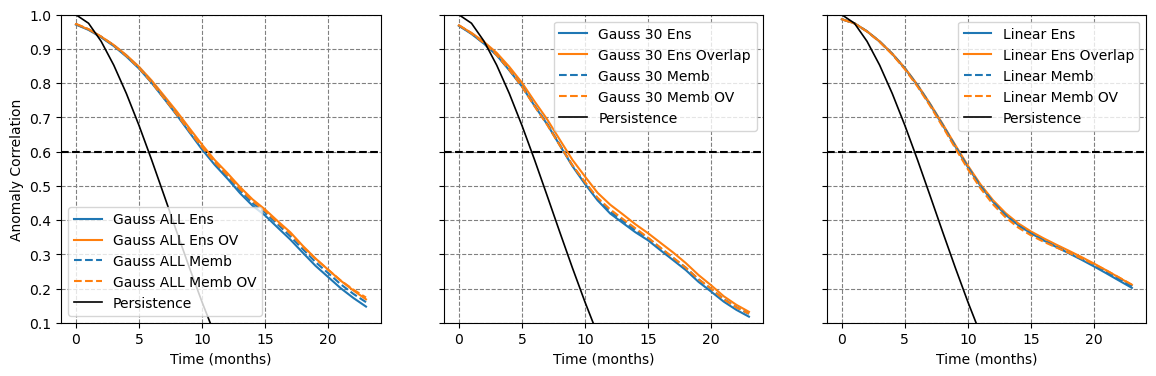

In [201]:
fig, ax = plt.subplots(nrows=1, ncols=3,sharey=True,figsize=(14,4))

xval=range(0,24)

ax[0].axhline(0.6, linestyle='--',color='black')
ax[0].set_xlabel('Time (months)')
ax[0].set_ylabel('Anomaly Correlation')
ax[0].set_ylim([0.1,1.0])
ax[0].set_title('',loc='left')
ax[0].plot(xval, np.mean(GaussALL_mean, axis=1), lw=1.5, label='Gauss ALL Ens')
ax[0].plot(xval, np.mean(GaussALL_mean_OV, axis=1), lw=1.5, label='Gauss ALL Ens OV')
ax[0].set_prop_cycle(None)
ax[0].plot(xval, np.mean(np.mean(GaussALL_ind, axis=1), axis=1), lw=1.5, label='Gauss ALL Memb', linestyle='dashed')
ax[0].plot(xval, np.mean(np.mean(GaussALL_ind_OV, axis=1), axis=1), lw=1.5, label='Gauss ALL Memb OV', linestyle='dashed')
ax[0].plot(xval, CORR_PERS, lw=1.2, label='Persistence', color='black')
ax[0].yaxis.grid(color='gray', linestyle='dashed')
ax[0].xaxis.grid(color='gray', linestyle='dashed')
ax[0].legend(loc='lower left')

ax[1].axhline(0.6, linestyle='--',color='black')
ax[1].set_xlabel('Time (months)')
ax[1].set_ylim([0.1,1.0])
ax[1].set_title('',loc='left')
ax[1].plot(xval, np.mean(Gauss30_mean, axis=1), lw=1.5, label='Gauss 30 Ens')
ax[1].plot(xval, np.mean(Gauss30_mean_OV, axis=1), lw=1.5, label='Gauss 30 Ens Overlap')
ax[1].set_prop_cycle(None)
ax[1].plot(xval, np.mean(np.mean(Gauss30_ind, axis=1), axis=1), lw=1.5, label='Gauss 30 Memb', linestyle='dashed')
ax[1].plot(xval, np.mean(np.mean(Gauss30_ind_OV, axis=1), axis=1), lw=1.5, label='Gauss 30 Memb OV', linestyle='dashed')
ax[1].plot(xval, CORR_PERS, lw=1.2, label='Persistence', color='black')
ax[1].yaxis.grid(color='gray', linestyle='dashed')
ax[1].xaxis.grid(color='gray', linestyle='dashed')
ax[1].legend(loc='upper right')

ax[2].axhline(0.6, linestyle='--',color='black')
ax[2].set_xlabel('Time (months)')
ax[2].set_ylim([0.1,1.0])
ax[2].set_title('',loc='left')
ax[2].plot(xval, np.mean(Poly_mean, axis=1), lw=1.5, label='Linear Ens')
ax[2].plot(xval, np.mean(Poly_mean_OV, axis=1), lw=1.5, label='Linear Ens Overlap')
ax[2].set_prop_cycle(None)
ax[2].plot(xval, np.mean(np.mean(Poly_ind, axis=1), axis=1), lw=1.5, label='Linear Memb', linestyle='dashed')
ax[2].plot(xval, np.mean(np.mean(Poly_ind_OV, axis=1), axis=1), lw=1.5, label='Linear Memb OV', linestyle='dashed')
ax[2].plot(xval, CORR_PERS, lw=1.2, label='Persistence', color='black')
ax[2].yaxis.grid(color='gray', linestyle='dashed')
ax[2].xaxis.grid(color='gray', linestyle='dashed')
ax[2].legend(loc='upper right')


plt.suptitle('',fontsize='xx-large')
labfile = 'due metodi forecasting MONTHS' + '.pdf'
#plt.savefig(labfile, orientation='landscape',  format='pdf')
plt.show() 

# 50 years

### Tools for the plots

In [22]:
import nc_time_axis

In [23]:
flabel = {'fontsize':14,'fontweight':'bold'}   #,'fontfamily':'Futura'
ftitle = {'fontsize':18,'fontweight':'bold'}   #,'fontfamily':'Futura',

In [24]:
from pylab import *

cmap = cm.get_cmap('plasma', 19)
color_list = [matplotlib.colors.rgb2hex(cmap(i)[:3]) for i in range(cmap.N)]

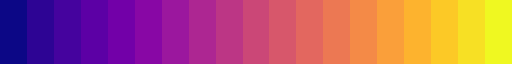

In [25]:
cmap   # First forecasts purple,    last forecasts yellow

### Data preparation

In [26]:
## Load EOFs
PCs=np.load('Processed_data/PCs_CESM_845SST_1000SSH.npy')
EOFs=np.load('Processed_data/EOFs_CESM_845SST_1000SSH.npy')

In [27]:
for_levels=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]
periods=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
periods_150=[0,1,2,3,4,5,6,7,8,9,10,11,12]
lead_times=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]

## ALL GAUSS

In [49]:
mean_av=np.zeros((24,13))
mean_ind=np.zeros((24,3,13))

RMSE_mean_av=np.zeros((24,13))
RMSE_mean_ind=np.zeros((24,3,13))

In [27]:
#Select EOFs
udat_sst=EOFs[:,0:845]

In [28]:
## Compute observations NON truncated to PCs
Xindex=X_tos.A.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))#[:-1]
Xindex

<xarray.DataArray (time: 24000)>
array([-0.07060546,  0.05650981,  0.28544343, ..., -0.9016017 ,
       -0.9271781 , -0.89309406], dtype=float32)
Coordinates:
  * time     (time) object 0001-02-01 00:00:00 ... 2001-01-01 00:00:00
    z_t      float32 500.0
    month    (time) int64 2 3 4 5 6 7 8 9 10 11 12 ... 3 4 5 6 7 8 9 10 11 12 1

In [29]:
tot_for_union=np.empty((3, 845, 24, 24000))
tot_for_union.fill(np.NaN)

In [33]:
for m in lead_times:
    for n in periods_150:
        tot_for_union[:,:,m, m + n*1800 : m + n*1800 +1776]=np.load(f'150 years testing/150 years testing-Forecasts 50/ALLEOFs_forecast_p{n}.npy')[:,0:845,m,:]

In [34]:
tot_for_union.shape

(3, 845, 24, 24000)

In [50]:
for m in periods_150:

    Xindex1=Xindex.isel(time=slice(0+150*12*m,150*12+150*12*m))
    X_tos1=X_tos.A[:,0+150*12*m:150*12+150*12*m]
    
    tot_for_union1=tot_for_union[:,:,:,0+150*12*m:150*12+150*12*m]
    print('Period ', m, '  forecast: ',m*2)
    
    for n in lead_times:
    
        lead=n
    
        # Compute average forecast
        av_for=np.nanmean(tot_for_union1, axis=0)
        av_for_geo_array=udat_sst @ av_for[0:845,lead,:]            
        av_for_geo = xr.full_like(X_tos1[:,:],0)
        av_for_geo.data=av_for_geo_array.real
        Avindex=av_for_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))

        #Correlation average forecast and observations
        mean_av[lead,m]=np.corrcoef(Xindex1[np.invert(np.isnan(Avindex))],Avindex[np.invert(np.isnan(Avindex))])[0,1]
        RMSE_mean_av[lead,m]=1-np.sqrt(np.square(np.subtract(Xindex1[np.invert(np.isnan(Avindex))],Avindex[np.invert(np.isnan(Avindex))])).mean()) / np.std(Xindex1[np.invert(np.isnan(Avindex))])
        print("Lead ", n, " ensemble mean correlation ",mean_av[lead,m])
    
        #Average correlation between individual forecast and observations
        for i in range(3):  
            phix_geo_array=udat_sst @ tot_for_union1[i,0:845,lead,:]  
            phix_geo = xr.full_like(X_tos1[:,:],0)
            phix_geo.data=phix_geo_array.real
            Phiindex=phix_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))

            mean_ind[lead,i,m]=np.corrcoef(Xindex1[np.invert(np.isnan(Phiindex))],Phiindex[np.invert(np.isnan(Phiindex))])[0,1]
            RMSE_mean_ind[lead,i,m]= 1-np.sqrt(np.square(np.subtract(Xindex1[np.invert(np.isnan(Phiindex))],Phiindex[np.invert(np.isnan(Phiindex))])).mean()) / np.std(Xindex1[np.invert(np.isnan(Phiindex))])
            
        av_corr=np.mean(mean_ind[lead,:,m], axis=0)
        print("Lead ", n, " ensemble member correlation ",av_corr)
        
        
'''        #Plot
        import nc_time_axis
    
        fig, ax = plt.subplots(1, 1, figsize=(16,3.5),squeeze=False)
    
        Xindex1.plot(label='Untruncated Obs',lw=1.2,color='gray')
    
        for i in range(3):  
            #Expand forecast to geographical domain
            phix_geo_array=udat_sst @ tot_for_union1[i,0:845,lead,:]  
            phix_geo = xr.full_like(X_tos1[:,:],0)
            phix_geo.data=phix_geo_array.real
    
            Phiindex=phix_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))
            Phiindex.plot(lw=0.5, color='red', alpha=0.4)
    
        Avindex.plot(label='Average forecast',lw=0.8,color='blue')

        plt.axhline(0,color='black',lw=0.5)
        plt.title(f'NINO3.4 forecast Lead {lead}',ftitle)
        plt.title(f'Gaussian Kernel',loc='left',**flabel)
        plt.xlabel(' ')
        plt.legend(loc='upper right')
        zmap.changebox(plt.gca(),'all',linewidth=1.5)
        #loctime = Xindex1.sel(time='1-JAN-2000').time.data
        cstr1 = f' Corr aver. for: {mean_av[lead,m]:>.2f}'
        cstr2 = f' Aver. corr of ind. for: {av_corr:>.2f}'
        loctime = Xindex1.isel(time=450).time.data
        plt.text(loctime,-2.1,cstr1)
        plt.text(loctime,-2.3,cstr2)
        #labfile =  f'{data_name}{case}_NINO3BANDA_{KK.kernel_choice}{tolone}.pdf'
        #plt.savefig(labfile, orientation='landscape',  format='pdf')
        plt.show()'''


Period  0   forecast:  0
Lead  0  ensemble mean correlation  0.9597519709977306
Lead  0  ensemble member correlation  0.9575844789410249
Lead  1  ensemble mean correlation  0.9443071471673717
Lead  1  ensemble member correlation  0.9387794251625894
Lead  2  ensemble mean correlation  0.9215118844560738
Lead  2  ensemble member correlation  0.9123183500752069
Lead  3  ensemble mean correlation  0.8942168526109802
Lead  3  ensemble member correlation  0.8827216887759656
Lead  4  ensemble mean correlation  0.8589054572585603
Lead  4  ensemble member correlation  0.842920039230224
Lead  5  ensemble mean correlation  0.8208379056125036
Lead  5  ensemble member correlation  0.7987707673915377
Lead  6  ensemble mean correlation  0.78094560336292
Lead  6  ensemble member correlation  0.7555314686168503
Lead  7  ensemble mean correlation  0.7391995596520093
Lead  7  ensemble member correlation  0.7075017119213686
Lead  8  ensemble mean correlation  0.6902008131676157
Lead  8  ensemble member co

"        #Plot\n        import nc_time_axis\n    \n        fig, ax = plt.subplots(1, 1, figsize=(16,3.5),squeeze=False)\n    \n        Xindex1.plot(label='Untruncated Obs',lw=1.2,color='gray')\n    \n        for i in range(3):  \n            #Expand forecast to geographical domain\n            phix_geo_array=udat_sst @ tot_for_union1[i,0:845,lead,:]  \n            phix_geo = xr.full_like(X_tos1[:,:],0)\n            phix_geo.data=phix_geo_array.real\n    \n            Phiindex=phix_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))\n            Phiindex.plot(lw=0.5, color='red', alpha=0.4)\n    \n        Avindex.plot(label='Average forecast',lw=0.8,color='blue')\n\n        plt.axhline(0,color='black',lw=0.5)\n        plt.title(f'NINO3.4 forecast Lead {lead}',ftitle)\n        plt.title(f'Gaussian Kernel',loc='left',**flabel)\n        plt.xlabel(' ')\n        plt.legend(loc='upper right')\n        zmap.changebox(plt.gca(),'all',linewidth=1.5)\n        #loctime =

## ALL GAUSS OV

In [28]:
mean_av=np.zeros((24,13))
mean_ind=np.zeros((24,5,13))

RMSE_mean_av=np.zeros((24,13))
RMSE_mean_ind=np.zeros((24,5,13))

In [29]:
#Select EOFs
udat_sst=EOFs[:,0:845]

In [30]:
## Compute observations NON truncated to PCs
Xindex=X_tos.A.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))#[:-1]
Xindex

<xarray.DataArray (time: 24000)>
array([-0.07060546,  0.05650981,  0.28544343, ..., -0.9016017 ,
       -0.9271781 , -0.89309406], dtype=float32)
Coordinates:
  * time     (time) object 0001-02-01 00:00:00 ... 2001-01-01 00:00:00
    z_t      float32 500.0
    month    (time) int64 2 3 4 5 6 7 8 9 10 11 12 ... 3 4 5 6 7 8 9 10 11 12 1

In [33]:
tot_for_union=np.empty((5, 845, 24, 24000))
tot_for_union.fill(np.NaN)

In [34]:
for m in lead_times:
    for n in periods_150:
        tot_for_union[0:3,:,m, m + n*1800 : m + n*1800 +1776]=np.load(f'150 years testing/150 years testing-Forecasts 50/ALLEOFs_forecast_p{n}.npy')[:,0:845,m,:]

In [45]:
for m in lead_times:
    for n in periods_150:
        tot_for_union[3:5,:,m, m + n*1800 : m + n*1800 +1776]=np.load(f'150 years testing/150 years testing-Forecasts 50/ALLEOFs_forecast_p{n}_OV.npy')[:,0:845,m,:]

In [46]:
for m in periods_150:

    Xindex1=Xindex.isel(time=slice(0+150*12*m,150*12+150*12*m))
    X_tos1=X_tos.A[:,0+150*12*m:150*12+150*12*m]
    
    tot_for_union1=tot_for_union[:,:,:,0+150*12*m:150*12+150*12*m]
    print('Period ', m, '  forecast: ',m*2)
    
    for n in lead_times:
    
        lead=n
    
        # Compute average forecast
        av_for=np.nanmean(tot_for_union1, axis=0)
        av_for_geo_array=udat_sst @ av_for[0:845,lead,:]            
        av_for_geo = xr.full_like(X_tos1[:,:],0)
        av_for_geo.data=av_for_geo_array.real
        Avindex=av_for_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))

        #Correlation average forecast and observations
        mean_av[lead,m]=np.corrcoef(Xindex1[np.invert(np.isnan(Avindex))],Avindex[np.invert(np.isnan(Avindex))])[0,1]
        RMSE_mean_av[lead,m]=1-np.sqrt(np.square(np.subtract(Xindex1[np.invert(np.isnan(Avindex))],Avindex[np.invert(np.isnan(Avindex))])).mean()) / np.std(Xindex1[np.invert(np.isnan(Avindex))])
        print("Lead ", n, " ensemble mean correlation ",mean_av[lead,m])
    
        #Average correlation between individual forecast and observations
        for i in range(5):  
            phix_geo_array=udat_sst @ tot_for_union1[i,0:845,lead,:]  
            phix_geo = xr.full_like(X_tos1[:,:],0)
            phix_geo.data=phix_geo_array.real
            Phiindex=phix_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))

            mean_ind[lead,i,m]=np.corrcoef(Xindex1[np.invert(np.isnan(Phiindex))],Phiindex[np.invert(np.isnan(Phiindex))])[0,1]
            RMSE_mean_ind[lead,i,m]= 1-np.sqrt(np.square(np.subtract(Xindex1[np.invert(np.isnan(Phiindex))],Phiindex[np.invert(np.isnan(Phiindex))])).mean()) / np.std(Xindex1[np.invert(np.isnan(Phiindex))])
            
        av_corr=np.mean(mean_ind[lead,:,m], axis=0)
        print("Lead ", n, " ensemble member correlation ",av_corr)
        
        
'''        #Plot
        import nc_time_axis
    
        fig, ax = plt.subplots(1, 1, figsize=(16,3.5),squeeze=False)
    
        Xindex1.plot(label='Untruncated Obs',lw=1.2,color='gray')
    
        for i in range(3):  
            #Expand forecast to geographical domain
            phix_geo_array=udat_sst @ tot_for_union1[i,0:845,lead,:]  
            phix_geo = xr.full_like(X_tos1[:,:],0)
            phix_geo.data=phix_geo_array.real
    
            Phiindex=phix_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))
            Phiindex.plot(lw=0.5, color='red', alpha=0.4)
    
        Avindex.plot(label='Average forecast',lw=0.8,color='blue')

        plt.axhline(0,color='black',lw=0.5)
        plt.title(f'NINO3.4 forecast Lead {lead}',ftitle)
        plt.title(f'Gaussian Kernel',loc='left',**flabel)
        plt.xlabel(' ')
        plt.legend(loc='upper right')
        zmap.changebox(plt.gca(),'all',linewidth=1.5)
        #loctime = Xindex1.sel(time='1-JAN-2000').time.data
        cstr1 = f' Corr aver. for: {mean_av[lead,m]:>.2f}'
        cstr2 = f' Aver. corr of ind. for: {av_corr:>.2f}'
        loctime = Xindex1.isel(time=450).time.data
        plt.text(loctime,-2.1,cstr1)
        plt.text(loctime,-2.3,cstr2)
        #labfile =  f'{data_name}{case}_NINO3BANDA_{KK.kernel_choice}{tolone}.pdf'
        #plt.savefig(labfile, orientation='landscape',  format='pdf')
        plt.show()'''


Period  0   forecast:  0
Lead  0  ensemble mean correlation  0.9589615934678226
Lead  0  ensemble member correlation  0.9561617459683799
Lead  1  ensemble mean correlation  0.9419408571674414
Lead  1  ensemble member correlation  0.935185370469178
Lead  2  ensemble mean correlation  0.9191063501953899
Lead  2  ensemble member correlation  0.9087501320445679
Lead  3  ensemble mean correlation  0.8935958576788555
Lead  3  ensemble member correlation  0.8803402929435009
Lead  4  ensemble mean correlation  0.8594432967275176
Lead  4  ensemble member correlation  0.8418262578580131
Lead  5  ensemble mean correlation  0.8207029404149465
Lead  5  ensemble member correlation  0.796939620778267
Lead  6  ensemble mean correlation  0.7814279171845867
Lead  6  ensemble member correlation  0.7539038847828385
Lead  7  ensemble mean correlation  0.7414312857477323
Lead  7  ensemble member correlation  0.7078042184833457
Lead  8  ensemble mean correlation  0.6969486345293892
Lead  8  ensemble member c

"        #Plot\n        import nc_time_axis\n    \n        fig, ax = plt.subplots(1, 1, figsize=(16,3.5),squeeze=False)\n    \n        Xindex1.plot(label='Untruncated Obs',lw=1.2,color='gray')\n    \n        for i in range(3):  \n            #Expand forecast to geographical domain\n            phix_geo_array=udat_sst @ tot_for_union1[i,0:845,lead,:]  \n            phix_geo = xr.full_like(X_tos1[:,:],0)\n            phix_geo.data=phix_geo_array.real\n    \n            Phiindex=phix_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))\n            Phiindex.plot(lw=0.5, color='red', alpha=0.4)\n    \n        Avindex.plot(label='Average forecast',lw=0.8,color='blue')\n\n        plt.axhline(0,color='black',lw=0.5)\n        plt.title(f'NINO3.4 forecast Lead {lead}',ftitle)\n        plt.title(f'Gaussian Kernel',loc='left',**flabel)\n        plt.xlabel(' ')\n        plt.legend(loc='upper right')\n        zmap.changebox(plt.gca(),'all',linewidth=1.5)\n        #loctime =

In [47]:
np.save('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEAN_CORR_GAUSALL_50_OV', mean_av, allow_pickle=True, fix_imports=True)
np.save('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEMBERS_CORR_GAUSALL_50_OV', mean_ind, allow_pickle=True, fix_imports=True)
np.save('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEAN_RMSE_GAUSALL_50_OV', RMSE_mean_av, allow_pickle=True, fix_imports=True)
np.save('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEMBERS_RMSE_GAUSALL_50_OV', RMSE_mean_ind, allow_pickle=True, fix_imports=True)

In [48]:
np.save('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEAN_CORR_GAUSALL_50_OV', mean_av, allow_pickle=True, fix_imports=True)
np.save('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEMBERS_CORR_GAUSALL_50_OV', mean_ind, allow_pickle=True, fix_imports=True)
np.save('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEAN_RMSE_GAUSALL_50_OV', RMSE_mean_av, allow_pickle=True, fix_imports=True)
np.save('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEMBERS_RMSE_GAUSALL_50_OV', RMSE_mean_ind, allow_pickle=True, fix_imports=True)

## 30 GAUSS

In [54]:
mean_av=np.zeros((24,13))
mean_ind=np.zeros((24,3,13))

RMSE_mean_av=np.zeros((24,13))
RMSE_mean_ind=np.zeros((24,3,13))

In [55]:
#Select EOFs
udat_sst=EOFs[:,0:20]

In [56]:
## Compute observations NON truncated to PCs
Xindex=X_tos.A.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))#[:-1]
Xindex

<xarray.DataArray (time: 24000)>
array([-0.07060546,  0.05650981,  0.28544343, ..., -0.9016017 ,
       -0.9271781 , -0.89309406], dtype=float32)
Coordinates:
  * time     (time) object 0001-02-01 00:00:00 ... 2001-01-01 00:00:00
    z_t      float32 500.0
    month    (time) int64 2 3 4 5 6 7 8 9 10 11 12 ... 3 4 5 6 7 8 9 10 11 12 1

In [59]:
tot_for_union=np.empty((3, 20, 24, 24000))
tot_for_union.fill(np.NaN)

In [60]:
for m in lead_times:
    for n in periods_150:
        tot_for_union[:,:,m, m + n*1800 : m + n*1800 +1776]=np.load(f'150 years testing/150 years testing-Forecasts 50/30EOFs_forecast_p{n}.npy')[:,0:20,m,:]

In [61]:
for m in periods_150:

    Xindex1=Xindex.isel(time=slice(0+150*12*m,150*12+150*12*m))
    X_tos1=X_tos.A[:,0+150*12*m:150*12+150*12*m]
    
    tot_for_union1=tot_for_union[:,:,:,0+150*12*m:150*12+150*12*m]
    print('Period ', m, '  forecast: ',m*2)
    
    for n in lead_times:
    
        lead=n
    
        # Compute average forecast
        av_for=np.nanmean(tot_for_union1, axis=0)
        av_for_geo_array=udat_sst @ av_for[0:20,lead,:]            
        av_for_geo = xr.full_like(X_tos1[:,:],0)
        av_for_geo.data=av_for_geo_array.real
        Avindex=av_for_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))

        #Correlation average forecast and observations
        mean_av[lead,m]=np.corrcoef(Xindex1[np.invert(np.isnan(Avindex))],Avindex[np.invert(np.isnan(Avindex))])[0,1]
        RMSE_mean_av[lead,m]=1-np.sqrt(np.square(np.subtract(Xindex1[np.invert(np.isnan(Avindex))],Avindex[np.invert(np.isnan(Avindex))])).mean()) / np.std(Xindex1[np.invert(np.isnan(Avindex))])
        print("Lead ", n, " ensemble mean correlation ",mean_av[lead,m])
    
        #Average correlation between individual forecast and observations
        for i in range(3):  
            phix_geo_array=udat_sst @ tot_for_union1[i,0:20,lead,:]  
            phix_geo = xr.full_like(X_tos1[:,:],0)
            phix_geo.data=phix_geo_array.real
            Phiindex=phix_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))

            mean_ind[lead,i,m]=np.corrcoef(Xindex1[np.invert(np.isnan(Phiindex))],Phiindex[np.invert(np.isnan(Phiindex))])[0,1]
            RMSE_mean_ind[lead,i,m]= 1-np.sqrt(np.square(np.subtract(Xindex1[np.invert(np.isnan(Phiindex))],Phiindex[np.invert(np.isnan(Phiindex))])).mean()) / np.std(Xindex1[np.invert(np.isnan(Phiindex))])
            
        av_corr=np.mean(mean_ind[lead,:,m], axis=0)
        print("Lead ", n, " ensemble member correlation ",av_corr)
        
        
'''        #Plot
        import nc_time_axis
    
        fig, ax = plt.subplots(1, 1, figsize=(16,3.5),squeeze=False)
    
        Xindex1.plot(label='Untruncated Obs',lw=1.2,color='gray')
    
        for i in range(3):  
            #Expand forecast to geographical domain
            phix_geo_array=udat_sst @ tot_for_union1[i,0:20,lead,:]  
            phix_geo = xr.full_like(X_tos1[:,:],0)
            phix_geo.data=phix_geo_array.real
    
            Phiindex=phix_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))
            Phiindex.plot(lw=0.5, color='red', alpha=0.4)
    
        Avindex.plot(label='Average forecast',lw=0.8,color='blue')

        plt.axhline(0,color='black',lw=0.5)
        plt.title(f'NINO3.4 forecast Lead {lead}',ftitle)
        plt.title(f'Gaussian Kernel',loc='left',**flabel)
        plt.xlabel(' ')
        plt.legend(loc='upper right')
        zmap.changebox(plt.gca(),'all',linewidth=1.5)
        #loctime = Xindex1.sel(time='1-JAN-2000').time.data
        cstr1 = f' Corr aver. for: {mean_av[lead,m]:>.2f}'
        cstr2 = f' Aver. corr of ind. for: {av_corr:>.2f}'
        loctime = Xindex1.isel(time=450).time.data
        plt.text(loctime,-2.1,cstr1)
        plt.text(loctime,-2.3,cstr2)
        #labfile =  f'{data_name}{case}_NINO3BANDA_{KK.kernel_choice}{tolone}.pdf'
        #plt.savefig(labfile, orientation='landscape',  format='pdf')
        plt.show()'''


Period  0   forecast:  0
Lead  0  ensemble mean correlation  0.9587983626629136
Lead  0  ensemble member correlation  0.956445587765736
Lead  1  ensemble mean correlation  0.9398797121795565
Lead  1  ensemble member correlation  0.9278320854671662
Lead  2  ensemble mean correlation  0.9115256271476494
Lead  2  ensemble member correlation  0.8903205514443004
Lead  3  ensemble mean correlation  0.8816627689434949
Lead  3  ensemble member correlation  0.8572332521656286
Lead  4  ensemble mean correlation  0.8350710916911086
Lead  4  ensemble member correlation  0.8016370866420717
Lead  5  ensemble mean correlation  0.7896750738989908
Lead  5  ensemble member correlation  0.7432477082822905
Lead  6  ensemble mean correlation  0.7358716326947454
Lead  6  ensemble member correlation  0.6851247929367515
Lead  7  ensemble mean correlation  0.6872959325103335
Lead  7  ensemble member correlation  0.6284920716726499
Lead  8  ensemble mean correlation  0.6308068064710128
Lead  8  ensemble member 

"        #Plot\n        import nc_time_axis\n    \n        fig, ax = plt.subplots(1, 1, figsize=(16,3.5),squeeze=False)\n    \n        Xindex1.plot(label='Untruncated Obs',lw=1.2,color='gray')\n    \n        for i in range(3):  \n            #Expand forecast to geographical domain\n            phix_geo_array=udat_sst @ tot_for_union1[i,0:20,lead,:]  \n            phix_geo = xr.full_like(X_tos1[:,:],0)\n            phix_geo.data=phix_geo_array.real\n    \n            Phiindex=phix_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))\n            Phiindex.plot(lw=0.5, color='red', alpha=0.4)\n    \n        Avindex.plot(label='Average forecast',lw=0.8,color='blue')\n\n        plt.axhline(0,color='black',lw=0.5)\n        plt.title(f'NINO3.4 forecast Lead {lead}',ftitle)\n        plt.title(f'Gaussian Kernel',loc='left',**flabel)\n        plt.xlabel(' ')\n        plt.legend(loc='upper right')\n        zmap.changebox(plt.gca(),'all',linewidth=1.5)\n        #loctime = 

In [62]:
np.save('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEAN_CORR_GAUSS30_50', mean_av, allow_pickle=True, fix_imports=True)
np.save('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEMBERS_CORR_GAUSS30_50', mean_ind, allow_pickle=True, fix_imports=True)
np.save('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEAN_RMSE_GAUSS30_50', RMSE_mean_av, allow_pickle=True, fix_imports=True)
np.save('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEMBERS_RMSE_GAUSS30_50', RMSE_mean_ind, allow_pickle=True, fix_imports=True)

## 30 GAUSS

In [52]:
mean_av=np.zeros((24,13))
mean_ind=np.zeros((24,5,13))

RMSE_mean_av=np.zeros((24,13))
RMSE_mean_ind=np.zeros((24,5,13))

In [53]:
#Select EOFs
udat_sst=EOFs[:,0:20]

In [54]:
## Compute observations NON truncated to PCs
Xindex=X_tos.A.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))#[:-1]
Xindex

<xarray.DataArray (time: 24000)>
array([-0.07060546,  0.05650981,  0.28544343, ..., -0.9016017 ,
       -0.9271781 , -0.89309406], dtype=float32)
Coordinates:
  * time     (time) object 0001-02-01 00:00:00 ... 2001-01-01 00:00:00
    z_t      float32 500.0
    month    (time) int64 2 3 4 5 6 7 8 9 10 11 12 ... 3 4 5 6 7 8 9 10 11 12 1

In [55]:
tot_for_union=np.empty((5, 20, 24, 24000))
tot_for_union.fill(np.NaN)

In [57]:
for m in lead_times:
    for n in periods_150:
        tot_for_union[0:3,:,m, m + n*1800 : m + n*1800 +1776]=np.load(f'150 years testing/150 years testing-Forecasts 50/30EOFs_forecast_p{n}.npy')[:,0:20,m,:]

In [59]:
for m in lead_times:
    for n in periods_150:
        tot_for_union[3:5,:,m, m + n*1800 : m + n*1800 +1776]=np.load(f'150 years testing/150 years testing-Forecasts 50/30EOFs_forecast_p{n}_OV.npy')[:,0:20,m,:]

In [60]:
for m in periods_150:

    Xindex1=Xindex.isel(time=slice(0+150*12*m,150*12+150*12*m))
    X_tos1=X_tos.A[:,0+150*12*m:150*12+150*12*m]
    
    tot_for_union1=tot_for_union[:,:,:,0+150*12*m:150*12+150*12*m]
    print('Period ', m, '  forecast: ',m*2)
    
    for n in lead_times:
    
        lead=n
    
        # Compute average forecast
        av_for=np.nanmean(tot_for_union1, axis=0)
        av_for_geo_array=udat_sst @ av_for[0:20,lead,:]            
        av_for_geo = xr.full_like(X_tos1[:,:],0)
        av_for_geo.data=av_for_geo_array.real
        Avindex=av_for_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))

        #Correlation average forecast and observations
        mean_av[lead,m]=np.corrcoef(Xindex1[np.invert(np.isnan(Avindex))],Avindex[np.invert(np.isnan(Avindex))])[0,1]
        RMSE_mean_av[lead,m]=1-np.sqrt(np.square(np.subtract(Xindex1[np.invert(np.isnan(Avindex))],Avindex[np.invert(np.isnan(Avindex))])).mean()) / np.std(Xindex1[np.invert(np.isnan(Avindex))])
        print("Lead ", n, " ensemble mean correlation ",mean_av[lead,m])
    
        #Average correlation between individual forecast and observations
        for i in range(5):  
            phix_geo_array=udat_sst @ tot_for_union1[i,0:20,lead,:]  
            phix_geo = xr.full_like(X_tos1[:,:],0)
            phix_geo.data=phix_geo_array.real
            Phiindex=phix_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))

            mean_ind[lead,i,m]=np.corrcoef(Xindex1[np.invert(np.isnan(Phiindex))],Phiindex[np.invert(np.isnan(Phiindex))])[0,1]
            RMSE_mean_ind[lead,i,m]= 1-np.sqrt(np.square(np.subtract(Xindex1[np.invert(np.isnan(Phiindex))],Phiindex[np.invert(np.isnan(Phiindex))])).mean()) / np.std(Xindex1[np.invert(np.isnan(Phiindex))])
            
        av_corr=np.mean(mean_ind[lead,:,m], axis=0)
        print("Lead ", n, " ensemble member correlation ",av_corr)
        
        
'''        #Plot
        import nc_time_axis
    
        fig, ax = plt.subplots(1, 1, figsize=(16,3.5),squeeze=False)
    
        Xindex1.plot(label='Untruncated Obs',lw=1.2,color='gray')
    
        for i in range(3):  
            #Expand forecast to geographical domain
            phix_geo_array=udat_sst @ tot_for_union1[i,0:20,lead,:]  
            phix_geo = xr.full_like(X_tos1[:,:],0)
            phix_geo.data=phix_geo_array.real
    
            Phiindex=phix_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))
            Phiindex.plot(lw=0.5, color='red', alpha=0.4)
    
        Avindex.plot(label='Average forecast',lw=0.8,color='blue')

        plt.axhline(0,color='black',lw=0.5)
        plt.title(f'NINO3.4 forecast Lead {lead}',ftitle)
        plt.title(f'Gaussian Kernel',loc='left',**flabel)
        plt.xlabel(' ')
        plt.legend(loc='upper right')
        zmap.changebox(plt.gca(),'all',linewidth=1.5)
        #loctime = Xindex1.sel(time='1-JAN-2000').time.data
        cstr1 = f' Corr aver. for: {mean_av[lead,m]:>.2f}'
        cstr2 = f' Aver. corr of ind. for: {av_corr:>.2f}'
        loctime = Xindex1.isel(time=450).time.data
        plt.text(loctime,-2.1,cstr1)
        plt.text(loctime,-2.3,cstr2)
        #labfile =  f'{data_name}{case}_NINO3BANDA_{KK.kernel_choice}{tolone}.pdf'
        #plt.savefig(labfile, orientation='landscape',  format='pdf')
        plt.show()'''


Period  0   forecast:  0
Lead  0  ensemble mean correlation  0.958623997664858
Lead  0  ensemble member correlation  0.9560161321600409
Lead  1  ensemble mean correlation  0.9384003827981794
Lead  1  ensemble member correlation  0.9241399455980094
Lead  2  ensemble mean correlation  0.9104189859124299
Lead  2  ensemble member correlation  0.8851307977602781
Lead  3  ensemble mean correlation  0.8811512456004593
Lead  3  ensemble member correlation  0.8510071190521507
Lead  4  ensemble mean correlation  0.8341798642432735
Lead  4  ensemble member correlation  0.7954895528935797
Lead  5  ensemble mean correlation  0.7885328933430836
Lead  5  ensemble member correlation  0.7359304705411659
Lead  6  ensemble mean correlation  0.742692649995604
Lead  6  ensemble member correlation  0.6851879249855721
Lead  7  ensemble mean correlation  0.6973380891655333
Lead  7  ensemble member correlation  0.6298703577161632
Lead  8  ensemble mean correlation  0.6428800238608903
Lead  8  ensemble member c

"        #Plot\n        import nc_time_axis\n    \n        fig, ax = plt.subplots(1, 1, figsize=(16,3.5),squeeze=False)\n    \n        Xindex1.plot(label='Untruncated Obs',lw=1.2,color='gray')\n    \n        for i in range(3):  \n            #Expand forecast to geographical domain\n            phix_geo_array=udat_sst @ tot_for_union1[i,0:20,lead,:]  \n            phix_geo = xr.full_like(X_tos1[:,:],0)\n            phix_geo.data=phix_geo_array.real\n    \n            Phiindex=phix_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))\n            Phiindex.plot(lw=0.5, color='red', alpha=0.4)\n    \n        Avindex.plot(label='Average forecast',lw=0.8,color='blue')\n\n        plt.axhline(0,color='black',lw=0.5)\n        plt.title(f'NINO3.4 forecast Lead {lead}',ftitle)\n        plt.title(f'Gaussian Kernel',loc='left',**flabel)\n        plt.xlabel(' ')\n        plt.legend(loc='upper right')\n        zmap.changebox(plt.gca(),'all',linewidth=1.5)\n        #loctime = 

In [61]:
np.save('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEAN_CORR_GAUSS30_50_OV', mean_av, allow_pickle=True, fix_imports=True)
np.save('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEMBERS_CORR_GAUSS30_50_OV', mean_ind, allow_pickle=True, fix_imports=True)
np.save('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEAN_RMSE_GAUSS30_50_OV', RMSE_mean_av, allow_pickle=True, fix_imports=True)
np.save('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEMBERS_RMSE_GAUSS30_50_OV', RMSE_mean_ind, allow_pickle=True, fix_imports=True)

## 30 POLY

In [63]:
mean_av=np.zeros((24,13))
mean_ind=np.zeros((24,3,13))

RMSE_mean_av=np.zeros((24,13))
RMSE_mean_ind=np.zeros((24,3,13))

In [64]:
#Select EOFs
udat_sst=EOFs[:,0:20]

In [65]:
## Compute observations NON truncated to PCs
Xindex=X_tos.A.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))#[:-1]
Xindex

<xarray.DataArray (time: 24000)>
array([-0.07060546,  0.05650981,  0.28544343, ..., -0.9016017 ,
       -0.9271781 , -0.89309406], dtype=float32)
Coordinates:
  * time     (time) object 0001-02-01 00:00:00 ... 2001-01-01 00:00:00
    z_t      float32 500.0
    month    (time) int64 2 3 4 5 6 7 8 9 10 11 12 ... 3 4 5 6 7 8 9 10 11 12 1

In [66]:
tot_for_union=np.empty((3, 20, 24, 24000))
tot_for_union.fill(np.NaN)

In [77]:
for m in lead_times:
    for n in periods_150:
        tot_for_union[:,:,m, m + n*1800 : m + n*1800 +1776]=np.load(f'150 years testing/150 years testing-Forecasts 50/POLY_forecast_p{n}.npy')[:,0:20,m,:]

In [79]:
for m in periods_150:

    Xindex1=Xindex.isel(time=slice(0+150*12*m,150*12+150*12*m))
    X_tos1=X_tos.A[:,0+150*12*m:150*12+150*12*m]
    
    tot_for_union1=tot_for_union[:,:,:,0+150*12*m:150*12+150*12*m]
    print('Period ', m, '  forecast: ',m*2)
    
    for n in lead_times:
    
        lead=n
    
        # Compute average forecast
        av_for=np.nanmean(tot_for_union1, axis=0)
        av_for_geo_array=udat_sst @ av_for[0:20,lead,:]            
        av_for_geo = xr.full_like(X_tos1[:,:],0)
        av_for_geo.data=av_for_geo_array.real
        Avindex=av_for_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))

        #Correlation average forecast and observations
        mean_av[lead,m]=np.corrcoef(Xindex1[np.invert(np.isnan(Avindex))],Avindex[np.invert(np.isnan(Avindex))])[0,1]
        RMSE_mean_av[lead,m]=1-np.sqrt(np.square(np.subtract(Xindex1[np.invert(np.isnan(Avindex))],Avindex[np.invert(np.isnan(Avindex))])).mean()) / np.std(Xindex1[np.invert(np.isnan(Avindex))])
        print("Lead ", n, " ensemble mean correlation ",mean_av[lead,m])
    
        #Average correlation between individual forecast and observations
        for i in range(3):  
            phix_geo_array=udat_sst @ tot_for_union1[i,0:20,lead,:]  
            phix_geo = xr.full_like(X_tos1[:,:],0)
            phix_geo.data=phix_geo_array.real
            Phiindex=phix_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))

            mean_ind[lead,i,m]=np.corrcoef(Xindex1[np.invert(np.isnan(Phiindex))],Phiindex[np.invert(np.isnan(Phiindex))])[0,1]
            RMSE_mean_ind[lead,i,m]= 1-np.sqrt(np.square(np.subtract(Xindex1[np.invert(np.isnan(Phiindex))],Phiindex[np.invert(np.isnan(Phiindex))])).mean()) / np.std(Xindex1[np.invert(np.isnan(Phiindex))])
            
        av_corr=np.mean(mean_ind[lead,:,m], axis=0)
        print("Lead ", n, " ensemble member correlation ",av_corr)
        
        
'''        #Plot
        import nc_time_axis
    
        fig, ax = plt.subplots(1, 1, figsize=(16,3.5),squeeze=False)
    
        Xindex1.plot(label='Untruncated Obs',lw=1.2,color='gray')
    
        for i in range(3):  
            #Expand forecast to geographical domain
            phix_geo_array=udat_sst @ tot_for_union1[i,0:20,lead,:]  
            phix_geo = xr.full_like(X_tos1[:,:],0)
            phix_geo.data=phix_geo_array.real
    
            Phiindex=phix_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))
            Phiindex.plot(lw=0.5, color='red', alpha=0.4)
    
        Avindex.plot(label='Average forecast',lw=0.8,color='blue')

        plt.axhline(0,color='black',lw=0.5)
        plt.title(f'NINO3.4 forecast Lead {lead}',ftitle)
        plt.title(f'Gaussian Kernel',loc='left',**flabel)
        plt.xlabel(' ')
        plt.legend(loc='upper right')
        zmap.changebox(plt.gca(),'all',linewidth=1.5)
        #loctime = Xindex1.sel(time='1-JAN-2000').time.data
        cstr1 = f' Corr aver. for: {mean_av[lead,m]:>.2f}'
        cstr2 = f' Aver. corr of ind. for: {av_corr:>.2f}'
        loctime = Xindex1.isel(time=450).time.data
        plt.text(loctime,-2.1,cstr1)
        plt.text(loctime,-2.3,cstr2)
        #labfile =  f'{data_name}{case}_NINO3BANDA_{KK.kernel_choice}{tolone}.pdf'
        #plt.savefig(labfile, orientation='landscape',  format='pdf')
        plt.show()'''


Period  0   forecast:  0
Lead  0  ensemble mean correlation  0.9868577389493078
Lead  0  ensemble member correlation  0.986883252861423
Lead  1  ensemble mean correlation  0.9743575717611367
Lead  1  ensemble member correlation  0.9738407881442902
Lead  2  ensemble mean correlation  0.9498148608385347
Lead  2  ensemble member correlation  0.9481385899194749
Lead  3  ensemble mean correlation  0.9189938475972619
Lead  3  ensemble member correlation  0.9157159562336913
Lead  4  ensemble mean correlation  0.8809298841968422
Lead  4  ensemble member correlation  0.8755147149186522
Lead  5  ensemble mean correlation  0.8350412561898253
Lead  5  ensemble member correlation  0.8268402479623375
Lead  6  ensemble mean correlation  0.7813490866880881
Lead  6  ensemble member correlation  0.7695959901575877
Lead  7  ensemble mean correlation  0.7210440151316388
Lead  7  ensemble member correlation  0.7052387436114328
Lead  8  ensemble mean correlation  0.6557649021310205
Lead  8  ensemble member 

"        #Plot\n        import nc_time_axis\n    \n        fig, ax = plt.subplots(1, 1, figsize=(16,3.5),squeeze=False)\n    \n        Xindex1.plot(label='Untruncated Obs',lw=1.2,color='gray')\n    \n        for i in range(3):  \n            #Expand forecast to geographical domain\n            phix_geo_array=udat_sst @ tot_for_union1[i,0:20,lead,:]  \n            phix_geo = xr.full_like(X_tos1[:,:],0)\n            phix_geo.data=phix_geo_array.real\n    \n            Phiindex=phix_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))\n            Phiindex.plot(lw=0.5, color='red', alpha=0.4)\n    \n        Avindex.plot(label='Average forecast',lw=0.8,color='blue')\n\n        plt.axhline(0,color='black',lw=0.5)\n        plt.title(f'NINO3.4 forecast Lead {lead}',ftitle)\n        plt.title(f'Gaussian Kernel',loc='left',**flabel)\n        plt.xlabel(' ')\n        plt.legend(loc='upper right')\n        zmap.changebox(plt.gca(),'all',linewidth=1.5)\n        #loctime = 

In [80]:
np.save('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEAN_CORR_POLY_50', mean_av, allow_pickle=True, fix_imports=True)
np.save('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEMBERS_CORR_POLY_50', mean_ind, allow_pickle=True, fix_imports=True)
np.save('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEAN_RMSE_POLY_50', RMSE_mean_av, allow_pickle=True, fix_imports=True)
np.save('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEMBERS_RMSE_POLY_50', RMSE_mean_ind, allow_pickle=True, fix_imports=True)

## 30 POLY

In [62]:
mean_av=np.zeros((24,13))
mean_ind=np.zeros((24,5,13))

RMSE_mean_av=np.zeros((24,13))
RMSE_mean_ind=np.zeros((24,5,13))

In [63]:
#Select EOFs
udat_sst=EOFs[:,0:20]

In [64]:
## Compute observations NON truncated to PCs
Xindex=X_tos.A.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))#[:-1]
Xindex

<xarray.DataArray (time: 24000)>
array([-0.07060546,  0.05650981,  0.28544343, ..., -0.9016017 ,
       -0.9271781 , -0.89309406], dtype=float32)
Coordinates:
  * time     (time) object 0001-02-01 00:00:00 ... 2001-01-01 00:00:00
    z_t      float32 500.0
    month    (time) int64 2 3 4 5 6 7 8 9 10 11 12 ... 3 4 5 6 7 8 9 10 11 12 1

In [66]:
tot_for_union=np.empty((5, 20, 24, 24000))
tot_for_union.fill(np.NaN)

In [67]:
for m in lead_times:
    for n in periods_150:
        tot_for_union[0:3,:,m, m + n*1800 : m + n*1800 +1776]=np.load(f'150 years testing/150 years testing-Forecasts 50/POLY_forecast_p{n}.npy')[:,0:20,m,:]

In [69]:
for m in lead_times:
    for n in periods_150:
        tot_for_union[3:5,:,m, m + n*1800 : m + n*1800 +1776]=np.load(f'150 years testing/150 years testing-Forecasts 50/POLY_forecast_p{n}_OV.npy')[:,0:20,m,:]

In [70]:
for m in periods_150:

    Xindex1=Xindex.isel(time=slice(0+150*12*m,150*12+150*12*m))
    X_tos1=X_tos.A[:,0+150*12*m:150*12+150*12*m]
    
    tot_for_union1=tot_for_union[:,:,:,0+150*12*m:150*12+150*12*m]
    print('Period ', m, '  forecast: ',m*2)
    
    for n in lead_times:
    
        lead=n
    
        # Compute average forecast
        av_for=np.nanmean(tot_for_union1, axis=0)
        av_for_geo_array=udat_sst @ av_for[0:20,lead,:]            
        av_for_geo = xr.full_like(X_tos1[:,:],0)
        av_for_geo.data=av_for_geo_array.real
        Avindex=av_for_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))

        #Correlation average forecast and observations
        mean_av[lead,m]=np.corrcoef(Xindex1[np.invert(np.isnan(Avindex))],Avindex[np.invert(np.isnan(Avindex))])[0,1]
        RMSE_mean_av[lead,m]=1-np.sqrt(np.square(np.subtract(Xindex1[np.invert(np.isnan(Avindex))],Avindex[np.invert(np.isnan(Avindex))])).mean()) / np.std(Xindex1[np.invert(np.isnan(Avindex))])
        print("Lead ", n, " ensemble mean correlation ",mean_av[lead,m])
    
        #Average correlation between individual forecast and observations
        for i in range(5):  
            phix_geo_array=udat_sst @ tot_for_union1[i,0:20,lead,:]  
            phix_geo = xr.full_like(X_tos1[:,:],0)
            phix_geo.data=phix_geo_array.real
            Phiindex=phix_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))

            mean_ind[lead,i,m]=np.corrcoef(Xindex1[np.invert(np.isnan(Phiindex))],Phiindex[np.invert(np.isnan(Phiindex))])[0,1]
            RMSE_mean_ind[lead,i,m]= 1-np.sqrt(np.square(np.subtract(Xindex1[np.invert(np.isnan(Phiindex))],Phiindex[np.invert(np.isnan(Phiindex))])).mean()) / np.std(Xindex1[np.invert(np.isnan(Phiindex))])
            
        av_corr=np.mean(mean_ind[lead,:,m], axis=0)
        print("Lead ", n, " ensemble member correlation ",av_corr)
        
        
'''        #Plot
        import nc_time_axis
    
        fig, ax = plt.subplots(1, 1, figsize=(16,3.5),squeeze=False)
    
        Xindex1.plot(label='Untruncated Obs',lw=1.2,color='gray')
    
        for i in range(3):  
            #Expand forecast to geographical domain
            phix_geo_array=udat_sst @ tot_for_union1[i,0:20,lead,:]  
            phix_geo = xr.full_like(X_tos1[:,:],0)
            phix_geo.data=phix_geo_array.real
    
            Phiindex=phix_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))
            Phiindex.plot(lw=0.5, color='red', alpha=0.4)
    
        Avindex.plot(label='Average forecast',lw=0.8,color='blue')

        plt.axhline(0,color='black',lw=0.5)
        plt.title(f'NINO3.4 forecast Lead {lead}',ftitle)
        plt.title(f'Gaussian Kernel',loc='left',**flabel)
        plt.xlabel(' ')
        plt.legend(loc='upper right')
        zmap.changebox(plt.gca(),'all',linewidth=1.5)
        #loctime = Xindex1.sel(time='1-JAN-2000').time.data
        cstr1 = f' Corr aver. for: {mean_av[lead,m]:>.2f}'
        cstr2 = f' Aver. corr of ind. for: {av_corr:>.2f}'
        loctime = Xindex1.isel(time=450).time.data
        plt.text(loctime,-2.1,cstr1)
        plt.text(loctime,-2.3,cstr2)
        #labfile =  f'{data_name}{case}_NINO3BANDA_{KK.kernel_choice}{tolone}.pdf'
        #plt.savefig(labfile, orientation='landscape',  format='pdf')
        plt.show()'''


Period  0   forecast:  0
Lead  0  ensemble mean correlation  0.9868577389493078
Lead  0  ensemble member correlation  0.9869082341564696
Lead  1  ensemble mean correlation  0.9745323611170889
Lead  1  ensemble member correlation  0.9742319930074823
Lead  2  ensemble mean correlation  0.9504093772258523
Lead  2  ensemble member correlation  0.9492009282625802
Lead  3  ensemble mean correlation  0.9204458968540429
Lead  3  ensemble member correlation  0.9179295083874127
Lead  4  ensemble mean correlation  0.8843183431151378
Lead  4  ensemble member correlation  0.8797269085106197
Lead  5  ensemble mean correlation  0.8417712026322884
Lead  5  ensemble member correlation  0.8343121941056593
Lead  6  ensemble mean correlation  0.7925566335386465
Lead  6  ensemble member correlation  0.7816376843055087
Lead  7  ensemble mean correlation  0.7374079276731521
Lead  7  ensemble member correlation  0.7227231061524557
Lead  8  ensemble mean correlation  0.6779196049552294
Lead  8  ensemble member

"        #Plot\n        import nc_time_axis\n    \n        fig, ax = plt.subplots(1, 1, figsize=(16,3.5),squeeze=False)\n    \n        Xindex1.plot(label='Untruncated Obs',lw=1.2,color='gray')\n    \n        for i in range(3):  \n            #Expand forecast to geographical domain\n            phix_geo_array=udat_sst @ tot_for_union1[i,0:20,lead,:]  \n            phix_geo = xr.full_like(X_tos1[:,:],0)\n            phix_geo.data=phix_geo_array.real\n    \n            Phiindex=phix_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))\n            Phiindex.plot(lw=0.5, color='red', alpha=0.4)\n    \n        Avindex.plot(label='Average forecast',lw=0.8,color='blue')\n\n        plt.axhline(0,color='black',lw=0.5)\n        plt.title(f'NINO3.4 forecast Lead {lead}',ftitle)\n        plt.title(f'Gaussian Kernel',loc='left',**flabel)\n        plt.xlabel(' ')\n        plt.legend(loc='upper right')\n        zmap.changebox(plt.gca(),'all',linewidth=1.5)\n        #loctime = 

In [71]:
np.save('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEAN_CORR_POLY_50_OV', mean_av, allow_pickle=True, fix_imports=True)
np.save('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEMBERS_CORR_POLY_50_OV', mean_ind, allow_pickle=True, fix_imports=True)
np.save('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEAN_RMSE_POLY_50_OV', RMSE_mean_av, allow_pickle=True, fix_imports=True)
np.save('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEMBERS_RMSE_POLY_50_OV', RMSE_mean_ind, allow_pickle=True, fix_imports=True)

## Graph

In [194]:
Poly_mean=np.load('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEAN_CORR_POLY_50.npy')
Poly_ind=np.load('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEMBERS_CORR_POLY_50.npy')
Poly_mean_OV=np.load('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEAN_CORR_POLY_50_OV.npy')
Poly_ind_OV=np.load('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEMBERS_CORR_POLY_50_OV.npy')

Gauss30_mean=np.load('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEAN_CORR_GAUSS30_50.npy')
Gauss30_ind=np.load('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEMBERS_CORR_GAUSS30_50.npy')
Gauss30_mean_OV=np.load('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEAN_CORR_GAUSS30_50_OV.npy')
Gauss30_ind_OV=np.load('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEMBERS_CORR_GAUSS30_50_OV.npy')

GaussALL_mean=np.load('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEAN_CORR_GAUSSALL_50.npy')
GaussALL_ind=np.load('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEMBERS_CORR_GAUSALL_50.npy')
GaussALL_mean_OV=np.load('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEAN_CORR_GAUSSALL_50_OV.npy')
GaussALL_ind_OV=np.load('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEMBERS_CORR_GAUSALL_50_OV.npy')


In [195]:
RMSE_PERS=np.load('Forecasts 100/Skill metrics/PERSISTENCE_RMSE.npy')
CORR_PERS=np.load('Forecasts 100/Skill metrics/PERSISTENCE_CORR.npy')

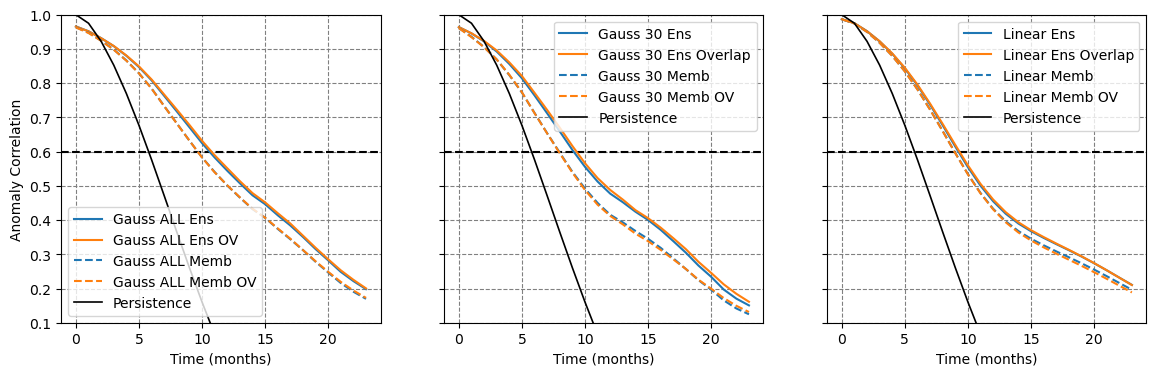

In [196]:
fig, ax = plt.subplots(nrows=1, ncols=3,sharey=True,figsize=(14,4))

xval=range(0,24)

ax[0].axhline(0.6, linestyle='--',color='black')
ax[0].set_xlabel('Time (months)')
ax[0].set_ylabel('Anomaly Correlation')
ax[0].set_ylim([0.1,1.0])
ax[0].set_title('',loc='left')
ax[0].plot(xval, np.mean(GaussALL_mean, axis=1), lw=1.5, label='Gauss ALL Ens')
ax[0].plot(xval, np.mean(GaussALL_mean_OV, axis=1), lw=1.5, label='Gauss ALL Ens OV')
ax[0].set_prop_cycle(None)
ax[0].plot(xval, np.mean(np.mean(GaussALL_ind, axis=1), axis=1), lw=1.5, label='Gauss ALL Memb', linestyle='dashed')
ax[0].plot(xval, np.mean(np.mean(GaussALL_ind_OV, axis=1), axis=1), lw=1.5, label='Gauss ALL Memb OV', linestyle='dashed')
ax[0].plot(xval, CORR_PERS, lw=1.2, label='Persistence', color='black')
ax[0].yaxis.grid(color='gray', linestyle='dashed')
ax[0].xaxis.grid(color='gray', linestyle='dashed')
ax[0].legend(loc='lower left')

ax[1].axhline(0.6, linestyle='--',color='black')
ax[1].set_xlabel('Time (months)')
ax[1].set_ylim([0.1,1.0])
ax[1].set_title('',loc='left')
ax[1].plot(xval, np.mean(Gauss30_mean, axis=1), lw=1.5, label='Gauss 30 Ens')
ax[1].plot(xval, np.mean(Gauss30_mean_OV, axis=1), lw=1.5, label='Gauss 30 Ens Overlap')
ax[1].set_prop_cycle(None)
ax[1].plot(xval, np.mean(np.mean(Gauss30_ind, axis=1), axis=1), lw=1.5, label='Gauss 30 Memb', linestyle='dashed')
ax[1].plot(xval, np.mean(np.mean(Gauss30_ind_OV, axis=1), axis=1), lw=1.5, label='Gauss 30 Memb OV', linestyle='dashed')
ax[1].plot(xval, CORR_PERS, lw=1.2, label='Persistence', color='black')
ax[1].yaxis.grid(color='gray', linestyle='dashed')
ax[1].xaxis.grid(color='gray', linestyle='dashed')
ax[1].legend(loc='upper right')

ax[2].axhline(0.6, linestyle='--',color='black')
ax[2].set_xlabel('Time (months)')
ax[2].set_ylim([0.1,1.0])
ax[2].set_title('',loc='left')
ax[2].plot(xval, np.mean(Poly_mean, axis=1), lw=1.5, label='Linear Ens')
ax[2].plot(xval, np.mean(Poly_mean_OV, axis=1), lw=1.5, label='Linear Ens Overlap')
ax[2].set_prop_cycle(None)
ax[2].plot(xval, np.mean(np.mean(Poly_ind, axis=1), axis=1), lw=1.5, label='Linear Memb', linestyle='dashed')
ax[2].plot(xval, np.mean(np.mean(Poly_ind_OV, axis=1), axis=1), lw=1.5, label='Linear Memb OV', linestyle='dashed')
ax[2].plot(xval, CORR_PERS, lw=1.2, label='Persistence', color='black')
ax[2].yaxis.grid(color='gray', linestyle='dashed')
ax[2].xaxis.grid(color='gray', linestyle='dashed')
ax[2].legend(loc='upper right')


plt.suptitle('',fontsize='xx-large')
labfile = 'due metodi forecasting MONTHS' + '.pdf'
#plt.savefig(labfile, orientation='landscape',  format='pdf')
plt.show() 

# 30 years

### Tools for the plots

In [19]:
import nc_time_axis

In [20]:
flabel = {'fontsize':14,'fontweight':'bold'}   #,'fontfamily':'Futura'
ftitle = {'fontsize':18,'fontweight':'bold'}   #,'fontfamily':'Futura',

In [21]:
from pylab import *

cmap = cm.get_cmap('plasma', 19)
color_list = [matplotlib.colors.rgb2hex(cmap(i)[:3]) for i in range(cmap.N)]

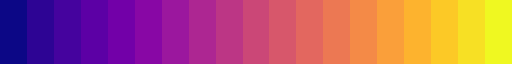

In [22]:
cmap   # First forecasts purple,    last forecasts yellow

### Data preparation

In [23]:
## Load EOFs
PCs=np.load('Processed_data/PCs_CESM_845SST_1000SSH.npy')
EOFs=np.load('Processed_data/EOFs_CESM_845SST_1000SSH.npy')

In [24]:
for_levels=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]
periods=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
periods_150=[0,1,2,3,4,5,6,7,8,9,10,11,12]
lead_times=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]

## ALL GAUSS

In [38]:
mean_av=np.zeros((24,13))
mean_ind=np.zeros((24,5,13))

RMSE_mean_av=np.zeros((24,13))
RMSE_mean_ind=np.zeros((24,5,13))

In [39]:
#Select EOFs
udat_sst=EOFs[:,0:845]

In [55]:
## Compute observations NON truncated to PCs
Xindex=X_tos.A.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))#[:-1]
Xindex

<xarray.DataArray (time: 24000)>
array([-0.07060546,  0.05650981,  0.28544343, ..., -0.9016017 ,
       -0.9271781 , -0.89309406], dtype=float32)
Coordinates:
  * time     (time) object 0001-02-01 00:00:00 ... 2001-01-01 00:00:00
    z_t      float32 500.0
    month    (time) int64 2 3 4 5 6 7 8 9 10 11 12 ... 3 4 5 6 7 8 9 10 11 12 1

In [56]:
tot_for_union=np.empty((5, 845, 24, 24000))
tot_for_union.fill(np.NaN)

In [57]:
for m in lead_times:
    for n in periods_150:
        tot_for_union[:,:,m, m + n*1800 : m + n*1800 +1776]=np.load(f'150 years testing/150 years testing-Forecasts 30/ALLEOFs_forecast_p{n}.npy')[:,0:845,m,:]

In [58]:
tot_for_union.shape

(5, 845, 24, 24000)

In [59]:
for m in periods_150:

    Xindex1=Xindex.isel(time=slice(0+150*12*m,150*12+150*12*m))
    X_tos1=X_tos.A[:,0+150*12*m:150*12+150*12*m]
    
    tot_for_union1=tot_for_union[:,:,:,0+150*12*m:150*12+150*12*m]
    print('Period ', m, '  forecast: ',m*2)
    
    for n in lead_times:
    
        lead=n
    
        # Compute average forecast
        av_for=np.nanmean(tot_for_union1, axis=0)
        av_for_geo_array=udat_sst @ av_for[0:845,lead,:]            
        av_for_geo = xr.full_like(X_tos1[:,:],0)
        av_for_geo.data=av_for_geo_array.real
        Avindex=av_for_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))

        #Correlation average forecast and observations
        mean_av[lead,m]=np.corrcoef(Xindex1[np.invert(np.isnan(Avindex))],Avindex[np.invert(np.isnan(Avindex))])[0,1]
        RMSE_mean_av[lead,m]=1-np.sqrt(np.square(np.subtract(Xindex1[np.invert(np.isnan(Avindex))],Avindex[np.invert(np.isnan(Avindex))])).mean()) / np.std(Xindex1[np.invert(np.isnan(Avindex))])
        print("Lead ", n, " ensemble mean correlation ",mean_av[lead,m])
    
        #Average correlation between individual forecast and observations
        for i in range(5):  
            phix_geo_array=udat_sst @ tot_for_union1[i,0:845,lead,:]  
            phix_geo = xr.full_like(X_tos1[:,:],0)
            phix_geo.data=phix_geo_array.real
            Phiindex=phix_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))

            mean_ind[lead,i,m]=np.corrcoef(Xindex1[np.invert(np.isnan(Phiindex))],Phiindex[np.invert(np.isnan(Phiindex))])[0,1]
            RMSE_mean_ind[lead,i,m]= 1-np.sqrt(np.square(np.subtract(Xindex1[np.invert(np.isnan(Phiindex))],Phiindex[np.invert(np.isnan(Phiindex))])).mean()) / np.std(Xindex1[np.invert(np.isnan(Phiindex))])
            
        av_corr=np.mean(mean_ind[lead,:,m], axis=0)
        print("Lead ", n, " ensemble member correlation ",av_corr)
        
        
'''        #Plot
        import nc_time_axis
    
        fig, ax = plt.subplots(1, 1, figsize=(16,3.5),squeeze=False)
    
        Xindex1.plot(label='Untruncated Obs',lw=1.2,color='gray')
    
        for i in range(3):  
            #Expand forecast to geographical domain
            phix_geo_array=udat_sst @ tot_for_union1[i,0:845,lead,:]  
            phix_geo = xr.full_like(X_tos1[:,:],0)
            phix_geo.data=phix_geo_array.real
    
            Phiindex=phix_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))
            Phiindex.plot(lw=0.5, color='red', alpha=0.4)
    
        Avindex.plot(label='Average forecast',lw=0.8,color='blue')

        plt.axhline(0,color='black',lw=0.5)
        plt.title(f'NINO3.4 forecast Lead {lead}',ftitle)
        plt.title(f'Gaussian Kernel',loc='left',**flabel)
        plt.xlabel(' ')
        plt.legend(loc='upper right')
        zmap.changebox(plt.gca(),'all',linewidth=1.5)
        #loctime = Xindex1.sel(time='1-JAN-2000').time.data
        cstr1 = f' Corr aver. for: {mean_av[lead,m]:>.2f}'
        cstr2 = f' Aver. corr of ind. for: {av_corr:>.2f}'
        loctime = Xindex1.isel(time=450).time.data
        plt.text(loctime,-2.1,cstr1)
        plt.text(loctime,-2.3,cstr2)
        #labfile =  f'{data_name}{case}_NINO3BANDA_{KK.kernel_choice}{tolone}.pdf'
        #plt.savefig(labfile, orientation='landscape',  format='pdf')
        plt.show()'''


Period  0   forecast:  0
Lead  0  ensemble mean correlation  0.9461125273336204
Lead  0  ensemble member correlation  0.9376040834646746
Lead  1  ensemble mean correlation  0.9306928586607963
Lead  1  ensemble member correlation  0.9168188913952673
Lead  2  ensemble mean correlation  0.907811826684757
Lead  2  ensemble member correlation  0.8873802378631435
Lead  3  ensemble mean correlation  0.8848585186326466
Lead  3  ensemble member correlation  0.8595149111651477
Lead  4  ensemble mean correlation  0.8541846591207688
Lead  4  ensemble member correlation  0.821071561979139
Lead  5  ensemble mean correlation  0.8182265210683863
Lead  5  ensemble member correlation  0.7737018781039968
Lead  6  ensemble mean correlation  0.7778888603818696
Lead  6  ensemble member correlation  0.7241841928599397
Lead  7  ensemble mean correlation  0.7358677476593768
Lead  7  ensemble member correlation  0.6676848624457639
Lead  8  ensemble mean correlation  0.6896178379689062
Lead  8  ensemble member c

"        #Plot\n        import nc_time_axis\n    \n        fig, ax = plt.subplots(1, 1, figsize=(16,3.5),squeeze=False)\n    \n        Xindex1.plot(label='Untruncated Obs',lw=1.2,color='gray')\n    \n        for i in range(3):  \n            #Expand forecast to geographical domain\n            phix_geo_array=udat_sst @ tot_for_union1[i,0:845,lead,:]  \n            phix_geo = xr.full_like(X_tos1[:,:],0)\n            phix_geo.data=phix_geo_array.real\n    \n            Phiindex=phix_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))\n            Phiindex.plot(lw=0.5, color='red', alpha=0.4)\n    \n        Avindex.plot(label='Average forecast',lw=0.8,color='blue')\n\n        plt.axhline(0,color='black',lw=0.5)\n        plt.title(f'NINO3.4 forecast Lead {lead}',ftitle)\n        plt.title(f'Gaussian Kernel',loc='left',**flabel)\n        plt.xlabel(' ')\n        plt.legend(loc='upper right')\n        zmap.changebox(plt.gca(),'all',linewidth=1.5)\n        #loctime =

In [73]:
np.save('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEAN_CORR_GAUSSALL_30', mean_av, allow_pickle=True, fix_imports=True)
np.save('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEMBERS_CORR_GAUSSALL_30', mean_ind, allow_pickle=True, fix_imports=True)
np.save('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEAN_RMSE_GAUSSALL_30', RMSE_mean_av, allow_pickle=True, fix_imports=True)
np.save('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEMBERS_RMSE_GAUSSALL_30', RMSE_mean_ind, allow_pickle=True, fix_imports=True)

## ALL GAUSS OV

In [114]:
mean_av=np.zeros((24,13))
mean_ind=np.zeros((24,9,13))

RMSE_mean_av=np.zeros((24,13))
RMSE_mean_ind=np.zeros((24,9,13))

In [115]:
#Select EOFs
udat_sst=EOFs[:,0:845]

In [116]:
## Compute observations NON truncated to PCs
Xindex=X_tos.A.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))#[:-1]
Xindex

<xarray.DataArray (time: 24000)>
array([-0.07060546,  0.05650981,  0.28544343, ..., -0.9016017 ,
       -0.9271781 , -0.89309406], dtype=float32)
Coordinates:
  * time     (time) object 0001-02-01 00:00:00 ... 2001-01-01 00:00:00
    z_t      float32 500.0
    month    (time) int64 2 3 4 5 6 7 8 9 10 11 12 ... 3 4 5 6 7 8 9 10 11 12 1

In [117]:
tot_for_union=np.empty((9, 845, 24, 24000))
tot_for_union.fill(np.NaN)

In [118]:
for m in lead_times:
    for n in periods_150:
        tot_for_union[0:5,:,m, m + n*1800 : m + n*1800 +1776]=np.load(f'150 years testing/150 years testing-Forecasts 30/ALLEOFs_forecast_p{n}.npy')[:,0:845,m,:]

In [119]:
for m in lead_times:
    for n in periods_150:
        tot_for_union[5:9,:,m, m + n*1800 : m + n*1800 +1776]=np.load(f'150 years testing/150 years testing-Forecasts 30/ALLEOFs_forecast_p{n}_OV.npy')[:,0:845,m,:]

In [120]:
for m in periods_150:

    Xindex1=Xindex.isel(time=slice(0+150*12*m,150*12+150*12*m))
    X_tos1=X_tos.A[:,0+150*12*m:150*12+150*12*m]
    
    tot_for_union1=tot_for_union[:,:,:,0+150*12*m:150*12+150*12*m]
    print('Period ', m, '  forecast: ',m*2)
    
    for n in lead_times:
    
        lead=n
    
        # Compute average forecast
        av_for=np.nanmean(tot_for_union1, axis=0)
        av_for_geo_array=udat_sst @ av_for[0:845,lead,:]            
        av_for_geo = xr.full_like(X_tos1[:,:],0)
        av_for_geo.data=av_for_geo_array.real
        Avindex=av_for_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))

        #Correlation average forecast and observations
        mean_av[lead,m]=np.corrcoef(Xindex1[np.invert(np.isnan(Avindex))],Avindex[np.invert(np.isnan(Avindex))])[0,1]
        RMSE_mean_av[lead,m]=1-np.sqrt(np.square(np.subtract(Xindex1[np.invert(np.isnan(Avindex))],Avindex[np.invert(np.isnan(Avindex))])).mean()) / np.std(Xindex1[np.invert(np.isnan(Avindex))])
        print("Lead ", n, " ensemble mean correlation ",mean_av[lead,m])
    
        #Average correlation between individual forecast and observations
        for i in range(9):  
            phix_geo_array=udat_sst @ tot_for_union1[i,0:845,lead,:]  
            phix_geo = xr.full_like(X_tos1[:,:],0)
            phix_geo.data=phix_geo_array.real
            Phiindex=phix_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))

            mean_ind[lead,i,m]=np.corrcoef(Xindex1[np.invert(np.isnan(Phiindex))],Phiindex[np.invert(np.isnan(Phiindex))])[0,1]
            RMSE_mean_ind[lead,i,m]= 1-np.sqrt(np.square(np.subtract(Xindex1[np.invert(np.isnan(Phiindex))],Phiindex[np.invert(np.isnan(Phiindex))])).mean()) / np.std(Xindex1[np.invert(np.isnan(Phiindex))])
            
        av_corr=np.mean(mean_ind[lead,:,m], axis=0)
        print("Lead ", n, " ensemble member correlation ",av_corr)
        
        
'''        #Plot
        import nc_time_axis
    
        fig, ax = plt.subplots(1, 1, figsize=(16,3.5),squeeze=False)
    
        Xindex1.plot(label='Untruncated Obs',lw=1.2,color='gray')
    
        for i in range(3):  
            #Expand forecast to geographical domain
            phix_geo_array=udat_sst @ tot_for_union1[i,0:845,lead,:]  
            phix_geo = xr.full_like(X_tos1[:,:],0)
            phix_geo.data=phix_geo_array.real
    
            Phiindex=phix_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))
            Phiindex.plot(lw=0.5, color='red', alpha=0.4)
    
        Avindex.plot(label='Average forecast',lw=0.8,color='blue')

        plt.axhline(0,color='black',lw=0.5)
        plt.title(f'NINO3.4 forecast Lead {lead}',ftitle)
        plt.title(f'Gaussian Kernel',loc='left',**flabel)
        plt.xlabel(' ')
        plt.legend(loc='upper right')
        zmap.changebox(plt.gca(),'all',linewidth=1.5)
        #loctime = Xindex1.sel(time='1-JAN-2000').time.data
        cstr1 = f' Corr aver. for: {mean_av[lead,m]:>.2f}'
        cstr2 = f' Aver. corr of ind. for: {av_corr:>.2f}'
        loctime = Xindex1.isel(time=450).time.data
        plt.text(loctime,-2.1,cstr1)
        plt.text(loctime,-2.3,cstr2)
        #labfile =  f'{data_name}{case}_NINO3BANDA_{KK.kernel_choice}{tolone}.pdf'
        #plt.savefig(labfile, orientation='landscape',  format='pdf')
        plt.show()'''


Period  0   forecast:  0
Lead  0  ensemble mean correlation  0.9441115405718498
Lead  0  ensemble member correlation  0.9347437916361938
Lead  1  ensemble mean correlation  0.9277170005673324
Lead  1  ensemble member correlation  0.9137476897212711
Lead  2  ensemble mean correlation  0.9056721765588035
Lead  2  ensemble member correlation  0.8865324612958576
Lead  3  ensemble mean correlation  0.8825726038142185
Lead  3  ensemble member correlation  0.8591417332401409
Lead  4  ensemble mean correlation  0.8519253822846501
Lead  4  ensemble member correlation  0.8208982740673931
Lead  5  ensemble mean correlation  0.8165864977711909
Lead  5  ensemble member correlation  0.7755644704221277
Lead  6  ensemble mean correlation  0.7780902146351857
Lead  6  ensemble member correlation  0.7280282751227111
Lead  7  ensemble mean correlation  0.7366963926051415
Lead  7  ensemble member correlation  0.6711331775044377
Lead  8  ensemble mean correlation  0.6914977356598558
Lead  8  ensemble member

"        #Plot\n        import nc_time_axis\n    \n        fig, ax = plt.subplots(1, 1, figsize=(16,3.5),squeeze=False)\n    \n        Xindex1.plot(label='Untruncated Obs',lw=1.2,color='gray')\n    \n        for i in range(3):  \n            #Expand forecast to geographical domain\n            phix_geo_array=udat_sst @ tot_for_union1[i,0:845,lead,:]  \n            phix_geo = xr.full_like(X_tos1[:,:],0)\n            phix_geo.data=phix_geo_array.real\n    \n            Phiindex=phix_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))\n            Phiindex.plot(lw=0.5, color='red', alpha=0.4)\n    \n        Avindex.plot(label='Average forecast',lw=0.8,color='blue')\n\n        plt.axhline(0,color='black',lw=0.5)\n        plt.title(f'NINO3.4 forecast Lead {lead}',ftitle)\n        plt.title(f'Gaussian Kernel',loc='left',**flabel)\n        plt.xlabel(' ')\n        plt.legend(loc='upper right')\n        zmap.changebox(plt.gca(),'all',linewidth=1.5)\n        #loctime =

In [121]:
np.save('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEAN_CORR_GAUSSALL_30_OV', mean_av, allow_pickle=True, fix_imports=True)
np.save('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEMBERS_CORR_GAUSSALL_30_OV', mean_ind, allow_pickle=True, fix_imports=True)
np.save('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEAN_RMSE_GAUSSALL_30_OV', RMSE_mean_av, allow_pickle=True, fix_imports=True)
np.save('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEMBERS_RMSE_GAUSSALL_30_OV', RMSE_mean_ind, allow_pickle=True, fix_imports=True)

In [129]:
np.mean(mean_av, axis=1)

array([0.9528853 , 0.93964851, 0.92094306, 0.89940087, 0.87310392,
       0.84180543, 0.80417589, 0.7611123 , 0.71818444, 0.67308426,
       0.62725442, 0.58390026, 0.54536377, 0.51047197, 0.47839372,
       0.45227796, 0.42344511, 0.39591228, 0.3640328 , 0.33091299,
       0.30016418, 0.27124119, 0.2464206 , 0.22426048])

In [131]:
np.mean(GaussALL_mean_OV, axis=1)

array([0.9528853 , 0.93964851, 0.92094306, 0.89940087, 0.87310392,
       0.84180543, 0.80417589, 0.7611123 , 0.71818444, 0.67308426,
       0.62725442, 0.58390026, 0.54536377, 0.51047197, 0.47839372,
       0.45227796, 0.42344511, 0.39591228, 0.3640328 , 0.33091299,
       0.30016418, 0.27124119, 0.2464206 , 0.22426048])

## 30 POLY

In [93]:
mean_av=np.zeros((24,13))
mean_ind=np.zeros((24,5,13))

RMSE_mean_av=np.zeros((24,13))
RMSE_mean_ind=np.zeros((24,5,13))

In [94]:
#Select EOFs
udat_sst=EOFs[:,0:20]

In [95]:
## Compute observations NON truncated to PCs
Xindex=X_tos.A.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))#[:-1]
Xindex

<xarray.DataArray (time: 24000)>
array([-0.07060546,  0.05650981,  0.28544343, ..., -0.9016017 ,
       -0.9271781 , -0.89309406], dtype=float32)
Coordinates:
  * time     (time) object 0001-02-01 00:00:00 ... 2001-01-01 00:00:00
    z_t      float32 500.0
    month    (time) int64 2 3 4 5 6 7 8 9 10 11 12 ... 3 4 5 6 7 8 9 10 11 12 1

In [96]:
tot_for_union=np.empty((5, 20, 24, 24000))
tot_for_union.fill(np.NaN)

In [97]:
for m in lead_times:
    for n in periods_150:
        tot_for_union[:,:,m, m + n*1800 : m + n*1800 +1776]=np.load(f'150 years testing/150 years testing-Forecasts 30/POLY_forecast_p{n}.npy')[:,0:20,m,:]

In [98]:
for m in periods_150:

    Xindex1=Xindex.isel(time=slice(0+150*12*m,150*12+150*12*m))
    X_tos1=X_tos.A[:,0+150*12*m:150*12+150*12*m]
    
    tot_for_union1=tot_for_union[:,:,:,0+150*12*m:150*12+150*12*m]
    print('Period ', m, '  forecast: ',m*2)
    
    for n in lead_times:
    
        lead=n
    
        # Compute average forecast
        av_for=np.nanmean(tot_for_union1, axis=0)
        av_for_geo_array=udat_sst @ av_for[0:20,lead,:]            
        av_for_geo = xr.full_like(X_tos1[:,:],0)
        av_for_geo.data=av_for_geo_array.real
        Avindex=av_for_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))

        #Correlation average forecast and observations
        mean_av[lead,m]=np.corrcoef(Xindex1[np.invert(np.isnan(Avindex))],Avindex[np.invert(np.isnan(Avindex))])[0,1]
        RMSE_mean_av[lead,m]=1-np.sqrt(np.square(np.subtract(Xindex1[np.invert(np.isnan(Avindex))],Avindex[np.invert(np.isnan(Avindex))])).mean()) / np.std(Xindex1[np.invert(np.isnan(Avindex))])
        print("Lead ", n, " ensemble mean correlation ",mean_av[lead,m])
    
        #Average correlation between individual forecast and observations
        for i in range(5):  
            phix_geo_array=udat_sst @ tot_for_union1[i,0:20,lead,:]  
            phix_geo = xr.full_like(X_tos1[:,:],0)
            phix_geo.data=phix_geo_array.real
            Phiindex=phix_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))

            mean_ind[lead,i,m]=np.corrcoef(Xindex1[np.invert(np.isnan(Phiindex))],Phiindex[np.invert(np.isnan(Phiindex))])[0,1]
            RMSE_mean_ind[lead,i,m]= 1-np.sqrt(np.square(np.subtract(Xindex1[np.invert(np.isnan(Phiindex))],Phiindex[np.invert(np.isnan(Phiindex))])).mean()) / np.std(Xindex1[np.invert(np.isnan(Phiindex))])
            
        av_corr=np.mean(mean_ind[lead,:,m], axis=0)
        print("Lead ", n, " ensemble member correlation ",av_corr)
        
        
'''        #Plot
        import nc_time_axis
    
        fig, ax = plt.subplots(1, 1, figsize=(16,3.5),squeeze=False)
    
        Xindex1.plot(label='Untruncated Obs',lw=1.2,color='gray')
    
        for i in range(3):  
            #Expand forecast to geographical domain
            phix_geo_array=udat_sst @ tot_for_union1[i,0:20,lead,:]  
            phix_geo = xr.full_like(X_tos1[:,:],0)
            phix_geo.data=phix_geo_array.real
    
            Phiindex=phix_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))
            Phiindex.plot(lw=0.5, color='red', alpha=0.4)
    
        Avindex.plot(label='Average forecast',lw=0.8,color='blue')

        plt.axhline(0,color='black',lw=0.5)
        plt.title(f'NINO3.4 forecast Lead {lead}',ftitle)
        plt.title(f'Gaussian Kernel',loc='left',**flabel)
        plt.xlabel(' ')
        plt.legend(loc='upper right')
        zmap.changebox(plt.gca(),'all',linewidth=1.5)
        #loctime = Xindex1.sel(time='1-JAN-2000').time.data
        cstr1 = f' Corr aver. for: {mean_av[lead,m]:>.2f}'
        cstr2 = f' Aver. corr of ind. for: {av_corr:>.2f}'
        loctime = Xindex1.isel(time=450).time.data
        plt.text(loctime,-2.1,cstr1)
        plt.text(loctime,-2.3,cstr2)
        #labfile =  f'{data_name}{case}_NINO3BANDA_{KK.kernel_choice}{tolone}.pdf'
        #plt.savefig(labfile, orientation='landscape',  format='pdf')
        plt.show()'''


Period  0   forecast:  0
Lead  0  ensemble mean correlation  0.9868577389493082
Lead  0  ensemble member correlation  0.9867676786435595
Lead  1  ensemble mean correlation  0.9744927159861734
Lead  1  ensemble member correlation  0.9724682520340286
Lead  2  ensemble mean correlation  0.9502307146643668
Lead  2  ensemble member correlation  0.9439887791849081
Lead  3  ensemble mean correlation  0.9202591282148797
Lead  3  ensemble member correlation  0.9080569154519521
Lead  4  ensemble mean correlation  0.8841110290373845
Lead  4  ensemble member correlation  0.8640003543981694
Lead  5  ensemble mean correlation  0.8411938525880989
Lead  5  ensemble member correlation  0.8112370983769397
Lead  6  ensemble mean correlation  0.7911996261883859
Lead  6  ensemble member correlation  0.7498644298219777
Lead  7  ensemble mean correlation  0.7351316733487115
Lead  7  ensemble member correlation  0.6817091298718954
Lead  8  ensemble mean correlation  0.6737811809702546
Lead  8  ensemble member

"        #Plot\n        import nc_time_axis\n    \n        fig, ax = plt.subplots(1, 1, figsize=(16,3.5),squeeze=False)\n    \n        Xindex1.plot(label='Untruncated Obs',lw=1.2,color='gray')\n    \n        for i in range(3):  \n            #Expand forecast to geographical domain\n            phix_geo_array=udat_sst @ tot_for_union1[i,0:20,lead,:]  \n            phix_geo = xr.full_like(X_tos1[:,:],0)\n            phix_geo.data=phix_geo_array.real\n    \n            Phiindex=phix_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))\n            Phiindex.plot(lw=0.5, color='red', alpha=0.4)\n    \n        Avindex.plot(label='Average forecast',lw=0.8,color='blue')\n\n        plt.axhline(0,color='black',lw=0.5)\n        plt.title(f'NINO3.4 forecast Lead {lead}',ftitle)\n        plt.title(f'Gaussian Kernel',loc='left',**flabel)\n        plt.xlabel(' ')\n        plt.legend(loc='upper right')\n        zmap.changebox(plt.gca(),'all',linewidth=1.5)\n        #loctime = 

In [99]:
np.save('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEAN_CORR_POLY_30', mean_av, allow_pickle=True, fix_imports=True)
np.save('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEMBERS_CORR_POLY_30', mean_ind, allow_pickle=True, fix_imports=True)
np.save('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEAN_RMSE_POLY_30', RMSE_mean_av, allow_pickle=True, fix_imports=True)
np.save('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEMBERS_RMSE_POLY_30', RMSE_mean_ind, allow_pickle=True, fix_imports=True)

## 30 POLY OV

In [135]:
mean_av=np.zeros((24,13))
mean_ind=np.zeros((24,9,13))

RMSE_mean_av=np.zeros((24,13))
RMSE_mean_ind=np.zeros((24,9,13))

In [136]:
#Select EOFs
udat_sst=EOFs[:,0:20]

In [137]:
## Compute observations NON truncated to PCs
Xindex=X_tos.A.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))#[:-1]
Xindex

<xarray.DataArray (time: 24000)>
array([-0.07060546,  0.05650981,  0.28544343, ..., -0.9016017 ,
       -0.9271781 , -0.89309406], dtype=float32)
Coordinates:
  * time     (time) object 0001-02-01 00:00:00 ... 2001-01-01 00:00:00
    z_t      float32 500.0
    month    (time) int64 2 3 4 5 6 7 8 9 10 11 12 ... 3 4 5 6 7 8 9 10 11 12 1

In [138]:
tot_for_union=np.empty((9, 20, 24, 24000))
tot_for_union.fill(np.NaN)

In [139]:
for m in lead_times:
    for n in periods_150:
        tot_for_union[0:5,:,m, m + n*1800 : m + n*1800 +1776]=np.load(f'150 years testing/150 years testing-Forecasts 30/POLY_forecast_p{n}.npy')[:,0:20,m,:]

In [140]:
for m in lead_times:
    for n in periods_150:
        tot_for_union[5:9,:,m, m + n*1800 : m + n*1800 +1776]=np.load(f'150 years testing/150 years testing-Forecasts 30/POLY_forecast_p{n}_OV.npy')[:,0:20,m,:]

In [141]:
for m in periods_150:

    Xindex1=Xindex.isel(time=slice(0+150*12*m,150*12+150*12*m))
    X_tos1=X_tos.A[:,0+150*12*m:150*12+150*12*m]
    
    tot_for_union1=tot_for_union[:,:,:,0+150*12*m:150*12+150*12*m]
    print('Period ', m, '  forecast: ',m*2)
    
    for n in lead_times:
    
        lead=n
    
        # Compute average forecast
        av_for=np.nanmean(tot_for_union1, axis=0)
        av_for_geo_array=udat_sst @ av_for[0:20,lead,:]            
        av_for_geo = xr.full_like(X_tos1[:,:],0)
        av_for_geo.data=av_for_geo_array.real
        Avindex=av_for_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))

        #Correlation average forecast and observations
        mean_av[lead,m]=np.corrcoef(Xindex1[np.invert(np.isnan(Avindex))],Avindex[np.invert(np.isnan(Avindex))])[0,1]
        RMSE_mean_av[lead,m]=1-np.sqrt(np.square(np.subtract(Xindex1[np.invert(np.isnan(Avindex))],Avindex[np.invert(np.isnan(Avindex))])).mean()) / np.std(Xindex1[np.invert(np.isnan(Avindex))])
        print("Lead ", n, " ensemble mean correlation ",mean_av[lead,m])
    
        #Average correlation between individual forecast and observations
        for i in range(9):  
            phix_geo_array=udat_sst @ tot_for_union1[i,0:20,lead,:]  
            phix_geo = xr.full_like(X_tos1[:,:],0)
            phix_geo.data=phix_geo_array.real
            Phiindex=phix_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))

            mean_ind[lead,i,m]=np.corrcoef(Xindex1[np.invert(np.isnan(Phiindex))],Phiindex[np.invert(np.isnan(Phiindex))])[0,1]
            RMSE_mean_ind[lead,i,m]= 1-np.sqrt(np.square(np.subtract(Xindex1[np.invert(np.isnan(Phiindex))],Phiindex[np.invert(np.isnan(Phiindex))])).mean()) / np.std(Xindex1[np.invert(np.isnan(Phiindex))])
            
        av_corr=np.mean(mean_ind[lead,:,m], axis=0)
        print("Lead ", n, " ensemble member correlation ",av_corr)
        
        
'''        #Plot
        import nc_time_axis
    
        fig, ax = plt.subplots(1, 1, figsize=(16,3.5),squeeze=False)
    
        Xindex1.plot(label='Untruncated Obs',lw=1.2,color='gray')
    
        for i in range(3):  
            #Expand forecast to geographical domain
            phix_geo_array=udat_sst @ tot_for_union1[i,0:20,lead,:]  
            phix_geo = xr.full_like(X_tos1[:,:],0)
            phix_geo.data=phix_geo_array.real
    
            Phiindex=phix_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))
            Phiindex.plot(lw=0.5, color='red', alpha=0.4)
    
        Avindex.plot(label='Average forecast',lw=0.8,color='blue')

        plt.axhline(0,color='black',lw=0.5)
        plt.title(f'NINO3.4 forecast Lead {lead}',ftitle)
        plt.title(f'Gaussian Kernel',loc='left',**flabel)
        plt.xlabel(' ')
        plt.legend(loc='upper right')
        zmap.changebox(plt.gca(),'all',linewidth=1.5)
        #loctime = Xindex1.sel(time='1-JAN-2000').time.data
        cstr1 = f' Corr aver. for: {mean_av[lead,m]:>.2f}'
        cstr2 = f' Aver. corr of ind. for: {av_corr:>.2f}'
        loctime = Xindex1.isel(time=450).time.data
        plt.text(loctime,-2.1,cstr1)
        plt.text(loctime,-2.3,cstr2)
        #labfile =  f'{data_name}{case}_NINO3BANDA_{KK.kernel_choice}{tolone}.pdf'
        #plt.savefig(labfile, orientation='landscape',  format='pdf')
        plt.show()'''


Period  0   forecast:  0
Lead  0  ensemble mean correlation  0.986857738949308
Lead  0  ensemble member correlation  0.9868701233944809
Lead  1  ensemble mean correlation  0.97459235145501
Lead  1  ensemble member correlation  0.9729071475342486
Lead  2  ensemble mean correlation  0.9502612238367182
Lead  2  ensemble member correlation  0.9450084523966709
Lead  3  ensemble mean correlation  0.920138742233738
Lead  3  ensemble member correlation  0.9100370728418417
Lead  4  ensemble mean correlation  0.8840454541854874
Lead  4  ensemble member correlation  0.8674950596361116
Lead  5  ensemble mean correlation  0.8417034253485529
Lead  5  ensemble member correlation  0.8172168055384291
Lead  6  ensemble mean correlation  0.7927810802601377
Lead  6  ensemble member correlation  0.7592081511126095
Lead  7  ensemble mean correlation  0.7381979305346611
Lead  7  ensemble member correlation  0.6948658095199463
Lead  8  ensemble mean correlation  0.6790231615365703
Lead  8  ensemble member cor

"        #Plot\n        import nc_time_axis\n    \n        fig, ax = plt.subplots(1, 1, figsize=(16,3.5),squeeze=False)\n    \n        Xindex1.plot(label='Untruncated Obs',lw=1.2,color='gray')\n    \n        for i in range(3):  \n            #Expand forecast to geographical domain\n            phix_geo_array=udat_sst @ tot_for_union1[i,0:20,lead,:]  \n            phix_geo = xr.full_like(X_tos1[:,:],0)\n            phix_geo.data=phix_geo_array.real\n    \n            Phiindex=phix_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))\n            Phiindex.plot(lw=0.5, color='red', alpha=0.4)\n    \n        Avindex.plot(label='Average forecast',lw=0.8,color='blue')\n\n        plt.axhline(0,color='black',lw=0.5)\n        plt.title(f'NINO3.4 forecast Lead {lead}',ftitle)\n        plt.title(f'Gaussian Kernel',loc='left',**flabel)\n        plt.xlabel(' ')\n        plt.legend(loc='upper right')\n        zmap.changebox(plt.gca(),'all',linewidth=1.5)\n        #loctime = 

In [142]:
np.save('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEAN_CORR_POLY_30_OV', mean_av, allow_pickle=True, fix_imports=True)
np.save('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEMBERS_CORR_POLY_30_OV', mean_ind, allow_pickle=True, fix_imports=True)
np.save('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEAN_RMSE_POLY_30_OV', RMSE_mean_av, allow_pickle=True, fix_imports=True)
np.save('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEMBERS_RMSE_POLY_30_OV', RMSE_mean_ind, allow_pickle=True, fix_imports=True)

## Graph

In [186]:
Poly_mean=np.load('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEAN_CORR_POLY_30.npy')
Poly_ind=np.load('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEMBERS_CORR_POLY_30.npy')
#Poly_mean_OV=np.load('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEAN_CORR_POLY_30_OV.npy')
#Poly_ind_OV=np.load('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEMBERS_CORR_POLY_30_OV.npy')

GaussALL_mean=np.load('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEAN_CORR_GAUSSALL_30.npy')
GaussALL_ind=np.load('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEMBERS_CORR_GAUSSALL_30.npy')
GaussALL_mean_OV=np.load('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEAN_CORR_GAUSSALL_30_OV.npy')
GaussALL_ind_OV=np.load('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEMBERS_CORR_GAUSSALL_30_OV.npy')


In [187]:
RMSE_PERS=np.load('Forecasts 100/Skill metrics/PERSISTENCE_RMSE.npy')
CORR_PERS=np.load('Forecasts 100/Skill metrics/PERSISTENCE_CORR.npy')

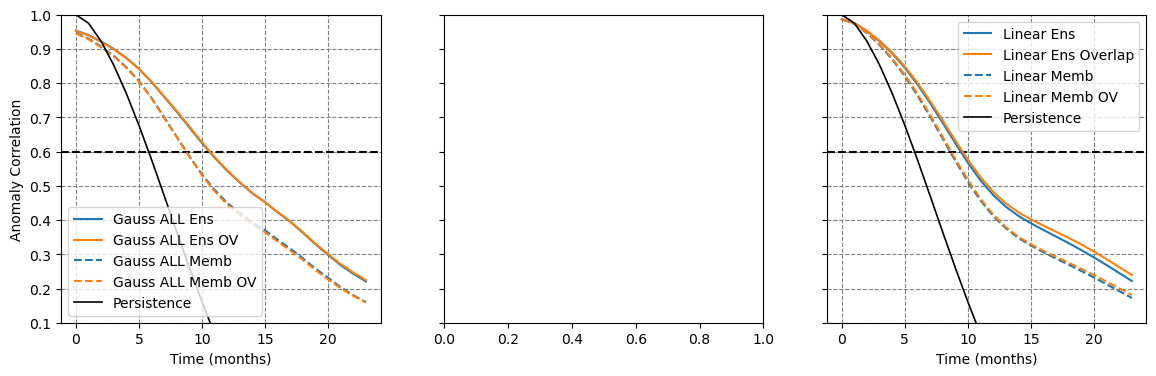

In [188]:
fig, ax = plt.subplots(nrows=1, ncols=3,sharey=True,figsize=(14,4))

xval=range(0,24)

ax[0].axhline(0.6, linestyle='--',color='black')
ax[0].set_xlabel('Time (months)')
ax[0].set_ylabel('Anomaly Correlation')
ax[0].set_ylim([0.1,1.0])
ax[0].set_title('',loc='left')
ax[0].plot(xval, np.mean(GaussALL_mean, axis=1), lw=1.5, label='Gauss ALL Ens')
ax[0].plot(xval, np.mean(GaussALL_mean_OV, axis=1), lw=1.5, label='Gauss ALL Ens OV')
ax[0].set_prop_cycle(None)
ax[0].plot(xval, np.mean(np.mean(GaussALL_ind, axis=1), axis=1), lw=1.5, label='Gauss ALL Memb', linestyle='dashed')
ax[0].plot(xval, np.mean(np.mean(GaussALL_ind_OV, axis=1), axis=1), lw=1.5, label='Gauss ALL Memb OV', linestyle='dashed')
ax[0].plot(xval, CORR_PERS, lw=1.2, label='Persistence', color='black')
ax[0].yaxis.grid(color='gray', linestyle='dashed')
ax[0].xaxis.grid(color='gray', linestyle='dashed')
ax[0].legend(loc='lower left')

'''ax[1].axhline(0.6, linestyle='--',color='black')
ax[1].set_xlabel('Time (months)')
ax[1].set_ylim([0.1,1.0])
ax[1].set_title('',loc='left')
ax[1].plot(xval, np.mean(Gauss30_mean, axis=1), lw=1.5, label='Gauss 30 Ens')
ax[1].plot(xval, np.mean(Gauss30_mean_OV, axis=1), lw=1.5, label='Gauss 30 Ens Overlap')
ax[1].set_prop_cycle(None)
ax[1].plot(xval, np.mean(np.mean(Gauss30_ind, axis=1), axis=1), lw=1.5, label='Gauss 30 Memb', linestyle='dashed')
ax[1].plot(xval, np.mean(np.mean(Gauss30_ind_OV, axis=1), axis=1), lw=1.5, label='Gauss 30 Memb OV', linestyle='dashed')
ax[1].plot(xval, CORR_PERS, lw=1.2, label='Persistence', color='black')
ax[1].yaxis.grid(color='gray', linestyle='dashed')
ax[1].xaxis.grid(color='gray', linestyle='dashed')
ax[1].legend(loc='upper right')'''

ax[2].axhline(0.6, linestyle='--',color='black')
ax[2].set_xlabel('Time (months)')
ax[2].set_ylim([0.1,1.0])
ax[2].set_title('',loc='left')
ax[2].plot(xval, np.mean(Poly_mean, axis=1), lw=1.5, label='Linear Ens')
ax[2].plot(xval, np.mean(Poly_mean_OV, axis=1), lw=1.5, label='Linear Ens Overlap')
ax[2].set_prop_cycle(None)
ax[2].plot(xval, np.mean(np.mean(Poly_ind, axis=1), axis=1), lw=1.5, label='Linear Memb', linestyle='dashed')
ax[2].plot(xval, np.mean(np.mean(Poly_ind_OV, axis=1), axis=1), lw=1.5, label='Linear Memb OV', linestyle='dashed')
ax[2].plot(xval, CORR_PERS, lw=1.2, label='Persistence', color='black')
ax[2].yaxis.grid(color='gray', linestyle='dashed')
ax[2].xaxis.grid(color='gray', linestyle='dashed')
ax[2].legend(loc='upper right')


plt.suptitle('',fontsize='xx-large')
labfile = 'due metodi forecasting MONTHS' + '.pdf'
#plt.savefig(labfile, orientation='landscape',  format='pdf')
plt.show() 

In [125]:
np.mean(GaussALL_mean, axis=1)

array([0.95365822, 0.94060791, 0.92186168, 0.90009644, 0.87356075,
       0.84172102, 0.80354863, 0.75971707, 0.71645754, 0.67048145,
       0.62481883, 0.58212298, 0.54358249, 0.50952626, 0.47798447,
       0.45175175, 0.42245259, 0.39495463, 0.36268946, 0.32921178,
       0.29819285, 0.26807727, 0.24280356, 0.22067061])

In [87]:
np.mean(np.load('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEAN_CORR_GAUSSALL_30.npy'), axis=1)

array([0.95365822, 0.94060791, 0.92186168, 0.90009644, 0.87356075,
       0.84172102, 0.80354863, 0.75971707, 0.71645754, 0.67048145,
       0.62481883, 0.58212298, 0.54358249, 0.50952626, 0.47798447,
       0.45175175, 0.42245259, 0.39495463, 0.36268946, 0.32921178,
       0.29819285, 0.26807727, 0.24280356, 0.22067061])

# 25 years

### Tools for the plots

In [19]:
import nc_time_axis

In [20]:
flabel = {'fontsize':14,'fontweight':'bold'}   #,'fontfamily':'Futura'
ftitle = {'fontsize':18,'fontweight':'bold'}   #,'fontfamily':'Futura',

In [21]:
from pylab import *

cmap = cm.get_cmap('plasma', 19)
color_list = [matplotlib.colors.rgb2hex(cmap(i)[:3]) for i in range(cmap.N)]

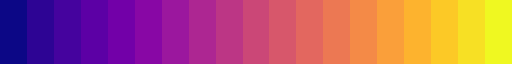

In [22]:
cmap   # First forecasts purple,    last forecasts yellow

### Data preparation

In [67]:
## Load EOFs
PCs=np.load('Processed_data/PCs_CESM_845SST_1000SSH.npy')
EOFs=np.load('Processed_data/EOFs_CESM_845SST_1000SSH.npy')

In [68]:
for_levels=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]
periods=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
periods_150=[0,1,2,3,4,5,6,7,8,9,10,11,12]
lead_times=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]

## ALL GAUSS

In [25]:
mean_av=np.zeros((24,13))
mean_ind=np.zeros((24,6,13))

RMSE_mean_av=np.zeros((24,13))
RMSE_mean_ind=np.zeros((24,6,13))

In [26]:
#Select EOFs
udat_sst=EOFs[:,0:845]

In [27]:
## Compute observations NON truncated to PCs
Xindex=X_tos.A.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))#[:-1]
Xindex

<xarray.DataArray (time: 24000)>
array([-0.07060546,  0.05650981,  0.28544343, ..., -0.9016017 ,
       -0.9271781 , -0.89309406], dtype=float32)
Coordinates:
  * time     (time) object 0001-02-01 00:00:00 ... 2001-01-01 00:00:00
    z_t      float32 500.0
    month    (time) int64 2 3 4 5 6 7 8 9 10 11 12 ... 3 4 5 6 7 8 9 10 11 12 1

In [28]:
tot_for_union=np.empty((6, 845, 24, 24000))
tot_for_union.fill(np.NaN)

In [29]:
for m in lead_times:
    for n in periods_150:
        tot_for_union[:,:,m, m + n*1800 : m + n*1800 +1776]=np.load(f'150 years testing/150 years testing-Forecasts 25/ALLEOFs_forecast_p{n}.npy')[:,0:845,m,:]

In [30]:
tot_for_union.shape

(6, 845, 24, 24000)

In [32]:
for m in periods_150:

    Xindex1=Xindex.isel(time=slice(0+150*12*m,150*12+150*12*m))
    X_tos1=X_tos.A[:,0+150*12*m:150*12+150*12*m]
    
    tot_for_union1=tot_for_union[:,:,:,0+150*12*m:150*12+150*12*m]
    print('Period ', m, '  forecast: ',m*2)
    
    for n in lead_times:
    
        lead=n
    
        # Compute average forecast
        av_for=np.nanmean(tot_for_union1, axis=0)
        av_for_geo_array=udat_sst @ av_for[0:845,lead,:]            
        av_for_geo = xr.full_like(X_tos1[:,:],0)
        av_for_geo.data=av_for_geo_array.real
        Avindex=av_for_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))

        #Correlation average forecast and observations
        mean_av[lead,m]=np.corrcoef(Xindex1[np.invert(np.isnan(Avindex))],Avindex[np.invert(np.isnan(Avindex))])[0,1]
        RMSE_mean_av[lead,m]=1-np.sqrt(np.square(np.subtract(Xindex1[np.invert(np.isnan(Avindex))],Avindex[np.invert(np.isnan(Avindex))])).mean()) / np.std(Xindex1[np.invert(np.isnan(Avindex))])
        print("Lead ", n, " ensemble mean correlation ",mean_av[lead,m])
    
        #Average correlation between individual forecast and observations
        for i in range(6):  
            phix_geo_array=udat_sst @ tot_for_union1[i,0:845,lead,:]  
            phix_geo = xr.full_like(X_tos1[:,:],0)
            phix_geo.data=phix_geo_array.real
            Phiindex=phix_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))

            mean_ind[lead,i,m]=np.corrcoef(Xindex1[np.invert(np.isnan(Phiindex))],Phiindex[np.invert(np.isnan(Phiindex))])[0,1]
            RMSE_mean_ind[lead,i,m]= 1-np.sqrt(np.square(np.subtract(Xindex1[np.invert(np.isnan(Phiindex))],Phiindex[np.invert(np.isnan(Phiindex))])).mean()) / np.std(Xindex1[np.invert(np.isnan(Phiindex))])
            
        av_corr=np.mean(mean_ind[lead,:,m], axis=0)
        print("Lead ", n, " ensemble member correlation ",av_corr)
        
        
'''        #Plot
        import nc_time_axis
    
        fig, ax = plt.subplots(1, 1, figsize=(16,3.5),squeeze=False)
    
        Xindex1.plot(label='Untruncated Obs',lw=1.2,color='gray')
    
        for i in range(3):  
            #Expand forecast to geographical domain
            phix_geo_array=udat_sst @ tot_for_union1[i,0:845,lead,:]  
            phix_geo = xr.full_like(X_tos1[:,:],0)
            phix_geo.data=phix_geo_array.real
    
            Phiindex=phix_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))
            Phiindex.plot(lw=0.5, color='red', alpha=0.4)
    
        Avindex.plot(label='Average forecast',lw=0.8,color='blue')

        plt.axhline(0,color='black',lw=0.5)
        plt.title(f'NINO3.4 forecast Lead {lead}',ftitle)
        plt.title(f'Gaussian Kernel',loc='left',**flabel)
        plt.xlabel(' ')
        plt.legend(loc='upper right')
        zmap.changebox(plt.gca(),'all',linewidth=1.5)
        #loctime = Xindex1.sel(time='1-JAN-2000').time.data
        cstr1 = f' Corr aver. for: {mean_av[lead,m]:>.2f}'
        cstr2 = f' Aver. corr of ind. for: {av_corr:>.2f}'
        loctime = Xindex1.isel(time=450).time.data
        plt.text(loctime,-2.1,cstr1)
        plt.text(loctime,-2.3,cstr2)
        #labfile =  f'{data_name}{case}_NINO3BANDA_{KK.kernel_choice}{tolone}.pdf'
        #plt.savefig(labfile, orientation='landscape',  format='pdf')
        plt.show()'''


Period  0   forecast:  0
Lead  0  ensemble mean correlation  0.9428427786583246
Lead  0  ensemble member correlation  0.9321275069131518
Lead  1  ensemble mean correlation  0.926590080488534
Lead  1  ensemble member correlation  0.909888801484196
Lead  2  ensemble mean correlation  0.9059684603273235
Lead  2  ensemble member correlation  0.8821881760536647
Lead  3  ensemble mean correlation  0.8825659730924442
Lead  3  ensemble member correlation  0.8526315015023814
Lead  4  ensemble mean correlation  0.852389995338769
Lead  4  ensemble member correlation  0.8142600598023622
Lead  5  ensemble mean correlation  0.8181992922097977
Lead  5  ensemble member correlation  0.7702343295957833
Lead  6  ensemble mean correlation  0.7815060970501249
Lead  6  ensemble member correlation  0.7229290850998361
Lead  7  ensemble mean correlation  0.7433773597736016
Lead  7  ensemble member correlation  0.6694644896255321
Lead  8  ensemble mean correlation  0.7020413706569829
Lead  8  ensemble member co

"        #Plot\n        import nc_time_axis\n    \n        fig, ax = plt.subplots(1, 1, figsize=(16,3.5),squeeze=False)\n    \n        Xindex1.plot(label='Untruncated Obs',lw=1.2,color='gray')\n    \n        for i in range(3):  \n            #Expand forecast to geographical domain\n            phix_geo_array=udat_sst @ tot_for_union1[i,0:845,lead,:]  \n            phix_geo = xr.full_like(X_tos1[:,:],0)\n            phix_geo.data=phix_geo_array.real\n    \n            Phiindex=phix_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))\n            Phiindex.plot(lw=0.5, color='red', alpha=0.4)\n    \n        Avindex.plot(label='Average forecast',lw=0.8,color='blue')\n\n        plt.axhline(0,color='black',lw=0.5)\n        plt.title(f'NINO3.4 forecast Lead {lead}',ftitle)\n        plt.title(f'Gaussian Kernel',loc='left',**flabel)\n        plt.xlabel(' ')\n        plt.legend(loc='upper right')\n        zmap.changebox(plt.gca(),'all',linewidth=1.5)\n        #loctime =

In [33]:
np.save('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEAN_CORR_GAUSALL_25', mean_av, allow_pickle=True, fix_imports=True)
np.save('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEMBERS_CORR_GAUSALL_25', mean_ind, allow_pickle=True, fix_imports=True)
np.save('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEAN_RMSE_GAUSALL_25', RMSE_mean_av, allow_pickle=True, fix_imports=True)
np.save('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEMBERS_RMSE_GAUSALL_25', RMSE_mean_ind, allow_pickle=True, fix_imports=True)

## ALL GAUSS OV

In [69]:
mean_av=np.zeros((24,13))
mean_ind=np.zeros((24,11,13))

RMSE_mean_av=np.zeros((24,13))
RMSE_mean_ind=np.zeros((24,11,13))

In [70]:
#Select EOFs
udat_sst=EOFs[:,0:845]

In [71]:
## Compute observations NON truncated to PCs
Xindex=X_tos.A.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))#[:-1]
Xindex

<xarray.DataArray (time: 24000)>
array([-0.07060546,  0.05650981,  0.28544343, ..., -0.9016017 ,
       -0.9271781 , -0.89309406], dtype=float32)
Coordinates:
  * time     (time) object 0001-02-01 00:00:00 ... 2001-01-01 00:00:00
    z_t      float32 500.0
    month    (time) int64 2 3 4 5 6 7 8 9 10 11 12 ... 3 4 5 6 7 8 9 10 11 12 1

In [72]:
tot_for_union=np.empty((11, 845, 24, 24000))
tot_for_union.fill(np.NaN)

In [73]:
for m in lead_times:
    for n in periods_150:
        tot_for_union[0:6,:,m, m + n*1800 : m + n*1800 +1776]=np.load(f'150 years testing/150 years testing-Forecasts 25/ALLEOFs_forecast_p{n}.npy')[:,0:845,m,:]

In [74]:
for m in lead_times:
    for n in periods_150:
        tot_for_union[6:11,:,m, m + n*1800 : m + n*1800 +1776]=np.load(f'150 years testing/150 years testing-Forecasts 25/ALLEOFs_forecast_p{n}_OV.npy')[:,0:845,m,:]

In [75]:
for m in periods_150:

    Xindex1=Xindex.isel(time=slice(0+150*12*m,150*12+150*12*m))
    X_tos1=X_tos.A[:,0+150*12*m:150*12+150*12*m]
    
    tot_for_union1=tot_for_union[:,:,:,0+150*12*m:150*12+150*12*m]
    print('Period ', m, '  forecast: ',m*2)
    
    for n in lead_times:
    
        lead=n
    
        # Compute average forecast
        av_for=np.nanmean(tot_for_union1, axis=0)
        av_for_geo_array=udat_sst @ av_for[0:845,lead,:]            
        av_for_geo = xr.full_like(X_tos1[:,:],0)
        av_for_geo.data=av_for_geo_array.real
        Avindex=av_for_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))

        #Correlation average forecast and observations
        mean_av[lead,m]=np.corrcoef(Xindex1[np.invert(np.isnan(Avindex))],Avindex[np.invert(np.isnan(Avindex))])[0,1]
        RMSE_mean_av[lead,m]=1-np.sqrt(np.square(np.subtract(Xindex1[np.invert(np.isnan(Avindex))],Avindex[np.invert(np.isnan(Avindex))])).mean()) / np.std(Xindex1[np.invert(np.isnan(Avindex))])
        print("Lead ", n, " ensemble mean correlation ",mean_av[lead,m])
    
        #Average correlation between individual forecast and observations
        for i in range(11):  
            phix_geo_array=udat_sst @ tot_for_union1[i,0:845,lead,:]  
            phix_geo = xr.full_like(X_tos1[:,:],0)
            phix_geo.data=phix_geo_array.real
            Phiindex=phix_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))

            mean_ind[lead,i,m]=np.corrcoef(Xindex1[np.invert(np.isnan(Phiindex))],Phiindex[np.invert(np.isnan(Phiindex))])[0,1]
            RMSE_mean_ind[lead,i,m]= 1-np.sqrt(np.square(np.subtract(Xindex1[np.invert(np.isnan(Phiindex))],Phiindex[np.invert(np.isnan(Phiindex))])).mean()) / np.std(Xindex1[np.invert(np.isnan(Phiindex))])
            
        av_corr=np.mean(mean_ind[lead,:,m], axis=0)
        print("Lead ", n, " ensemble member correlation ",av_corr)
        
        
'''        #Plot
        import nc_time_axis
    
        fig, ax = plt.subplots(1, 1, figsize=(16,3.5),squeeze=False)
    
        Xindex1.plot(label='Untruncated Obs',lw=1.2,color='gray')
    
        for i in range(3):  
            #Expand forecast to geographical domain
            phix_geo_array=udat_sst @ tot_for_union1[i,0:845,lead,:]  
            phix_geo = xr.full_like(X_tos1[:,:],0)
            phix_geo.data=phix_geo_array.real
    
            Phiindex=phix_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))
            Phiindex.plot(lw=0.5, color='red', alpha=0.4)
    
        Avindex.plot(label='Average forecast',lw=0.8,color='blue')

        plt.axhline(0,color='black',lw=0.5)
        plt.title(f'NINO3.4 forecast Lead {lead}',ftitle)
        plt.title(f'Gaussian Kernel',loc='left',**flabel)
        plt.xlabel(' ')
        plt.legend(loc='upper right')
        zmap.changebox(plt.gca(),'all',linewidth=1.5)
        #loctime = Xindex1.sel(time='1-JAN-2000').time.data
        cstr1 = f' Corr aver. for: {mean_av[lead,m]:>.2f}'
        cstr2 = f' Aver. corr of ind. for: {av_corr:>.2f}'
        loctime = Xindex1.isel(time=450).time.data
        plt.text(loctime,-2.1,cstr1)
        plt.text(loctime,-2.3,cstr2)
        #labfile =  f'{data_name}{case}_NINO3BANDA_{KK.kernel_choice}{tolone}.pdf'
        #plt.savefig(labfile, orientation='landscape',  format='pdf')
        plt.show()'''


Period  0   forecast:  0
Lead  0  ensemble mean correlation  0.9392943196868899
Lead  0  ensemble member correlation  0.9263933741413891
Lead  1  ensemble mean correlation  0.9231894010717393
Lead  1  ensemble member correlation  0.9043919910328323
Lead  2  ensemble mean correlation  0.9020678017653799
Lead  2  ensemble member correlation  0.8762114145089864
Lead  3  ensemble mean correlation  0.8794170650220753
Lead  3  ensemble member correlation  0.8476527761730517
Lead  4  ensemble mean correlation  0.8498909058013115
Lead  4  ensemble member correlation  0.8090099367448573
Lead  5  ensemble mean correlation  0.8152909517825091
Lead  5  ensemble member correlation  0.7630589863889816
Lead  6  ensemble mean correlation  0.7768682557685953
Lead  6  ensemble member correlation  0.7097550019800344
Lead  7  ensemble mean correlation  0.7372753421402892
Lead  7  ensemble member correlation  0.6487873328861087
Lead  8  ensemble mean correlation  0.6940861667230177
Lead  8  ensemble member

"        #Plot\n        import nc_time_axis\n    \n        fig, ax = plt.subplots(1, 1, figsize=(16,3.5),squeeze=False)\n    \n        Xindex1.plot(label='Untruncated Obs',lw=1.2,color='gray')\n    \n        for i in range(3):  \n            #Expand forecast to geographical domain\n            phix_geo_array=udat_sst @ tot_for_union1[i,0:845,lead,:]  \n            phix_geo = xr.full_like(X_tos1[:,:],0)\n            phix_geo.data=phix_geo_array.real\n    \n            Phiindex=phix_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))\n            Phiindex.plot(lw=0.5, color='red', alpha=0.4)\n    \n        Avindex.plot(label='Average forecast',lw=0.8,color='blue')\n\n        plt.axhline(0,color='black',lw=0.5)\n        plt.title(f'NINO3.4 forecast Lead {lead}',ftitle)\n        plt.title(f'Gaussian Kernel',loc='left',**flabel)\n        plt.xlabel(' ')\n        plt.legend(loc='upper right')\n        zmap.changebox(plt.gca(),'all',linewidth=1.5)\n        #loctime =

In [76]:
np.save('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEAN_CORR_GAUSALL_25_OV', mean_av, allow_pickle=True, fix_imports=True)
np.save('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEMBERS_CORR_GAUSALL_25_OV', mean_ind, allow_pickle=True, fix_imports=True)
np.save('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEAN_RMSE_GAUSALL_25_OV', RMSE_mean_av, allow_pickle=True, fix_imports=True)
np.save('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEMBERS_RMSE_GAUSALL_25_OV', RMSE_mean_ind, allow_pickle=True, fix_imports=True)

## 30 POLY

In [48]:
mean_av=np.zeros((24,13))
mean_ind=np.zeros((24,6,13))

RMSE_mean_av=np.zeros((24,13))
RMSE_mean_ind=np.zeros((24,6,13))

In [49]:
#Select EOFs
udat_sst=EOFs[:,0:20]

In [50]:
## Compute observations NON truncated to PCs
Xindex=X_tos.A.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))#[:-1]
Xindex

<xarray.DataArray (time: 24000)>
array([-0.07060546,  0.05650981,  0.28544343, ..., -0.9016017 ,
       -0.9271781 , -0.89309406], dtype=float32)
Coordinates:
  * time     (time) object 0001-02-01 00:00:00 ... 2001-01-01 00:00:00
    z_t      float32 500.0
    month    (time) int64 2 3 4 5 6 7 8 9 10 11 12 ... 3 4 5 6 7 8 9 10 11 12 1

In [51]:
tot_for_union=np.empty((6, 20, 24, 24000))
tot_for_union.fill(np.NaN)

In [52]:
for m in lead_times:
    for n in periods_150:
        tot_for_union[:,:,m, m + n*1800 : m + n*1800 +1776]=np.load(f'150 years testing/150 years testing-Forecasts 25/POLY_forecast_p{n}.npy')[:,0:20,m,:]

In [53]:
for m in periods_150:

    Xindex1=Xindex.isel(time=slice(0+150*12*m,150*12+150*12*m))
    X_tos1=X_tos.A[:,0+150*12*m:150*12+150*12*m]
    
    tot_for_union1=tot_for_union[:,:,:,0+150*12*m:150*12+150*12*m]
    print('Period ', m, '  forecast: ',m*2)
    
    for n in lead_times:
    
        lead=n
    
        # Compute average forecast
        av_for=np.nanmean(tot_for_union1, axis=0)
        av_for_geo_array=udat_sst @ av_for[0:20,lead,:]            
        av_for_geo = xr.full_like(X_tos1[:,:],0)
        av_for_geo.data=av_for_geo_array.real
        Avindex=av_for_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))

        #Correlation average forecast and observations
        mean_av[lead,m]=np.corrcoef(Xindex1[np.invert(np.isnan(Avindex))],Avindex[np.invert(np.isnan(Avindex))])[0,1]
        RMSE_mean_av[lead,m]=1-np.sqrt(np.square(np.subtract(Xindex1[np.invert(np.isnan(Avindex))],Avindex[np.invert(np.isnan(Avindex))])).mean()) / np.std(Xindex1[np.invert(np.isnan(Avindex))])
        print("Lead ", n, " ensemble mean correlation ",mean_av[lead,m])
    
        #Average correlation between individual forecast and observations
        for i in range(6):  
            phix_geo_array=udat_sst @ tot_for_union1[i,0:20,lead,:]  
            phix_geo = xr.full_like(X_tos1[:,:],0)
            phix_geo.data=phix_geo_array.real
            Phiindex=phix_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))

            mean_ind[lead,i,m]=np.corrcoef(Xindex1[np.invert(np.isnan(Phiindex))],Phiindex[np.invert(np.isnan(Phiindex))])[0,1]
            RMSE_mean_ind[lead,i,m]= 1-np.sqrt(np.square(np.subtract(Xindex1[np.invert(np.isnan(Phiindex))],Phiindex[np.invert(np.isnan(Phiindex))])).mean()) / np.std(Xindex1[np.invert(np.isnan(Phiindex))])
            
        av_corr=np.mean(mean_ind[lead,:,m], axis=0)
        print("Lead ", n, " ensemble member correlation ",av_corr)
        
        
'''        #Plot
        import nc_time_axis
    
        fig, ax = plt.subplots(1, 1, figsize=(16,3.5),squeeze=False)
    
        Xindex1.plot(label='Untruncated Obs',lw=1.2,color='gray')
    
        for i in range(3):  
            #Expand forecast to geographical domain
            phix_geo_array=udat_sst @ tot_for_union1[i,0:20,lead,:]  
            phix_geo = xr.full_like(X_tos1[:,:],0)
            phix_geo.data=phix_geo_array.real
    
            Phiindex=phix_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))
            Phiindex.plot(lw=0.5, color='red', alpha=0.4)
    
        Avindex.plot(label='Average forecast',lw=0.8,color='blue')

        plt.axhline(0,color='black',lw=0.5)
        plt.title(f'NINO3.4 forecast Lead {lead}',ftitle)
        plt.title(f'Gaussian Kernel',loc='left',**flabel)
        plt.xlabel(' ')
        plt.legend(loc='upper right')
        zmap.changebox(plt.gca(),'all',linewidth=1.5)
        #loctime = Xindex1.sel(time='1-JAN-2000').time.data
        cstr1 = f' Corr aver. for: {mean_av[lead,m]:>.2f}'
        cstr2 = f' Aver. corr of ind. for: {av_corr:>.2f}'
        loctime = Xindex1.isel(time=450).time.data
        plt.text(loctime,-2.1,cstr1)
        plt.text(loctime,-2.3,cstr2)
        #labfile =  f'{data_name}{case}_NINO3BANDA_{KK.kernel_choice}{tolone}.pdf'
        #plt.savefig(labfile, orientation='landscape',  format='pdf')
        plt.show()'''


Period  0   forecast:  0
Lead  0  ensemble mean correlation  0.9868577389493076
Lead  0  ensemble member correlation  0.9868547531087396
Lead  1  ensemble mean correlation  0.9744995749857633
Lead  1  ensemble member correlation  0.9717012957348617
Lead  2  ensemble mean correlation  0.9495915534651903
Lead  2  ensemble member correlation  0.9409391719414187
Lead  3  ensemble mean correlation  0.9184529940151929
Lead  3  ensemble member correlation  0.9016104548568126
Lead  4  ensemble mean correlation  0.8806164664753661
Lead  4  ensemble member correlation  0.8531474693524087
Lead  5  ensemble mean correlation  0.8358971704059438
Lead  5  ensemble member correlation  0.7959148511801546
Lead  6  ensemble mean correlation  0.7847398981488548
Lead  6  ensemble member correlation  0.7316029363849142
Lead  7  ensemble mean correlation  0.7286691007491949
Lead  7  ensemble member correlation  0.6633706832796086
Lead  8  ensemble mean correlation  0.6691684853123856
Lead  8  ensemble member

"        #Plot\n        import nc_time_axis\n    \n        fig, ax = plt.subplots(1, 1, figsize=(16,3.5),squeeze=False)\n    \n        Xindex1.plot(label='Untruncated Obs',lw=1.2,color='gray')\n    \n        for i in range(3):  \n            #Expand forecast to geographical domain\n            phix_geo_array=udat_sst @ tot_for_union1[i,0:20,lead,:]  \n            phix_geo = xr.full_like(X_tos1[:,:],0)\n            phix_geo.data=phix_geo_array.real\n    \n            Phiindex=phix_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))\n            Phiindex.plot(lw=0.5, color='red', alpha=0.4)\n    \n        Avindex.plot(label='Average forecast',lw=0.8,color='blue')\n\n        plt.axhline(0,color='black',lw=0.5)\n        plt.title(f'NINO3.4 forecast Lead {lead}',ftitle)\n        plt.title(f'Gaussian Kernel',loc='left',**flabel)\n        plt.xlabel(' ')\n        plt.legend(loc='upper right')\n        zmap.changebox(plt.gca(),'all',linewidth=1.5)\n        #loctime = 

In [54]:
np.save('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEAN_CORR_POLY_25', mean_av, allow_pickle=True, fix_imports=True)
np.save('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEMBERS_CORR_POLY_25', mean_ind, allow_pickle=True, fix_imports=True)
np.save('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEAN_RMSE_POLY_25', RMSE_mean_av, allow_pickle=True, fix_imports=True)
np.save('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEMBERS_RMSE_POLY_25', RMSE_mean_ind, allow_pickle=True, fix_imports=True)

## 30 POLY OV

In [159]:
mean_av=np.zeros((24,13))
mean_ind=np.zeros((24,11,13))

RMSE_mean_av=np.zeros((24,13))
RMSE_mean_ind=np.zeros((24,11,13))

In [160]:
#Select EOFs
udat_sst=EOFs[:,0:20]

In [161]:
## Compute observations NON truncated to PCs
Xindex=X_tos.A.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))#[:-1]
Xindex

<xarray.DataArray (time: 24000)>
array([-0.07060546,  0.05650981,  0.28544343, ..., -0.9016017 ,
       -0.9271781 , -0.89309406], dtype=float32)
Coordinates:
  * time     (time) object 0001-02-01 00:00:00 ... 2001-01-01 00:00:00
    z_t      float32 500.0
    month    (time) int64 2 3 4 5 6 7 8 9 10 11 12 ... 3 4 5 6 7 8 9 10 11 12 1

In [162]:
tot_for_union=np.empty((11, 20, 24, 24000))
tot_for_union.fill(np.NaN)

In [165]:
for m in lead_times:
    for n in periods_150:
        tot_for_union[0:6,:,m, m + n*1800 : m + n*1800 +1776]=np.load(f'150 years testing/150 years testing-Forecasts 25/POLY_forecast_p{n}.npy')[:,0:20,m,:]

In [166]:
for m in lead_times:
    for n in periods_150:
        tot_for_union[6:11,:,m, m + n*1800 : m + n*1800 +1776]=np.load(f'150 years testing/150 years testing-Forecasts 25/POLY_forecast_p{n}_OV.npy')[:,0:20,m,:]

In [167]:
for m in periods_150:

    Xindex1=Xindex.isel(time=slice(0+150*12*m,150*12+150*12*m))
    X_tos1=X_tos.A[:,0+150*12*m:150*12+150*12*m]
    
    tot_for_union1=tot_for_union[:,:,:,0+150*12*m:150*12+150*12*m]
    print('Period ', m, '  forecast: ',m*2)
    
    for n in lead_times:
    
        lead=n
    
        # Compute average forecast
        av_for=np.nanmean(tot_for_union1, axis=0)
        av_for_geo_array=udat_sst @ av_for[0:20,lead,:]            
        av_for_geo = xr.full_like(X_tos1[:,:],0)
        av_for_geo.data=av_for_geo_array.real
        Avindex=av_for_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))

        #Correlation average forecast and observations
        mean_av[lead,m]=np.corrcoef(Xindex1[np.invert(np.isnan(Avindex))],Avindex[np.invert(np.isnan(Avindex))])[0,1]
        RMSE_mean_av[lead,m]=1-np.sqrt(np.square(np.subtract(Xindex1[np.invert(np.isnan(Avindex))],Avindex[np.invert(np.isnan(Avindex))])).mean()) / np.std(Xindex1[np.invert(np.isnan(Avindex))])
        print("Lead ", n, " ensemble mean correlation ",mean_av[lead,m])
    
        #Average correlation between individual forecast and observations
        for i in range(11):  
            phix_geo_array=udat_sst @ tot_for_union1[i,0:20,lead,:]  
            phix_geo = xr.full_like(X_tos1[:,:],0)
            phix_geo.data=phix_geo_array.real
            Phiindex=phix_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))

            mean_ind[lead,i,m]=np.corrcoef(Xindex1[np.invert(np.isnan(Phiindex))],Phiindex[np.invert(np.isnan(Phiindex))])[0,1]
            RMSE_mean_ind[lead,i,m]= 1-np.sqrt(np.square(np.subtract(Xindex1[np.invert(np.isnan(Phiindex))],Phiindex[np.invert(np.isnan(Phiindex))])).mean()) / np.std(Xindex1[np.invert(np.isnan(Phiindex))])
            
        av_corr=np.mean(mean_ind[lead,:,m], axis=0)
        print("Lead ", n, " ensemble member correlation ",av_corr)
        
        
'''        #Plot
        import nc_time_axis
    
        fig, ax = plt.subplots(1, 1, figsize=(16,3.5),squeeze=False)
    
        Xindex1.plot(label='Untruncated Obs',lw=1.2,color='gray')
    
        for i in range(3):  
            #Expand forecast to geographical domain
            phix_geo_array=udat_sst @ tot_for_union1[i,0:20,lead,:]  
            phix_geo = xr.full_like(X_tos1[:,:],0)
            phix_geo.data=phix_geo_array.real
    
            Phiindex=phix_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))
            Phiindex.plot(lw=0.5, color='red', alpha=0.4)
    
        Avindex.plot(label='Average forecast',lw=0.8,color='blue')

        plt.axhline(0,color='black',lw=0.5)
        plt.title(f'NINO3.4 forecast Lead {lead}',ftitle)
        plt.title(f'Gaussian Kernel',loc='left',**flabel)
        plt.xlabel(' ')
        plt.legend(loc='upper right')
        zmap.changebox(plt.gca(),'all',linewidth=1.5)
        #loctime = Xindex1.sel(time='1-JAN-2000').time.data
        cstr1 = f' Corr aver. for: {mean_av[lead,m]:>.2f}'
        cstr2 = f' Aver. corr of ind. for: {av_corr:>.2f}'
        loctime = Xindex1.isel(time=450).time.data
        plt.text(loctime,-2.1,cstr1)
        plt.text(loctime,-2.3,cstr2)
        #labfile =  f'{data_name}{case}_NINO3BANDA_{KK.kernel_choice}{tolone}.pdf'
        #plt.savefig(labfile, orientation='landscape',  format='pdf')
        plt.show()'''


Period  0   forecast:  0
Lead  0  ensemble mean correlation  0.9868577389493076
Lead  0  ensemble member correlation  0.9868572697460197
Lead  1  ensemble mean correlation  0.9746960013506659
Lead  1  ensemble member correlation  0.9720416929767414
Lead  2  ensemble mean correlation  0.9501806802436457
Lead  2  ensemble member correlation  0.9419052254452317
Lead  3  ensemble mean correlation  0.9197804708007847
Lead  3  ensemble member correlation  0.9036466615725406
Lead  4  ensemble mean correlation  0.8834589396099252
Lead  4  ensemble member correlation  0.8571349974074558
Lead  5  ensemble mean correlation  0.8410137743092254
Lead  5  ensemble member correlation  0.8026012559698874
Lead  6  ensemble mean correlation  0.7923332978492375
Lead  6  ensemble member correlation  0.7408112923042026
Lead  7  ensemble mean correlation  0.7384339009014098
Lead  7  ensemble member correlation  0.6738715649480684
Lead  8  ensemble mean correlation  0.6805218966909028
Lead  8  ensemble member

"        #Plot\n        import nc_time_axis\n    \n        fig, ax = plt.subplots(1, 1, figsize=(16,3.5),squeeze=False)\n    \n        Xindex1.plot(label='Untruncated Obs',lw=1.2,color='gray')\n    \n        for i in range(3):  \n            #Expand forecast to geographical domain\n            phix_geo_array=udat_sst @ tot_for_union1[i,0:20,lead,:]  \n            phix_geo = xr.full_like(X_tos1[:,:],0)\n            phix_geo.data=phix_geo_array.real\n    \n            Phiindex=phix_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))\n            Phiindex.plot(lw=0.5, color='red', alpha=0.4)\n    \n        Avindex.plot(label='Average forecast',lw=0.8,color='blue')\n\n        plt.axhline(0,color='black',lw=0.5)\n        plt.title(f'NINO3.4 forecast Lead {lead}',ftitle)\n        plt.title(f'Gaussian Kernel',loc='left',**flabel)\n        plt.xlabel(' ')\n        plt.legend(loc='upper right')\n        zmap.changebox(plt.gca(),'all',linewidth=1.5)\n        #loctime = 

In [168]:
np.save('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEAN_CORR_POLY_25_OV', mean_av, allow_pickle=True, fix_imports=True)
np.save('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEMBERS_CORR_POLY_25_OV', mean_ind, allow_pickle=True, fix_imports=True)
np.save('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEAN_RMSE_POLY_25_OV', RMSE_mean_av, allow_pickle=True, fix_imports=True)
np.save('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEMBERS_RMSE_POLY_25_OV', RMSE_mean_ind, allow_pickle=True, fix_imports=True)

## Graph

In [178]:
Poly_mean=np.load('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEAN_CORR_POLY_25.npy')
Poly_ind=np.load('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEMBERS_CORR_POLY_25.npy')
#Poly_mean_OV=np.load('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEAN_CORR_POLY_30_OV.npy')
#Poly_ind_OV=np.load('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEMBERS_CORR_POLY_30_OV.npy')

Gauss30_mean=np.load('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEAN_CORR_GAUSS30_25.npy')
Gauss30_ind=np.load('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEMBERS_CORR_GAUSS30_25.npy')
#Gauss30_mean_OV=np.load('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEAN_CORR_GAUSS30_30_OV.npy')
#Gauss30_ind_OV=np.load('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEMBERS_CORR_GAUSS30_30_OV.npy')

GaussALL_mean=np.load('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEAN_CORR_GAUSSALL_25.npy')
GaussALL_ind=np.load('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEMBERS_CORR_GAUSALL_25.npy')
GaussALL_mean_OV=np.load('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEAN_CORR_GAUSALL_25_OV.npy')
GaussALL_ind_OV=np.load('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEMBERS_CORR_GAUSALL_25_OV.npy')


In [179]:
RMSE_PERS=np.load('Forecasts 100/Skill metrics/PERSISTENCE_RMSE.npy')
CORR_PERS=np.load('Forecasts 100/Skill metrics/PERSISTENCE_CORR.npy')

In [182]:
np.mean(GaussALL_mean, axis=1)[12]

0.5383179371002954

In [183]:
np.mean(GaussALL_mean_OV, axis=1)[12]

0.574082694341039

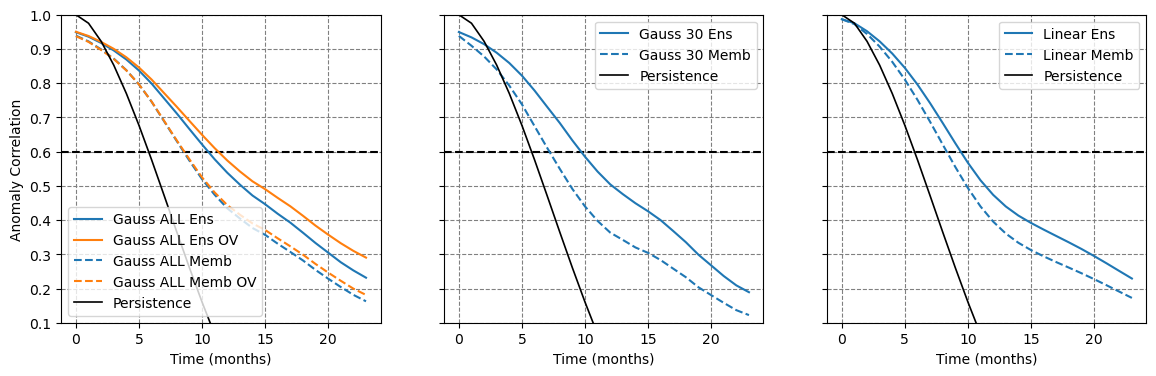

In [101]:
fig, ax = plt.subplots(nrows=1, ncols=3,sharey=True,figsize=(14,4))

xval=range(0,24)

ax[0].axhline(0.6, linestyle='--',color='black')
ax[0].set_xlabel('Time (months)')
ax[0].set_ylabel('Anomaly Correlation')
ax[0].set_ylim([0.1,1.0])
ax[0].set_title('',loc='left')
ax[0].plot(xval, np.mean(GaussALL_mean, axis=1), lw=1.5, label='Gauss ALL Ens')
ax[0].plot(xval, np.mean(GaussALL_mean_OV, axis=1), lw=1.5, label='Gauss ALL Ens OV')
ax[0].set_prop_cycle(None)
ax[0].plot(xval, np.mean(np.mean(GaussALL_ind, axis=1), axis=1), lw=1.5, label='Gauss ALL Memb', linestyle='dashed')
ax[0].plot(xval, np.mean(np.mean(GaussALL_ind_OV, axis=1), axis=1), lw=1.5, label='Gauss ALL Memb OV', linestyle='dashed')
ax[0].plot(xval, CORR_PERS, lw=1.2, label='Persistence', color='black')
ax[0].yaxis.grid(color='gray', linestyle='dashed')
ax[0].xaxis.grid(color='gray', linestyle='dashed')
ax[0].legend(loc='lower left')

ax[1].axhline(0.6, linestyle='--',color='black')
ax[1].set_xlabel('Time (months)')
ax[1].set_ylim([0.1,1.0])
ax[1].set_title('',loc='left')
ax[1].plot(xval, np.mean(Gauss30_mean, axis=1), lw=1.5, label='Gauss 30 Ens')
#ax[1].plot(xval, np.mean(Gauss30_mean_OV, axis=1), lw=1.5, label='Gauss 30 Ens Overlap')
ax[1].set_prop_cycle(None)
ax[1].plot(xval, np.mean(np.mean(Gauss30_ind, axis=1), axis=1), lw=1.5, label='Gauss 30 Memb', linestyle='dashed')
#ax[1].plot(xval, np.mean(np.mean(Gauss30_ind_OV, axis=1), axis=1), lw=1.5, label='Gauss 30 Memb OV', linestyle='dashed')
ax[1].plot(xval, CORR_PERS, lw=1.2, label='Persistence', color='black')
ax[1].yaxis.grid(color='gray', linestyle='dashed')
ax[1].xaxis.grid(color='gray', linestyle='dashed')
ax[1].legend(loc='upper right')

ax[2].axhline(0.6, linestyle='--',color='black')
ax[2].set_xlabel('Time (months)')
ax[2].set_ylim([0.1,1.0])
ax[2].set_title('',loc='left')
ax[2].plot(xval, np.mean(Poly_mean, axis=1), lw=1.5, label='Linear Ens')
#ax[2].plot(xval, np.mean(Poly_mean_OV, axis=1), lw=1.5, label='Linear Ens Overlap')
ax[2].set_prop_cycle(None)
ax[2].plot(xval, np.mean(np.mean(Poly_ind, axis=1), axis=1), lw=1.5, label='Linear Memb', linestyle='dashed')
#ax[2].plot(xval, np.mean(np.mean(Poly_ind_OV, axis=1), axis=1), lw=1.5, label='Linear Memb OV', linestyle='dashed')
ax[2].plot(xval, CORR_PERS, lw=1.2, label='Persistence', color='black')
ax[2].yaxis.grid(color='gray', linestyle='dashed')
ax[2].xaxis.grid(color='gray', linestyle='dashed')
ax[2].legend(loc='upper right')


plt.suptitle('',fontsize='xx-large')
labfile = 'due metodi forecasting MONTHS' + '.pdf'
#plt.savefig(labfile, orientation='landscape',  format='pdf')
plt.show() 

# 15 years

### Tools for the plots

In [133]:
import nc_time_axis

In [134]:
flabel = {'fontsize':14,'fontweight':'bold'}   #,'fontfamily':'Futura'
ftitle = {'fontsize':18,'fontweight':'bold'}   #,'fontfamily':'Futura',

In [135]:
from pylab import *

cmap = cm.get_cmap('plasma', 19)
color_list = [matplotlib.colors.rgb2hex(cmap(i)[:3]) for i in range(cmap.N)]

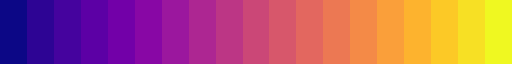

In [136]:
cmap   # First forecasts purple,    last forecasts yellow

### Data preparation

In [137]:
## Load EOFs
PCs=np.load('Processed_data/PCs_CESM_845SST_1000SSH.npy')
EOFs=np.load('Processed_data/EOFs_CESM_845SST_1000SSH.npy')

In [138]:
for_levels=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]
periods=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
periods_150=[0,1,2,3,4,5,6,7,8,9,10,11,12]
lead_times=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]

## ALL GAUSS

In [139]:
mean_av=np.zeros((24,13))
mean_ind=np.zeros((24,10,13))

RMSE_mean_av=np.zeros((24,13))
RMSE_mean_ind=np.zeros((24,10,13))

In [140]:
#Select EOFs
udat_sst=EOFs[:,0:845]

In [141]:
## Compute observations NON truncated to PCs
Xindex=X_tos.A.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))#[:-1]
Xindex

<xarray.DataArray (time: 24000)>
array([-0.07060546,  0.05650981,  0.28544343, ..., -0.9016017 ,
       -0.9271781 , -0.89309406], dtype=float32)
Coordinates:
  * time     (time) object 0001-02-01 00:00:00 ... 2001-01-01 00:00:00
    z_t      float32 500.0
    month    (time) int64 2 3 4 5 6 7 8 9 10 11 12 ... 3 4 5 6 7 8 9 10 11 12 1

In [142]:
tot_for_union=np.empty((10, 845, 24, 24000))
tot_for_union.fill(np.NaN)

In [143]:
for m in lead_times:
    for n in periods_150:
        tot_for_union[:,:,m, m + n*1800 : m + n*1800 +1776]=np.load(f'150 years testing/150 years testing-Forecasts 15/ALLEOFs_forecast_p{n}.npy')[:,0:845,m,:]

In [144]:
tot_for_union.shape

(10, 845, 24, 24000)

In [145]:
for m in periods_150:

    Xindex1=Xindex.isel(time=slice(0+150*12*m,150*12+150*12*m))
    X_tos1=X_tos.A[:,0+150*12*m:150*12+150*12*m]
    
    tot_for_union1=tot_for_union[:,:,:,0+150*12*m:150*12+150*12*m]
    print('Period ', m, '  forecast: ',m*2)
    
    for n in lead_times:
    
        lead=n
    
        # Compute average forecast
        av_for=np.nanmean(tot_for_union1, axis=0)
        av_for_geo_array=udat_sst @ av_for[0:845,lead,:]            
        av_for_geo = xr.full_like(X_tos1[:,:],0)
        av_for_geo.data=av_for_geo_array.real
        Avindex=av_for_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))

        #Correlation average forecast and observations
        mean_av[lead,m]=np.corrcoef(Xindex1[np.invert(np.isnan(Avindex))],Avindex[np.invert(np.isnan(Avindex))])[0,1]
        RMSE_mean_av[lead,m]=1-np.sqrt(np.square(np.subtract(Xindex1[np.invert(np.isnan(Avindex))],Avindex[np.invert(np.isnan(Avindex))])).mean()) / np.std(Xindex1[np.invert(np.isnan(Avindex))])
        print("Lead ", n, " ensemble mean correlation ",mean_av[lead,m])
    
        #Average correlation between individual forecast and observations
        for i in range(10):  
            phix_geo_array=udat_sst @ tot_for_union1[i,0:845,lead,:]  
            phix_geo = xr.full_like(X_tos1[:,:],0)
            phix_geo.data=phix_geo_array.real
            Phiindex=phix_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))

            mean_ind[lead,i,m]=np.corrcoef(Xindex1[np.invert(np.isnan(Phiindex))],Phiindex[np.invert(np.isnan(Phiindex))])[0,1]
            RMSE_mean_ind[lead,i,m]= 1-np.sqrt(np.square(np.subtract(Xindex1[np.invert(np.isnan(Phiindex))],Phiindex[np.invert(np.isnan(Phiindex))])).mean()) / np.std(Xindex1[np.invert(np.isnan(Phiindex))])
            
        av_corr=np.mean(mean_ind[lead,:,m], axis=0)
        print("Lead ", n, " ensemble member correlation ",av_corr)
        
        
'''        #Plot
        import nc_time_axis
    
        fig, ax = plt.subplots(1, 1, figsize=(16,3.5),squeeze=False)
    
        Xindex1.plot(label='Untruncated Obs',lw=1.2,color='gray')
    
        for i in range(3):  
            #Expand forecast to geographical domain
            phix_geo_array=udat_sst @ tot_for_union1[i,0:845,lead,:]  
            phix_geo = xr.full_like(X_tos1[:,:],0)
            phix_geo.data=phix_geo_array.real
    
            Phiindex=phix_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))
            Phiindex.plot(lw=0.5, color='red', alpha=0.4)
    
        Avindex.plot(label='Average forecast',lw=0.8,color='blue')

        plt.axhline(0,color='black',lw=0.5)
        plt.title(f'NINO3.4 forecast Lead {lead}',ftitle)
        plt.title(f'Gaussian Kernel',loc='left',**flabel)
        plt.xlabel(' ')
        plt.legend(loc='upper right')
        zmap.changebox(plt.gca(),'all',linewidth=1.5)
        #loctime = Xindex1.sel(time='1-JAN-2000').time.data
        cstr1 = f' Corr aver. for: {mean_av[lead,m]:>.2f}'
        cstr2 = f' Aver. corr of ind. for: {av_corr:>.2f}'
        loctime = Xindex1.isel(time=450).time.data
        plt.text(loctime,-2.1,cstr1)
        plt.text(loctime,-2.3,cstr2)
        #labfile =  f'{data_name}{case}_NINO3BANDA_{KK.kernel_choice}{tolone}.pdf'
        #plt.savefig(labfile, orientation='landscape',  format='pdf')
        plt.show()'''


Period  0   forecast:  0
Lead  0  ensemble mean correlation  0.9250560787655728
Lead  0  ensemble member correlation  0.9010100411225623
Lead  1  ensemble mean correlation  0.9097984925418143
Lead  1  ensemble member correlation  0.878852729082125
Lead  2  ensemble mean correlation  0.8891593936993101
Lead  2  ensemble member correlation  0.8498402932953771
Lead  3  ensemble mean correlation  0.8669029544741494
Lead  3  ensemble member correlation  0.8188039935585822
Lead  4  ensemble mean correlation  0.8384407506409155
Lead  4  ensemble member correlation  0.7771976216573679
Lead  5  ensemble mean correlation  0.8027510792477032
Lead  5  ensemble member correlation  0.7239913302260722
Lead  6  ensemble mean correlation  0.7618291051111133
Lead  6  ensemble member correlation  0.6644466796820688
Lead  7  ensemble mean correlation  0.7175857706542834
Lead  7  ensemble member correlation  0.5923610179739021
Lead  8  ensemble mean correlation  0.6702653579757221
Lead  8  ensemble member 

"        #Plot\n        import nc_time_axis\n    \n        fig, ax = plt.subplots(1, 1, figsize=(16,3.5),squeeze=False)\n    \n        Xindex1.plot(label='Untruncated Obs',lw=1.2,color='gray')\n    \n        for i in range(3):  \n            #Expand forecast to geographical domain\n            phix_geo_array=udat_sst @ tot_for_union1[i,0:845,lead,:]  \n            phix_geo = xr.full_like(X_tos1[:,:],0)\n            phix_geo.data=phix_geo_array.real\n    \n            Phiindex=phix_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))\n            Phiindex.plot(lw=0.5, color='red', alpha=0.4)\n    \n        Avindex.plot(label='Average forecast',lw=0.8,color='blue')\n\n        plt.axhline(0,color='black',lw=0.5)\n        plt.title(f'NINO3.4 forecast Lead {lead}',ftitle)\n        plt.title(f'Gaussian Kernel',loc='left',**flabel)\n        plt.xlabel(' ')\n        plt.legend(loc='upper right')\n        zmap.changebox(plt.gca(),'all',linewidth=1.5)\n        #loctime =

In [146]:
np.save('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEAN_CORR_GAUSSALL_15', mean_av, allow_pickle=True, fix_imports=True)
np.save('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEMBERS_CORR_GAUSSALL_15', mean_ind, allow_pickle=True, fix_imports=True)
np.save('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEAN_RMSE_GAUSSALL_15', RMSE_mean_av, allow_pickle=True, fix_imports=True)
np.save('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEMBERS_RMSE_GAUSSALL_15', RMSE_mean_ind, allow_pickle=True, fix_imports=True)

## ALL GAUSS OV

In [51]:
mean_av=np.zeros((24,13))
mean_ind=np.zeros((24,19,13))

RMSE_mean_av=np.zeros((24,13))
RMSE_mean_ind=np.zeros((24,19,13))

In [52]:
#Select EOFs
udat_sst=EOFs[:,0:845]

In [53]:
## Compute observations NON truncated to PCs
Xindex=X_tos.A.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))#[:-1]
Xindex

<xarray.DataArray (time: 24000)>
array([-0.07060546,  0.05650981,  0.28544343, ..., -0.9016017 ,
       -0.9271781 , -0.89309406], dtype=float32)
Coordinates:
  * time     (time) object 0001-02-01 00:00:00 ... 2001-01-01 00:00:00
    z_t      float32 500.0
    month    (time) int64 2 3 4 5 6 7 8 9 10 11 12 ... 3 4 5 6 7 8 9 10 11 12 1

In [54]:
tot_for_union=np.empty((19, 845, 24, 24000))
tot_for_union.fill(np.NaN)

In [55]:
for m in lead_times:
    for n in periods_150:
        tot_for_union[0:10,:,m, m + n*1800 : m + n*1800 +1776]=np.load(f'150 years testing/150 years testing-Forecasts 15/ALLEOFs_forecast_p{n}.npy')[:,0:845,m,:]

In [56]:
for m in lead_times:
    for n in periods_150:
        tot_for_union[10:19,:,m, m + n*1800 : m + n*1800 +1776]=np.load(f'150 years testing/150 years testing-Forecasts 15/ALLEOFs_forecast_p{n}_OV.npy')[:,0:845,m,:]

In [57]:
for m in periods_150:

    Xindex1=Xindex.isel(time=slice(0+150*12*m,150*12+150*12*m))
    X_tos1=X_tos.A[:,0+150*12*m:150*12+150*12*m]
    
    tot_for_union1=tot_for_union[:,:,:,0+150*12*m:150*12+150*12*m]
    print('Period ', m, '  forecast: ',m*2)
    
    for n in lead_times:
    
        lead=n
    
        # Compute average forecast
        av_for=np.nanmean(tot_for_union1, axis=0)
        av_for_geo_array=udat_sst @ av_for[0:845,lead,:]            
        av_for_geo = xr.full_like(X_tos1[:,:],0)
        av_for_geo.data=av_for_geo_array.real
        Avindex=av_for_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))

        #Correlation average forecast and observations
        mean_av[lead,m]=np.corrcoef(Xindex1[np.invert(np.isnan(Avindex))],Avindex[np.invert(np.isnan(Avindex))])[0,1]
        RMSE_mean_av[lead,m]=1-np.sqrt(np.square(np.subtract(Xindex1[np.invert(np.isnan(Avindex))],Avindex[np.invert(np.isnan(Avindex))])).mean()) / np.std(Xindex1[np.invert(np.isnan(Avindex))])
        print("Lead ", n, " ensemble mean correlation ",mean_av[lead,m])
    
        #Average correlation between individual forecast and observations
        for i in range(19):  
            phix_geo_array=udat_sst @ tot_for_union1[i,0:845,lead,:]  
            phix_geo = xr.full_like(X_tos1[:,:],0)
            phix_geo.data=phix_geo_array.real
            Phiindex=phix_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))

            mean_ind[lead,i,m]=np.corrcoef(Xindex1[np.invert(np.isnan(Phiindex))],Phiindex[np.invert(np.isnan(Phiindex))])[0,1]
            RMSE_mean_ind[lead,i,m]= 1-np.sqrt(np.square(np.subtract(Xindex1[np.invert(np.isnan(Phiindex))],Phiindex[np.invert(np.isnan(Phiindex))])).mean()) / np.std(Xindex1[np.invert(np.isnan(Phiindex))])
            
        av_corr=np.mean(mean_ind[lead,:,m], axis=0)
        print("Lead ", n, " ensemble member correlation ",av_corr)
        
        
'''        #Plot
        import nc_time_axis
    
        fig, ax = plt.subplots(1, 1, figsize=(16,3.5),squeeze=False)
    
        Xindex1.plot(label='Untruncated Obs',lw=1.2,color='gray')
    
        for i in range(3):  
            #Expand forecast to geographical domain
            phix_geo_array=udat_sst @ tot_for_union1[i,0:845,lead,:]  
            phix_geo = xr.full_like(X_tos1[:,:],0)
            phix_geo.data=phix_geo_array.real
    
            Phiindex=phix_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))
            Phiindex.plot(lw=0.5, color='red', alpha=0.4)
    
        Avindex.plot(label='Average forecast',lw=0.8,color='blue')

        plt.axhline(0,color='black',lw=0.5)
        plt.title(f'NINO3.4 forecast Lead {lead}',ftitle)
        plt.title(f'Gaussian Kernel',loc='left',**flabel)
        plt.xlabel(' ')
        plt.legend(loc='upper right')
        zmap.changebox(plt.gca(),'all',linewidth=1.5)
        #loctime = Xindex1.sel(time='1-JAN-2000').time.data
        cstr1 = f' Corr aver. for: {mean_av[lead,m]:>.2f}'
        cstr2 = f' Aver. corr of ind. for: {av_corr:>.2f}'
        loctime = Xindex1.isel(time=450).time.data
        plt.text(loctime,-2.1,cstr1)
        plt.text(loctime,-2.3,cstr2)
        #labfile =  f'{data_name}{case}_NINO3BANDA_{KK.kernel_choice}{tolone}.pdf'
        #plt.savefig(labfile, orientation='landscape',  format='pdf')
        plt.show()'''


Period  0   forecast:  0
Lead  0  ensemble mean correlation  0.9265291338201886
Lead  0  ensemble member correlation  0.9005386152221675
Lead  1  ensemble mean correlation  0.9121640944601639
Lead  1  ensemble member correlation  0.8773093721439018
Lead  2  ensemble mean correlation  0.8918209237260489
Lead  2  ensemble member correlation  0.8460986202546491
Lead  3  ensemble mean correlation  0.8693841197960046
Lead  3  ensemble member correlation  0.8141821365703471
Lead  4  ensemble mean correlation  0.8403171873538653
Lead  4  ensemble member correlation  0.7699429852167123
Lead  5  ensemble mean correlation  0.804787174707127
Lead  5  ensemble member correlation  0.7166005936886639
Lead  6  ensemble mean correlation  0.7641808624659294
Lead  6  ensemble member correlation  0.6558801962859985
Lead  7  ensemble mean correlation  0.7215558681285683
Lead  7  ensemble member correlation  0.582998528207607
Lead  8  ensemble mean correlation  0.6751463431839987
Lead  8  ensemble member c

"        #Plot\n        import nc_time_axis\n    \n        fig, ax = plt.subplots(1, 1, figsize=(16,3.5),squeeze=False)\n    \n        Xindex1.plot(label='Untruncated Obs',lw=1.2,color='gray')\n    \n        for i in range(3):  \n            #Expand forecast to geographical domain\n            phix_geo_array=udat_sst @ tot_for_union1[i,0:845,lead,:]  \n            phix_geo = xr.full_like(X_tos1[:,:],0)\n            phix_geo.data=phix_geo_array.real\n    \n            Phiindex=phix_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))\n            Phiindex.plot(lw=0.5, color='red', alpha=0.4)\n    \n        Avindex.plot(label='Average forecast',lw=0.8,color='blue')\n\n        plt.axhline(0,color='black',lw=0.5)\n        plt.title(f'NINO3.4 forecast Lead {lead}',ftitle)\n        plt.title(f'Gaussian Kernel',loc='left',**flabel)\n        plt.xlabel(' ')\n        plt.legend(loc='upper right')\n        zmap.changebox(plt.gca(),'all',linewidth=1.5)\n        #loctime =

In [58]:
np.save('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEAN_CORR_GAUSALL_15_OV', mean_av, allow_pickle=True, fix_imports=True)
np.save('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEMBERS_CORR_GAUSALL_15_OV', mean_ind, allow_pickle=True, fix_imports=True)
np.save('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEAN_RMSE_GAUSALL_15_OV', RMSE_mean_av, allow_pickle=True, fix_imports=True)
np.save('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEMBERS_RMSE_GAUSALL_15_OV', RMSE_mean_ind, allow_pickle=True, fix_imports=True)

## 30 POLY

In [157]:
mean_av=np.zeros((24,13))
mean_ind=np.zeros((24,10,13))

RMSE_mean_av=np.zeros((24,13))
RMSE_mean_ind=np.zeros((24,10,13))

In [158]:
#Select EOFs
udat_sst=EOFs[:,0:20]

In [159]:
## Compute observations NON truncated to PCs
Xindex=X_tos.A.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))#[:-1]
Xindex

<xarray.DataArray (time: 24000)>
array([-0.07060546,  0.05650981,  0.28544343, ..., -0.9016017 ,
       -0.9271781 , -0.89309406], dtype=float32)
Coordinates:
  * time     (time) object 0001-02-01 00:00:00 ... 2001-01-01 00:00:00
    z_t      float32 500.0
    month    (time) int64 2 3 4 5 6 7 8 9 10 11 12 ... 3 4 5 6 7 8 9 10 11 12 1

In [160]:
tot_for_union=np.empty((10, 20, 24, 24000))
tot_for_union.fill(np.NaN)

In [161]:
for m in lead_times:
    for n in periods_150:
        tot_for_union[:,:,m, m + n*1800 : m + n*1800 +1776]=np.load(f'150 years testing/150 years testing-Forecasts 15/POLY_forecast_p{n}.npy')[:,0:20,m,:]

In [162]:
for m in periods_150:

    Xindex1=Xindex.isel(time=slice(0+150*12*m,150*12+150*12*m))
    X_tos1=X_tos.A[:,0+150*12*m:150*12+150*12*m]
    
    tot_for_union1=tot_for_union[:,:,:,0+150*12*m:150*12+150*12*m]
    print('Period ', m, '  forecast: ',m*2)
    
    for n in lead_times:
    
        lead=n
    
        # Compute average forecast
        av_for=np.nanmean(tot_for_union1, axis=0)
        av_for_geo_array=udat_sst @ av_for[0:20,lead,:]            
        av_for_geo = xr.full_like(X_tos1[:,:],0)
        av_for_geo.data=av_for_geo_array.real
        Avindex=av_for_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))

        #Correlation average forecast and observations
        mean_av[lead,m]=np.corrcoef(Xindex1[np.invert(np.isnan(Avindex))],Avindex[np.invert(np.isnan(Avindex))])[0,1]
        RMSE_mean_av[lead,m]=1-np.sqrt(np.square(np.subtract(Xindex1[np.invert(np.isnan(Avindex))],Avindex[np.invert(np.isnan(Avindex))])).mean()) / np.std(Xindex1[np.invert(np.isnan(Avindex))])
        print("Lead ", n, " ensemble mean correlation ",mean_av[lead,m])
    
        #Average correlation between individual forecast and observations
        for i in range(10):  
            phix_geo_array=udat_sst @ tot_for_union1[i,0:20,lead,:]  
            phix_geo = xr.full_like(X_tos1[:,:],0)
            phix_geo.data=phix_geo_array.real
            Phiindex=phix_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))

            mean_ind[lead,i,m]=np.corrcoef(Xindex1[np.invert(np.isnan(Phiindex))],Phiindex[np.invert(np.isnan(Phiindex))])[0,1]
            RMSE_mean_ind[lead,i,m]= 1-np.sqrt(np.square(np.subtract(Xindex1[np.invert(np.isnan(Phiindex))],Phiindex[np.invert(np.isnan(Phiindex))])).mean()) / np.std(Xindex1[np.invert(np.isnan(Phiindex))])
            
        av_corr=np.mean(mean_ind[lead,:,m], axis=0)
        print("Lead ", n, " ensemble member correlation ",av_corr)
        
        
'''        #Plot
        import nc_time_axis
    
        fig, ax = plt.subplots(1, 1, figsize=(16,3.5),squeeze=False)
    
        Xindex1.plot(label='Untruncated Obs',lw=1.2,color='gray')
    
        for i in range(3):  
            #Expand forecast to geographical domain
            phix_geo_array=udat_sst @ tot_for_union1[i,0:20,lead,:]  
            phix_geo = xr.full_like(X_tos1[:,:],0)
            phix_geo.data=phix_geo_array.real
    
            Phiindex=phix_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))
            Phiindex.plot(lw=0.5, color='red', alpha=0.4)
    
        Avindex.plot(label='Average forecast',lw=0.8,color='blue')

        plt.axhline(0,color='black',lw=0.5)
        plt.title(f'NINO3.4 forecast Lead {lead}',ftitle)
        plt.title(f'Gaussian Kernel',loc='left',**flabel)
        plt.xlabel(' ')
        plt.legend(loc='upper right')
        zmap.changebox(plt.gca(),'all',linewidth=1.5)
        #loctime = Xindex1.sel(time='1-JAN-2000').time.data
        cstr1 = f' Corr aver. for: {mean_av[lead,m]:>.2f}'
        cstr2 = f' Aver. corr of ind. for: {av_corr:>.2f}'
        loctime = Xindex1.isel(time=450).time.data
        plt.text(loctime,-2.1,cstr1)
        plt.text(loctime,-2.3,cstr2)
        #labfile =  f'{data_name}{case}_NINO3BANDA_{KK.kernel_choice}{tolone}.pdf'
        #plt.savefig(labfile, orientation='landscape',  format='pdf')
        plt.show()'''


Period  0   forecast:  0
Lead  0  ensemble mean correlation  0.9868577389493081
Lead  0  ensemble member correlation  0.986825187688714
Lead  1  ensemble mean correlation  0.9740335134694326
Lead  1  ensemble member correlation  0.9634176163799889
Lead  2  ensemble mean correlation  0.948539811617372
Lead  2  ensemble member correlation  0.9197756370492355
Lead  3  ensemble mean correlation  0.917671724002099
Lead  3  ensemble member correlation  0.8685807595277394
Lead  4  ensemble mean correlation  0.8812148503021838
Lead  4  ensemble member correlation  0.8105113675125514
Lead  5  ensemble mean correlation  0.8387668183109861
Lead  5  ensemble member correlation  0.7461909404656571
Lead  6  ensemble mean correlation  0.7897446401983204
Lead  6  ensemble member correlation  0.6767991880452402
Lead  7  ensemble mean correlation  0.7348352539587084
Lead  7  ensemble member correlation  0.6048244056481743
Lead  8  ensemble mean correlation  0.6746648258157816
Lead  8  ensemble member co

"        #Plot\n        import nc_time_axis\n    \n        fig, ax = plt.subplots(1, 1, figsize=(16,3.5),squeeze=False)\n    \n        Xindex1.plot(label='Untruncated Obs',lw=1.2,color='gray')\n    \n        for i in range(3):  \n            #Expand forecast to geographical domain\n            phix_geo_array=udat_sst @ tot_for_union1[i,0:20,lead,:]  \n            phix_geo = xr.full_like(X_tos1[:,:],0)\n            phix_geo.data=phix_geo_array.real\n    \n            Phiindex=phix_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))\n            Phiindex.plot(lw=0.5, color='red', alpha=0.4)\n    \n        Avindex.plot(label='Average forecast',lw=0.8,color='blue')\n\n        plt.axhline(0,color='black',lw=0.5)\n        plt.title(f'NINO3.4 forecast Lead {lead}',ftitle)\n        plt.title(f'Gaussian Kernel',loc='left',**flabel)\n        plt.xlabel(' ')\n        plt.legend(loc='upper right')\n        zmap.changebox(plt.gca(),'all',linewidth=1.5)\n        #loctime = 

In [163]:
np.save('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEAN_CORR_POLY_15', mean_av, allow_pickle=True, fix_imports=True)
np.save('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEMBERS_CORR_POLY_15', mean_ind, allow_pickle=True, fix_imports=True)
np.save('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEAN_RMSE_POLY_15', RMSE_mean_av, allow_pickle=True, fix_imports=True)
np.save('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEMBERS_RMSE_POLY_15', RMSE_mean_ind, allow_pickle=True, fix_imports=True)

## 30 POLY OV

In [30]:
mean_av=np.zeros((24,13))
mean_ind=np.zeros((24,19,13))

RMSE_mean_av=np.zeros((24,13))
RMSE_mean_ind=np.zeros((24,19,13))

In [31]:
#Select EOFs
udat_sst=EOFs[:,0:20]

In [32]:
## Compute observations NON truncated to PCs
Xindex=X_tos.A.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))#[:-1]
Xindex

<xarray.DataArray (time: 24000)>
array([-0.07060546,  0.05650981,  0.28544343, ..., -0.9016017 ,
       -0.9271781 , -0.89309406], dtype=float32)
Coordinates:
  * time     (time) object 0001-02-01 00:00:00 ... 2001-01-01 00:00:00
    z_t      float32 500.0
    month    (time) int64 2 3 4 5 6 7 8 9 10 11 12 ... 3 4 5 6 7 8 9 10 11 12 1

In [33]:
tot_for_union=np.empty((19, 20, 24, 24000))
tot_for_union.fill(np.NaN)

In [35]:
for m in lead_times:
    for n in periods_150:
        tot_for_union[0:10,:,m, m + n*1800 : m + n*1800 +1776]=np.load(f'150 years testing/150 years testing-Forecasts 15/POLY_forecast_p{n}.npy')[:,0:20,m,:]

In [36]:
for m in lead_times:
    for n in periods_150:
        tot_for_union[10:19,:,m, m + n*1800 : m + n*1800 +1776]=np.load(f'150 years testing/150 years testing-Forecasts 15/POLY_forecast_p{n}_OV.npy')[:,0:20,m,:]

In [37]:
for m in periods_150:

    Xindex1=Xindex.isel(time=slice(0+150*12*m,150*12+150*12*m))
    X_tos1=X_tos.A[:,0+150*12*m:150*12+150*12*m]
    
    tot_for_union1=tot_for_union[:,:,:,0+150*12*m:150*12+150*12*m]
    print('Period ', m, '  forecast: ',m*2)
    
    for n in lead_times:
    
        lead=n
    
        # Compute average forecast
        av_for=np.nanmean(tot_for_union1, axis=0)
        av_for_geo_array=udat_sst @ av_for[0:20,lead,:]            
        av_for_geo = xr.full_like(X_tos1[:,:],0)
        av_for_geo.data=av_for_geo_array.real
        Avindex=av_for_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))

        #Correlation average forecast and observations
        mean_av[lead,m]=np.corrcoef(Xindex1[np.invert(np.isnan(Avindex))],Avindex[np.invert(np.isnan(Avindex))])[0,1]
        RMSE_mean_av[lead,m]=1-np.sqrt(np.square(np.subtract(Xindex1[np.invert(np.isnan(Avindex))],Avindex[np.invert(np.isnan(Avindex))])).mean()) / np.std(Xindex1[np.invert(np.isnan(Avindex))])
        print("Lead ", n, " ensemble mean correlation ",mean_av[lead,m])
    
        #Average correlation between individual forecast and observations
        for i in range(19):  
            phix_geo_array=udat_sst @ tot_for_union1[i,0:20,lead,:]  
            phix_geo = xr.full_like(X_tos1[:,:],0)
            phix_geo.data=phix_geo_array.real
            Phiindex=phix_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))

            mean_ind[lead,i,m]=np.corrcoef(Xindex1[np.invert(np.isnan(Phiindex))],Phiindex[np.invert(np.isnan(Phiindex))])[0,1]
            RMSE_mean_ind[lead,i,m]= 1-np.sqrt(np.square(np.subtract(Xindex1[np.invert(np.isnan(Phiindex))],Phiindex[np.invert(np.isnan(Phiindex))])).mean()) / np.std(Xindex1[np.invert(np.isnan(Phiindex))])
            
        av_corr=np.mean(mean_ind[lead,:,m], axis=0)
        print("Lead ", n, " ensemble member correlation ",av_corr)
        
        
'''        #Plot
        import nc_time_axis
    
        fig, ax = plt.subplots(1, 1, figsize=(16,3.5),squeeze=False)
    
        Xindex1.plot(label='Untruncated Obs',lw=1.2,color='gray')
    
        for i in range(3):  
            #Expand forecast to geographical domain
            phix_geo_array=udat_sst @ tot_for_union1[i,0:20,lead,:]  
            phix_geo = xr.full_like(X_tos1[:,:],0)
            phix_geo.data=phix_geo_array.real
    
            Phiindex=phix_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))
            Phiindex.plot(lw=0.5, color='red', alpha=0.4)
    
        Avindex.plot(label='Average forecast',lw=0.8,color='blue')

        plt.axhline(0,color='black',lw=0.5)
        plt.title(f'NINO3.4 forecast Lead {lead}',ftitle)
        plt.title(f'Gaussian Kernel',loc='left',**flabel)
        plt.xlabel(' ')
        plt.legend(loc='upper right')
        zmap.changebox(plt.gca(),'all',linewidth=1.5)
        #loctime = Xindex1.sel(time='1-JAN-2000').time.data
        cstr1 = f' Corr aver. for: {mean_av[lead,m]:>.2f}'
        cstr2 = f' Aver. corr of ind. for: {av_corr:>.2f}'
        loctime = Xindex1.isel(time=450).time.data
        plt.text(loctime,-2.1,cstr1)
        plt.text(loctime,-2.3,cstr2)
        #labfile =  f'{data_name}{case}_NINO3BANDA_{KK.kernel_choice}{tolone}.pdf'
        #plt.savefig(labfile, orientation='landscape',  format='pdf')
        plt.show()'''


Period  0   forecast:  0
Lead  0  ensemble mean correlation  0.9868577389493081
Lead  0  ensemble member correlation  0.9868739896536622
Lead  1  ensemble mean correlation  0.9738761038600162
Lead  1  ensemble member correlation  0.9647038716461556
Lead  2  ensemble mean correlation  0.9477353471543283
Lead  2  ensemble member correlation  0.9228000394870184
Lead  3  ensemble mean correlation  0.9162110690227693
Lead  3  ensemble member correlation  0.8731835550198433
Lead  4  ensemble mean correlation  0.8796416274192025
Lead  4  ensemble member correlation  0.81687875816854
Lead  5  ensemble mean correlation  0.837835851999024
Lead  5  ensemble member correlation  0.7545850949348406
Lead  6  ensemble mean correlation  0.7906355731024374
Lead  6  ensemble member correlation  0.6876015521307836
Lead  7  ensemble mean correlation  0.7389210177690853
Lead  7  ensemble member correlation  0.6182524408175931
Lead  8  ensemble mean correlation  0.6833906131080048
Lead  8  ensemble member co

"        #Plot\n        import nc_time_axis\n    \n        fig, ax = plt.subplots(1, 1, figsize=(16,3.5),squeeze=False)\n    \n        Xindex1.plot(label='Untruncated Obs',lw=1.2,color='gray')\n    \n        for i in range(3):  \n            #Expand forecast to geographical domain\n            phix_geo_array=udat_sst @ tot_for_union1[i,0:20,lead,:]  \n            phix_geo = xr.full_like(X_tos1[:,:],0)\n            phix_geo.data=phix_geo_array.real\n    \n            Phiindex=phix_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))\n            Phiindex.plot(lw=0.5, color='red', alpha=0.4)\n    \n        Avindex.plot(label='Average forecast',lw=0.8,color='blue')\n\n        plt.axhline(0,color='black',lw=0.5)\n        plt.title(f'NINO3.4 forecast Lead {lead}',ftitle)\n        plt.title(f'Gaussian Kernel',loc='left',**flabel)\n        plt.xlabel(' ')\n        plt.legend(loc='upper right')\n        zmap.changebox(plt.gca(),'all',linewidth=1.5)\n        #loctime = 

In [38]:
np.save('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEAN_CORR_POLY_15_OV', mean_av, allow_pickle=True, fix_imports=True)
np.save('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEMBERS_CORR_POLY_15_OV', mean_ind, allow_pickle=True, fix_imports=True)
np.save('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEAN_RMSE_POLY_15_OV', RMSE_mean_av, allow_pickle=True, fix_imports=True)
np.save('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEMBERS_RMSE_POLY_15_OV', RMSE_mean_ind, allow_pickle=True, fix_imports=True)

In [100]:
RMSE_PERS=np.load('Forecasts 100/Skill metrics/PERSISTENCE_RMSE.npy')
CORR_PERS=np.load('Forecasts 100/Skill metrics/PERSISTENCE_CORR.npy')

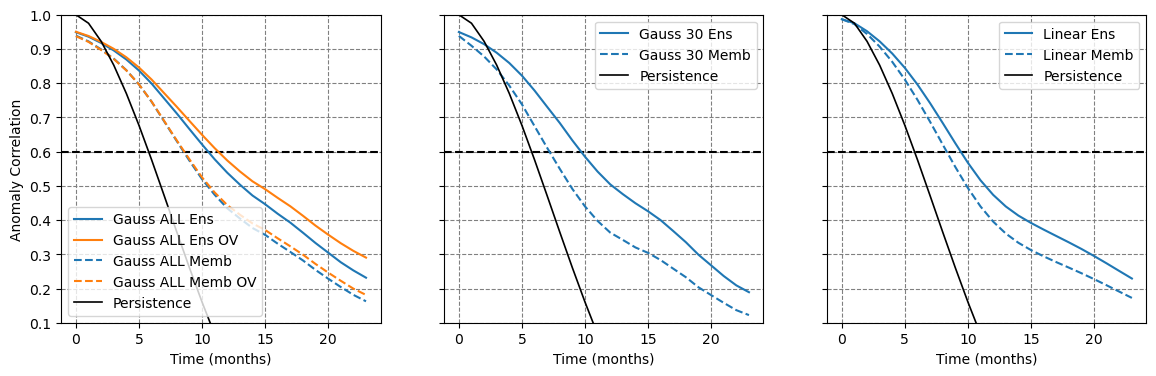

In [101]:
fig, ax = plt.subplots(nrows=1, ncols=3,sharey=True,figsize=(14,4))

xval=range(0,24)

ax[0].axhline(0.6, linestyle='--',color='black')
ax[0].set_xlabel('Time (months)')
ax[0].set_ylabel('Anomaly Correlation')
ax[0].set_ylim([0.1,1.0])
ax[0].set_title('',loc='left')
ax[0].plot(xval, np.mean(GaussALL_mean, axis=1), lw=1.5, label='Gauss ALL Ens')
ax[0].plot(xval, np.mean(GaussALL_mean_OV, axis=1), lw=1.5, label='Gauss ALL Ens OV')
ax[0].set_prop_cycle(None)
ax[0].plot(xval, np.mean(np.mean(GaussALL_ind, axis=1), axis=1), lw=1.5, label='Gauss ALL Memb', linestyle='dashed')
ax[0].plot(xval, np.mean(np.mean(GaussALL_ind_OV, axis=1), axis=1), lw=1.5, label='Gauss ALL Memb OV', linestyle='dashed')
ax[0].plot(xval, CORR_PERS, lw=1.2, label='Persistence', color='black')
ax[0].yaxis.grid(color='gray', linestyle='dashed')
ax[0].xaxis.grid(color='gray', linestyle='dashed')
ax[0].legend(loc='lower left')

ax[1].axhline(0.6, linestyle='--',color='black')
ax[1].set_xlabel('Time (months)')
ax[1].set_ylim([0.1,1.0])
ax[1].set_title('',loc='left')
ax[1].plot(xval, np.mean(Gauss30_mean, axis=1), lw=1.5, label='Gauss 30 Ens')
#ax[1].plot(xval, np.mean(Gauss30_mean_OV, axis=1), lw=1.5, label='Gauss 30 Ens Overlap')
ax[1].set_prop_cycle(None)
ax[1].plot(xval, np.mean(np.mean(Gauss30_ind, axis=1), axis=1), lw=1.5, label='Gauss 30 Memb', linestyle='dashed')
#ax[1].plot(xval, np.mean(np.mean(Gauss30_ind_OV, axis=1), axis=1), lw=1.5, label='Gauss 30 Memb OV', linestyle='dashed')
ax[1].plot(xval, CORR_PERS, lw=1.2, label='Persistence', color='black')
ax[1].yaxis.grid(color='gray', linestyle='dashed')
ax[1].xaxis.grid(color='gray', linestyle='dashed')
ax[1].legend(loc='upper right')

ax[2].axhline(0.6, linestyle='--',color='black')
ax[2].set_xlabel('Time (months)')
ax[2].set_ylim([0.1,1.0])
ax[2].set_title('',loc='left')
ax[2].plot(xval, np.mean(Poly_mean, axis=1), lw=1.5, label='Linear Ens')
#ax[2].plot(xval, np.mean(Poly_mean_OV, axis=1), lw=1.5, label='Linear Ens Overlap')
ax[2].set_prop_cycle(None)
ax[2].plot(xval, np.mean(np.mean(Poly_ind, axis=1), axis=1), lw=1.5, label='Linear Memb', linestyle='dashed')
#ax[2].plot(xval, np.mean(np.mean(Poly_ind_OV, axis=1), axis=1), lw=1.5, label='Linear Memb OV', linestyle='dashed')
ax[2].plot(xval, CORR_PERS, lw=1.2, label='Persistence', color='black')
ax[2].yaxis.grid(color='gray', linestyle='dashed')
ax[2].xaxis.grid(color='gray', linestyle='dashed')
ax[2].legend(loc='upper right')


plt.suptitle('',fontsize='xx-large')
labfile = 'due metodi forecasting MONTHS' + '.pdf'
#plt.savefig(labfile, orientation='landscape',  format='pdf')
plt.show() 

# Fig 10

In [25]:
RMSE_PERS=np.load('Forecasts 100/Skill metrics/PERSISTENCE_RMSE.npy')
CORR_PERS=np.load('Forecasts 100/Skill metrics/PERSISTENCE_CORR.npy')

In [26]:
Poly_mean_75=np.load('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEAN_CORR_POLY_75.npy')
#Gauss30_mean_75=np.load('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEAN_CORR_GAUSS30_75.npy')
GaussALL_mean_75=np.load('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEAN_CORR_GAUSSALL_75.npy')

Poly_mean_75_OV=np.load('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEAN_CORR_POLY_75_OV.npy')
#Gauss30_mean_75=np.load('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEAN_CORR_GAUSS30_75.npy')
GaussALL_mean_75_OV=np.load('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEAN_CORR_GAUSSALL_75_OV.npy')

In [27]:
Poly_mean_50=np.load('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEAN_CORR_POLY_50.npy')
#Gauss30_mean_50=np.load('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEAN_CORR_GAUSS30_50.npy')
GaussALL_mean_50=np.load('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEAN_CORR_GAUSSALL_50.npy')

Poly_mean_50_OV=np.load('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEAN_CORR_POLY_50_OV.npy')
#Gauss30_mean_50=np.load('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEAN_CORR_GAUSS30_50.npy')
GaussALL_mean_50_OV=np.load('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEAN_CORR_GAUSSALL_50_OV.npy')

In [28]:
Poly_mean_30=np.load('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEAN_CORR_POLY_30.npy')
#Gauss30_mean_30=np.load('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEAN_CORR_GAUSS30_30.npy')
GaussALL_mean_30=np.load('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEAN_CORR_GAUSSALL_30.npy')

Poly_mean_30_OV=np.load('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEAN_CORR_POLY_30_OV.npy')
#Gauss30_mean_30=np.load('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEAN_CORR_GAUSS30_30.npy')
GaussALL_mean_30_OV=np.load('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEAN_CORR_GAUSSALL_30_OV.npy')

In [29]:
Poly_mean_25=np.load('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEAN_CORR_POLY_25.npy')
#Gauss30_mean_30=np.load('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEAN_CORR_GAUSS30_30.npy')
GaussALL_mean_25=np.load('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEAN_CORR_GAUSSALL_25.npy')

Poly_mean_25_OV=np.load('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEAN_CORR_POLY_25_OV.npy')
#Gauss30_mean_30=np.load('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEAN_CORR_GAUSS30_30.npy')
GaussALL_mean_25_OV=np.load('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEAN_CORR_GAUSALL_25_OV.npy')

In [30]:
Poly_mean_15=np.load('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEAN_CORR_POLY_15.npy')
#Gauss30_mean_30=np.load('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEAN_CORR_GAUSS30_30.npy')
GaussALL_mean_15=np.load('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEAN_CORR_GAUSSALL_15.npy')

Poly_mean_15_OV=np.load('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEAN_CORR_POLY_25_OV.npy')
#Gauss30_mean_15=np.load('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEAN_CORR_GAUSS30_30.npy')
GaussALL_mean_15_OV=np.load('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEAN_CORR_GAUSALL_15_OV.npy')

In [37]:
GaussALL_mean_200=np.load('Forecasts 200/Skill metrics/ENSEMBLE_MEAN_CORR_GAUSSALL_200.npy')
GaussALL_mean_100_400=np.load('400 years testing/400 years testing-Evaluation metrics/400y_ENSEMBLE_MEAN_CORR_GAUSSALL_100.npy')
GaussALL_mean_50_200=np.load('200 years testing/200 years testing-Evaluation metrics/200y_ENSEMBLE_MEAN_CORR_GAUSALL_50.npy')
GaussALL_mean_30_150=np.load('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEAN_CORR_GAUSSALL_30.npy')

In [40]:
Poly_mean_200=np.load('Forecasts 200/Skill metrics/ENSEMBLE_MEAN_CORR_POLY_200.npy')
Poly_mean_100_400=np.load('400 years testing/400 years testing-Evaluation metrics/400y_ENSEMBLE_MEAN_CORR_POLY_100.npy')
Poly_mean_50_200=np.load('200 years testing/200 years testing-Evaluation metrics/200y_ENSEMBLE_MEAN_CORR_POLY_50.npy')
Poly_mean_30_150=np.load('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEAN_CORR_POLY_30.npy')

In [32]:
GaussALL_ind_200=np.load('Forecasts 200/Skill metrics/ENSEMBLE_MEMBERS_CORR_GAUSSALL_200.npy')
GaussALL_ind_100_400=np.load('400 years testing/400 years testing-Evaluation metrics/400y_ENSEMBLE_MEMBERS_CORR_GAUSSALL_100.npy')
GaussALL_ind_50_200=np.load('200 years testing/200 years testing-Evaluation metrics/200y_ENSEMBLE_MEMBERS_CORR_GAUSALL_50.npy')
GaussALL_ind_30_150=np.load('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEMBERS_CORR_GAUSSALL_30.npy')

In [33]:
#Non overlap
lead=12
acc_gauss_mean=np.zeros(5)
acc_gauss_mean[0]=np.mean(GaussALL_mean_15[lead])
acc_gauss_mean[1]=np.mean(GaussALL_mean_25[lead])
acc_gauss_mean[2]=np.mean(GaussALL_mean_30[lead])
acc_gauss_mean[3]=np.mean(GaussALL_mean_50[lead])
acc_gauss_mean[4]=np.mean(GaussALL_mean_75[lead])


acc_poly_mean=np.zeros(5)
acc_poly_mean[0]=np.mean(Poly_mean_15[lead])
acc_poly_mean[1]=np.mean(Poly_mean_25[lead])
acc_poly_mean[2]=np.mean(Poly_mean_30[lead])
acc_poly_mean[3]=np.mean(Poly_mean_50[lead])
acc_poly_mean[4]=np.mean(Poly_mean_75[lead])

In [34]:
#Overlap
lead=12

acc_gauss_mean_OV=np.zeros(5)
acc_gauss_mean_OV[0]=np.mean(GaussALL_mean_15_OV[lead])
acc_gauss_mean_OV[1]=np.mean(GaussALL_mean_25_OV[lead])
acc_gauss_mean_OV[2]=np.mean(GaussALL_mean_30_OV[lead])
acc_gauss_mean_OV[3]=np.mean(GaussALL_mean_50_OV[lead])
acc_gauss_mean_OV[4]=np.mean(GaussALL_mean_75_OV[lead])


acc_poly_mean_OV=np.zeros(5)
acc_poly_mean_OV[0]=np.mean(Poly_mean_15_OV[lead])
acc_poly_mean_OV[1]=np.mean(Poly_mean_25_OV[lead])
acc_poly_mean_OV[2]=np.mean(Poly_mean_30_OV[lead])
acc_poly_mean_OV[3]=np.mean(Poly_mean_50_OV[lead])
acc_poly_mean_OV[4]=np.mean(Poly_mean_75_OV[lead])


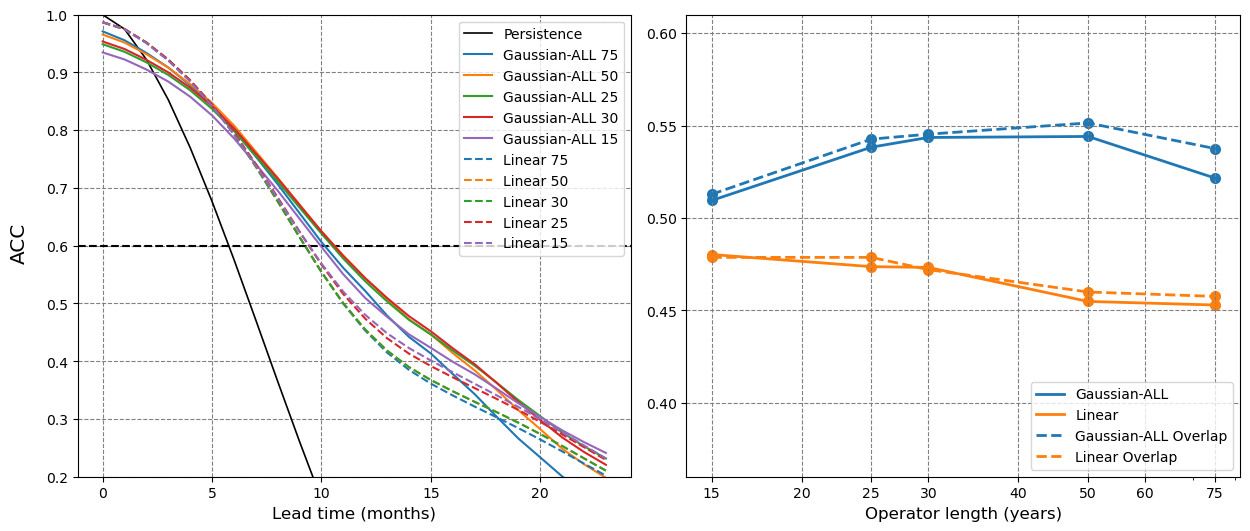

In [35]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(15,6),sharex=False, sharey=False)


##################################################################
#############          ENS. MEAN             ######################
##################################################################

xval=range(0,24)

ax[0].axhline(0.6, linestyle='--',color='black')
ax[0].set_xlabel('Lead time (months)',fontsize=12)
ax[0].set_ylim([0.2,1])
ax[0].set_title('',loc='left')

ax[0].plot(xval, CORR_PERS, lw=1.2, label='Persistence', color='black')


ax[0].plot(xval, np.mean(GaussALL_mean_75, axis=1), lw=1.5, label='Gaussian-ALL 75')
ax[0].plot(xval, np.mean(GaussALL_mean_50, axis=1), lw=1.5, label='Gaussian-ALL 50')
ax[0].plot(xval, np.mean(GaussALL_mean_25, axis=1), lw=1.5, label='Gaussian-ALL 25')
ax[0].plot(xval, np.mean(GaussALL_mean_30, axis=1), lw=1.5, label='Gaussian-ALL 30')
ax[0].plot(xval, np.mean(GaussALL_mean_15, axis=1), lw=1.5, label='Gaussian-ALL 15')


ax[0].set_prop_cycle(None)

ax[0].plot(xval, np.mean(Poly_mean_75, axis=1), lw=1.5, label='Linear 75', linestyle='dashed')
ax[0].plot(xval, np.mean(Poly_mean_50, axis=1), lw=1.5, label='Linear 50', linestyle='dashed')
ax[0].plot(xval, np.mean(Poly_mean_50, axis=1), lw=1.5, label='Linear 30', linestyle='dashed')
ax[0].plot(xval, np.mean(Poly_mean_25, axis=1), lw=1.5, label='Linear 25', linestyle='dashed')
ax[0].plot(xval, np.mean(Poly_mean_15, axis=1), lw=1.5, label='Linear 15', linestyle='dashed')



'''ax[0].plot(xval, np.mean(GaussALL_mean_75_OV, axis=1), lw=1.5, label='Gaussian-ALL OV 75', linestyle='dashed')
ax[0].plot(xval, np.mean(GaussALL_mean_50_OV, axis=1), lw=1.5, label='Gaussian-ALL OV 50', linestyle='dashed')
#ax[0].plot(xval, np.mean(GaussALL_mean_30_OV, axis=1), lw=1.5, label='Gaussian-ALL OV 30', linestyle='dashed')
ax[0].plot(xval, np.mean(GaussALL_mean_25_OV, axis=1), lw=1.5, label='Gaussian-ALL OV 25', linestyle='dashed')'''


bigtitle = '' 
ax[0].set_title(bigtitle,fontsize=16)
ax[0].yaxis.grid(color='gray', linestyle='dashed')
ax[0].xaxis.grid(color='gray', linestyle='dashed')

ax[0].legend(loc='upper right')


##################################################################
#############          NEW VISION             ######################
##################################################################

xval_400=[15,25,30, 50, 75]
xval=[15,20, 25,30, 40, 50, 60,75]

#ax.axhline(corr, linestyle='--',color='black', label='Persistence')
ax[1].set_xlabel('Operator length (years)',fontsize=12)
ax[1].set_ylim([0.36,0.61])
ax[1].set_title('',loc='left')

ax[1].scatter(xval_400, acc_gauss_mean, lw=2)
ax[1].plot(xval_400, acc_gauss_mean, lw=2, label='Gaussian-ALL')
ax[1].scatter(xval_400, acc_poly_mean, lw=2)
ax[1].plot(xval_400, acc_poly_mean, lw=2, label='Linear')

ax[1].set_prop_cycle(None)

ax[1].scatter(xval_400, acc_gauss_mean_OV, lw=2)
ax[1].plot(xval_400, acc_gauss_mean_OV, lw=2, label='Gaussian-ALL Overlap', linestyle='dashed')
ax[1].scatter(xval_400, acc_poly_mean_OV, lw=2)
ax[1].plot(xval_400, acc_poly_mean_OV, lw=2, label='Linear Overlap', linestyle='dashed')


#ax[1].plot(xval, acc_poly_mean, lw=2, label='Linear mean', linestyle='dotted')
#ax[1].plot(xval, acc_poly_mean_OV, lw=2, label='Linear member OV', linestyle='dotted')


bigtitle = f'Niño 3.4 ACC ({lead} months)' 
ax[1].set_title(bigtitle,fontsize=16)
ax[1].yaxis.grid(color='gray', linestyle='dashed')
ax[1].xaxis.grid(color='gray', linestyle='dashed')
plt.xscale("log")
plt.xticks(ticks=xval, labels=['15','20', '25', '30','40' , '50', '60','75'])

ax[1].legend(loc='upper right')


bigtitle = '' 
ax[1].set_title(bigtitle,fontsize=16)
ax[1].yaxis.grid(color='gray', linestyle='dashed')
ax[1].xaxis.grid(color='gray', linestyle='dashed')
fig.text(0.08, 0.5, 'ACC', va='center', rotation='vertical',fontsize='x-large')
plt.subplots_adjust(wspace=0.1)

ax[1].legend(loc='lower right')

plt.savefig('Fig 9.pdf', orientation='landscape',  format='pdf')
plt.savefig('Fig 9.jpg', orientation='landscape',  format='jpg')
plt.show() 

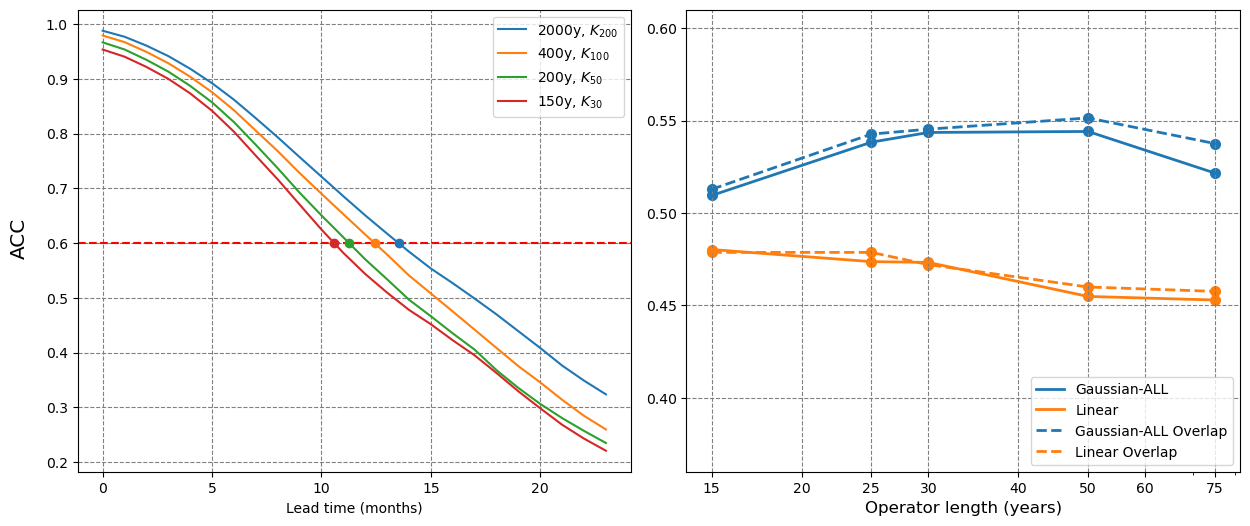

In [38]:
fig, axs = plt.subplots(nrows=1, ncols=2,figsize=(15,6),sharex=False, sharey=False)


##################################################################
#############          ENS. MEAN             ######################
##################################################################

# Example data for multiple arrays
arrays = [
    (range(0,24),GaussALL_mean_200 ),
    (range(0,24), np.mean(GaussALL_mean_100_400, axis=1)),
    (range(0,24), np.mean(GaussALL_mean_50_200, axis=1)),
    (range(0,24), np.mean(GaussALL_mean_30_150, axis=1))
]

labels = [
    '2000y, $K_{200}$',
    '400y, $K_{100}$',
    '200y, $K_{50}$',
    '150y, $K_{30}$'
]

# Horizontal line
y_horiz = 0.6  # y-value of the horizontal line


# List to store all intersection points
all_intersections = []

# Left panel
ax = axs[0]

# List to store all intersection points
all_intersections = []

for i, (x, y) in enumerate(arrays):
    # Find where the array crosses the horizontal line
    differences = y - y_horiz
    sign_changes = np.where(np.diff(np.sign(differences)))[0]

    crossings_x = []
    crossings_y = []
    intersections = []  # To store intersections for this array

    for index in sign_changes:
        x1, x2 = x[index], x[index + 1]
        y1, y2 = y[index], y[index + 1]

        # Linear interpolation to find the exact crossing point
        x_cross = x1 + (y_horiz - y1) * (x2 - x1) / (y2 - y1)
        crossings_x.append(x_cross)
        crossings_y.append(y_horiz)
        intersections.append((x_cross, y_horiz))

    # Store intersections for this array
    all_intersections.append(intersections)

    # Plot the array
    ax.plot(x, y, label=labels[i])

    # Plot the intersections
    ax.scatter(crossings_x, crossings_y, zorder=5)

# Plot the horizontal line
ax.axhline(y=y_horiz, color='r', linestyle='--')

ax.set_xlabel('Lead time (months)')
#ax.set_ylabel('ACC')
ax.legend()
axs[0].yaxis.grid(color='gray', linestyle='dashed')
axs[0].xaxis.grid(color='gray', linestyle='dashed')




##################################################################
#############          NEW VISION             ######################
##################################################################

# Right panel (left blank)
#axs[1].axis('off')

xval_400=[15,25,30, 50, 75]
xval=[15,20, 25,30, 40, 50, 60,75]

#ax.axhline(corr, linestyle='--',color='black', label='Persistence')
axs[1].set_xlabel('Operator length (years)',fontsize=12)
axs[1].set_ylim([0.36,0.61])
axs[1].set_title('',loc='left')

axs[1].scatter(xval_400, acc_gauss_mean, lw=2)
axs[1].plot(xval_400, acc_gauss_mean, lw=2, label='Gaussian-ALL')
axs[1].scatter(xval_400, acc_poly_mean, lw=2)
axs[1].plot(xval_400, acc_poly_mean, lw=2, label='Linear')

axs[1].set_prop_cycle(None)

axs[1].scatter(xval_400, acc_gauss_mean_OV, lw=2)
axs[1].plot(xval_400, acc_gauss_mean_OV, lw=2, label='Gaussian-ALL Overlap', linestyle='dashed')
axs[1].scatter(xval_400, acc_poly_mean_OV, lw=2)
axs[1].plot(xval_400, acc_poly_mean_OV, lw=2, label='Linear Overlap', linestyle='dashed')

bigtitle = f'Niño 3.4 ACC ({lead} months)' 
axs[1].set_title(bigtitle,fontsize=16)
axs[1].yaxis.grid(color='gray', linestyle='dashed')
axs[1].xaxis.grid(color='gray', linestyle='dashed')
plt.xscale("log")
plt.xticks(ticks=xval, labels=['15','20', '25', '30','40' , '50', '60','75'])

axs[1].legend(loc='upper right')


bigtitle = '' 
axs[1].set_title(bigtitle,fontsize=16)
axs[1].yaxis.grid(color='gray', linestyle='dashed')
axs[1].xaxis.grid(color='gray', linestyle='dashed')
fig.text(0.08, 0.5, 'ACC', va='center', rotation='vertical',fontsize='x-large')
plt.subplots_adjust(wspace=0.1)

axs[1].legend(loc='lower right')

#plt.savefig('Fig 12.pdf', orientation='landscape',  format='pdf')
#plt.savefig('Fig 12.jpg', orientation='landscape',  format='jpg')
plt.show() 

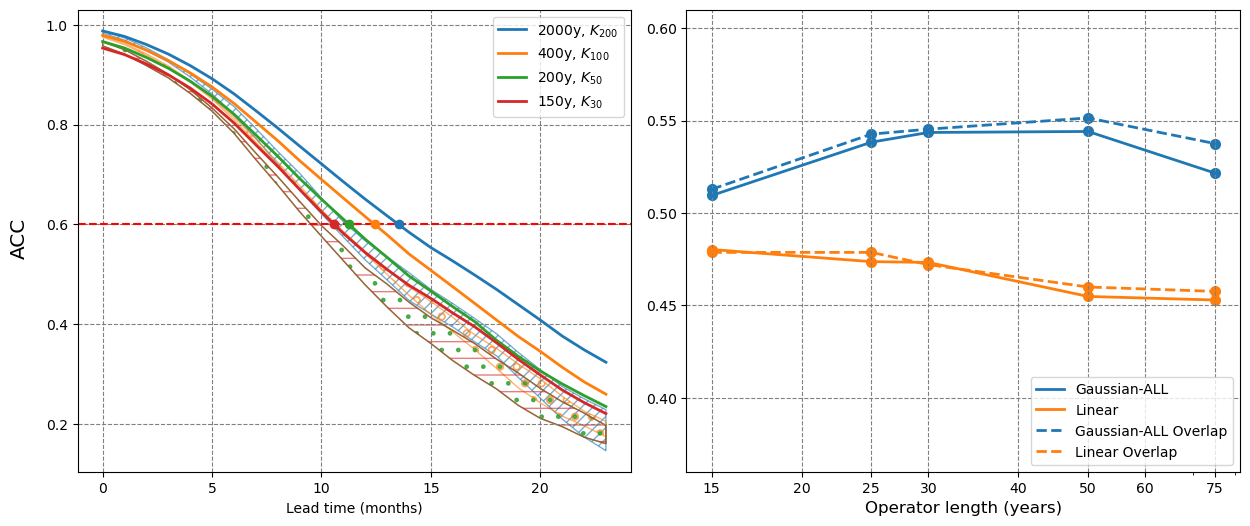

In [39]:
fig, axs = plt.subplots(nrows=1, ncols=2,figsize=(15,6),sharex=False, sharey=False)


##################################################################
#############          ENS. MEAN             ######################
##################################################################

# Example data for multiple arrays
arrays = [
    (range(0,24),GaussALL_mean_200 ),
    (range(0,24), np.mean(GaussALL_mean_100_400, axis=1)),
    (range(0,24), np.mean(GaussALL_mean_50_200, axis=1)),
    (range(0,24), np.mean(GaussALL_mean_30_150, axis=1))
]

labels = [
    '2000y, $K_{200}$',
    '400y, $K_{100}$',
    '200y, $K_{50}$',
    '150y, $K_{30}$'
]

# Horizontal line
y_horiz = 0.6  # y-value of the horizontal line


# List to store all intersection points
all_intersections = []

# Left panel
ax = axs[0]

# Calculate the minimum and maximum y-values for each x-value
y_min0=np.min(GaussALL_ind_200 , axis=1)
y_max0 = np.max(GaussALL_ind_200, axis=1)
ax.fill_between(range(0,24), y_min0, y_max0, color='#1f77b4', alpha=0.6, facecolor='none', hatch='///', edgecolor='#1f77b4')

y_min1=np.min(np.mean(GaussALL_ind_100_400, axis=2) , axis=1)
y_max1 = np.max(np.mean(GaussALL_ind_100_400, axis=2), axis=1)
ax.fill_between(range(0,24), y_min1, y_max1, color='#ff7f0e', alpha=0.6, facecolor='none', hatch='o', edgecolor='#ff7f0e')

y_min2=np.min(np.mean(GaussALL_ind_50_200, axis=2), axis=1)
y_max2 = np.max(np.mean(GaussALL_ind_50_200, axis=2), axis=1)
ax.fill_between(range(0,24), y_min2, y_max2, color='#2ca02c', alpha=0.8, facecolor='none', hatch='.', edgecolor='#2ca02c')

y_min3=np.min(np.mean(GaussALL_ind_30_150, axis=2) , axis=1)
y_max3 = np.max(np.mean(GaussALL_ind_30_150, axis=2), axis=1)
ax.fill_between(range(0,24), y_min2, y_max2, color='#d62728', alpha=0.6, facecolor='none', hatch='-', edgecolor='#d62728')


# List to store all intersection points
all_intersections = []

for i, (x, y) in enumerate(arrays):
    # Find where the array crosses the horizontal line
    differences = y - y_horiz
    sign_changes = np.where(np.diff(np.sign(differences)))[0]

    crossings_x = []
    crossings_y = []
    intersections = []  # To store intersections for this array

    for index in sign_changes:
        x1, x2 = x[index], x[index + 1]
        y1, y2 = y[index], y[index + 1]

        # Linear interpolation to find the exact crossing point
        x_cross = x1 + (y_horiz - y1) * (x2 - x1) / (y2 - y1)
        crossings_x.append(x_cross)
        crossings_y.append(y_horiz)
        intersections.append((x_cross, y_horiz))

    # Store intersections for this array
    all_intersections.append(intersections)

    # Plot the array
    ax.plot(x, y, label=labels[i], linewidth=2)

    # Plot the intersections
    ax.scatter(crossings_x, crossings_y, zorder=5)


# Plot the horizontal line
ax.axhline(y=y_horiz, color='r', linestyle='--')

ax.set_xlabel('Lead time (months)')
#ax.set_ylabel('ACC')
ax.legend()
axs[0].yaxis.grid(color='gray', linestyle='dashed')
axs[0].xaxis.grid(color='gray', linestyle='dashed')




##################################################################
#############          NEW VISION             ######################
##################################################################

# Right panel (left blank)
#axs[1].axis('off')

xval_400=[15,25,30, 50, 75]
xval=[15,20, 25,30, 40, 50, 60,75]

#ax.axhline(corr, linestyle='--',color='black', label='Persistence')
axs[1].set_xlabel('Operator length (years)',fontsize=12)
axs[1].set_ylim([0.36,0.61])
axs[1].set_title('',loc='left')

axs[1].scatter(xval_400, acc_gauss_mean, lw=2)
axs[1].plot(xval_400, acc_gauss_mean, lw=2, label='Gaussian-ALL')
axs[1].scatter(xval_400, acc_poly_mean, lw=2)
axs[1].plot(xval_400, acc_poly_mean, lw=2, label='Linear')

axs[1].set_prop_cycle(None)

axs[1].scatter(xval_400, acc_gauss_mean_OV, lw=2)
axs[1].plot(xval_400, acc_gauss_mean_OV, lw=2, label='Gaussian-ALL Overlap', linestyle='dashed')
axs[1].scatter(xval_400, acc_poly_mean_OV, lw=2)
axs[1].plot(xval_400, acc_poly_mean_OV, lw=2, label='Linear Overlap', linestyle='dashed')

bigtitle = f'Niño 3.4 ACC ({lead} months)' 
axs[1].set_title(bigtitle,fontsize=16)
axs[1].yaxis.grid(color='gray', linestyle='dashed')
axs[1].xaxis.grid(color='gray', linestyle='dashed')
plt.xscale("log")
plt.xticks(ticks=xval, labels=['15','20', '25', '30','40' , '50', '60','75'])

axs[1].legend(loc='upper right')


bigtitle = '' 
axs[1].set_title(bigtitle,fontsize=16)
axs[1].yaxis.grid(color='gray', linestyle='dashed')
axs[1].xaxis.grid(color='gray', linestyle='dashed')
fig.text(0.08, 0.5, 'ACC', va='center', rotation='vertical',fontsize='x-large')
plt.subplots_adjust(wspace=0.1)

axs[1].legend(loc='lower right')

#plt.savefig('Fig 11.pdf', orientation='landscape',  format='pdf')
#plt.savefig('Fig 11.jpg', orientation='landscape',  format='jpg')
plt.show() 

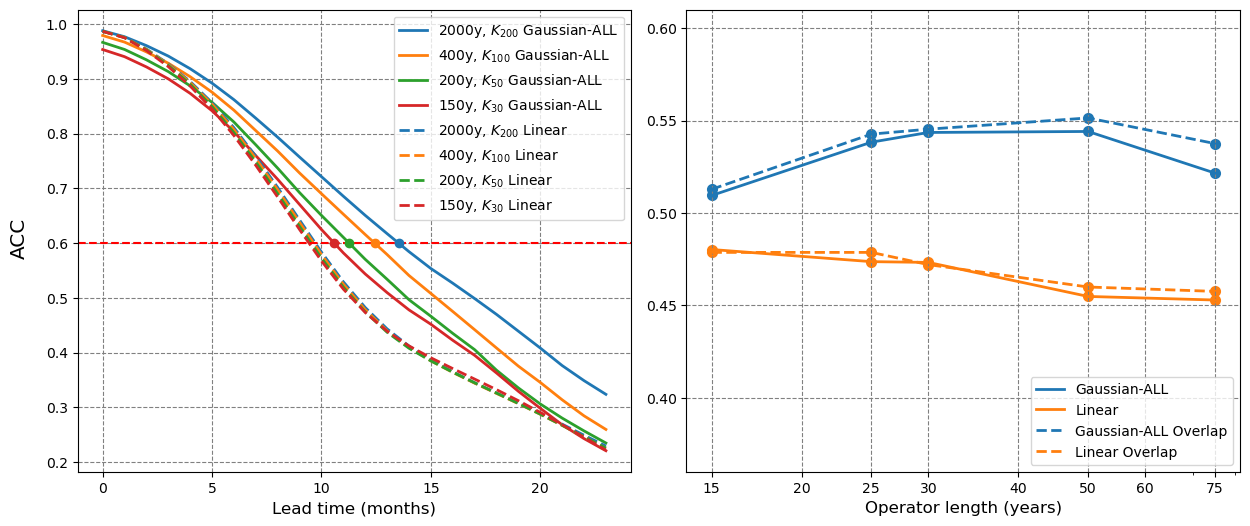

In [48]:
fig, axs = plt.subplots(nrows=1, ncols=2,figsize=(15,6),sharex=False, sharey=False)


##################################################################
#############          ENS. MEAN             ######################
##################################################################

# Example data for multiple arrays
arrays = [
    (range(0,24),GaussALL_mean_200, Poly_mean_200 ),
    (range(0,24), np.mean(GaussALL_mean_100_400, axis=1), np.mean(Poly_mean_100_400, axis=1)),
    (range(0,24), np.mean(GaussALL_mean_50_200, axis=1), np.mean(Poly_mean_50_200, axis=1)),
    (range(0,24), np.mean(GaussALL_mean_30_150, axis=1), np.mean(Poly_mean_30_150, axis=1))
]

labels = [
    '2000y, $K_{200}$ Gaussian-ALL',
    '400y, $K_{100}$ Gaussian-ALL',
    '200y, $K_{50}$ Gaussian-ALL',
    '150y, $K_{30}$ Gaussian-ALL'
]

labels1 = [
    '2000y, $K_{200}$ Linear',
    '400y, $K_{100}$ Linear',
    '200y, $K_{50}$ Linear',
    '150y, $K_{30}$ Linear'
]

# Horizontal line
y_horiz = 0.6  # y-value of the horizontal line


# List to store all intersection points
all_intersections = []

# Left panel
ax = axs[0]


# List to store all intersection points
all_intersections = []

for i, (x, y, z) in enumerate(arrays):
    # Find where the array crosses the horizontal line
    differences = y - y_horiz
    sign_changes = np.where(np.diff(np.sign(differences)))[0]

    crossings_x = []
    crossings_y = []
    intersections = []  # To store intersections for this array

    for index in sign_changes:
        x1, x2 = x[index], x[index + 1]
        y1, y2 = y[index], y[index + 1]

        # Linear interpolation to find the exact crossing point
        x_cross = x1 + (y_horiz - y1) * (x2 - x1) / (y2 - y1)
        crossings_x.append(x_cross)
        crossings_y.append(y_horiz)
        intersections.append((x_cross, y_horiz))

    # Store intersections for this array
    all_intersections.append(intersections)

    # Plot the array
    ax.plot(x, y, label=labels[i], linewidth=2)
    # Plot the intersections
    ax.scatter(crossings_x, crossings_y, zorder=5)

ax.set_prop_cycle(None)

for i, (x, y, z) in enumerate(arrays):
    # Find where the array crosses the horizontal line
    differences = y - y_horiz
    sign_changes = np.where(np.diff(np.sign(differences)))[0]

    crossings_x = []
    crossings_y = []
    intersections = []  # To store intersections for this array

    for index in sign_changes:
        x1, x2 = x[index], x[index + 1]
        y1, y2 = y[index], y[index + 1]

        # Linear interpolation to find the exact crossing point
        x_cross = x1 + (y_horiz - y1) * (x2 - x1) / (y2 - y1)
        crossings_x.append(x_cross)
        crossings_y.append(y_horiz)
        intersections.append((x_cross, y_horiz))

    # Store intersections for this array
    all_intersections.append(intersections)

    # Plot the array
    ax.plot(x, z, label=labels1[i], linewidth=2, linestyle='dashed')


# Plot the horizontal line
ax.axhline(y=y_horiz, color='r', linestyle='--')

ax.set_xlabel('Lead time (months)',fontsize=12)
#ax.set_ylabel('ACC')
ax.legend()
axs[0].yaxis.grid(color='gray', linestyle='dashed')
axs[0].xaxis.grid(color='gray', linestyle='dashed')




##################################################################
#############          NEW VISION             ######################
##################################################################

# Right panel (left blank)
#axs[1].axis('off')

xval_400=[15,25,30, 50, 75]
xval=[15,20, 25,30, 40, 50, 60,75]

#ax.axhline(corr, linestyle='--',color='black', label='Persistence')
axs[1].set_xlabel('Operator length (years)',fontsize=12)
axs[1].set_ylim([0.36,0.61])
axs[1].set_title('',loc='left')

axs[1].scatter(xval_400, acc_gauss_mean, lw=2)
axs[1].plot(xval_400, acc_gauss_mean, lw=2, label='Gaussian-ALL')
axs[1].scatter(xval_400, acc_poly_mean, lw=2)
axs[1].plot(xval_400, acc_poly_mean, lw=2, label='Linear')

axs[1].set_prop_cycle(None)

axs[1].scatter(xval_400, acc_gauss_mean_OV, lw=2)
axs[1].plot(xval_400, acc_gauss_mean_OV, lw=2, label='Gaussian-ALL Overlap', linestyle='dashed')
axs[1].scatter(xval_400, acc_poly_mean_OV, lw=2)
axs[1].plot(xval_400, acc_poly_mean_OV, lw=2, label='Linear Overlap', linestyle='dashed')

bigtitle = f'Niño 3.4 ACC ({lead} months)' 
axs[1].set_title(bigtitle,fontsize=16)
axs[1].yaxis.grid(color='gray', linestyle='dashed')
axs[1].xaxis.grid(color='gray', linestyle='dashed')
plt.xscale("log")
plt.xticks(ticks=xval, labels=['15','20', '25', '30','40' , '50', '60','75'])

axs[1].legend(loc='upper right')


bigtitle = '' 
axs[1].set_title(bigtitle,fontsize=16)
axs[1].yaxis.grid(color='gray', linestyle='dashed')
axs[1].xaxis.grid(color='gray', linestyle='dashed')
fig.text(0.08, 0.5, 'ACC', va='center', rotation='vertical',fontsize='x-large')
plt.subplots_adjust(wspace=0.1)

axs[1].legend(loc='lower right')

plt.savefig('Fig 11.pdf', orientation='landscape',  format='pdf')
plt.savefig('Fig 11.jpg', orientation='landscape',  format='jpg')
plt.show() 